In [148]:
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti
import numpy as np
import tensorflow as tf
import time
import pickle

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 4*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

from tensorflow.math import sin, cos, tan
import tensorflow_probability as tfp
import sys
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
from ICET_spherical import ICET
from utils import *
from metpy.calc import lat_lon_grid_deltas
from pioneer.das.api.platform import Platform
from scipy.spatial.transform import Rotation as R
from pioneer.das.api.egomotion.imu_egomotion_provider import IMUEgomotionProvider as emp 
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 180 seconds


# Goal: Simultaneously Estimate Translation, Rotation, and Distortion

## $\mathbf{A} = [\hat{X}_{ij}, \hat{m}_{ij}] = 
\begin{bmatrix}
% x, ~ y, ~ z, ~ \phi, ~ \theta, ~ \psi, ~ x^+, ~y^+, ~z^+, ~\phi^+, ~\theta^+, ~\psi^+ \\
x, ~ y, ~ z, ~ \phi, ~ \theta, ~ \psi, ~ x^+, ~y^+, ~z^+, ~\phi^+, ~\theta^+, ~\psi^+ \\
\end{bmatrix}$

We can use newton-raphson to find A

<!-- ## $y_i = \mathbf{h}(y_j, \hat{X}_{ij}, \hat{m}_{ij}) + \mathbf{H}_m \delta m + \mathbf{H}_x \delta x + \text{H.O.T.}$ -->

## $y_i = \mathbf{h}(y_j, \hat{A}_{ij}) + \mathbf{H}_A \delta A + \text{H.O.T.}$

## $\mathbf{H}_A \in \mathbb{R}^{4N \times 12} $



### $\mathbf{H}_A = [H_X, H_m]$

# Problem:  what if distortion correction and rigid transform both work equally well?

(ex: there are not enough features on one side to completely enclose the vehicle)

### IT MAKES LIFE WAY EASIER IF I SUPPRESS ANGULAR COMPONENT OF MOTION PROFILE??

### Run Demo

In [211]:
# load point cloud
# # no distortion
# old_cloud =  np.load("sample_data/paper_figures/case1/raw_frame_0.npy")
# # m_hat = np.array([0., 0., 0., 0., 0., 0.0]) #actual motion
# m_hat = np.array([-3., 0., 0., 0., 0., 0.1]) #test wrap around

# # movement in x
# old_cloud =  np.load("sample_data/paper_figures/case2/raw_frame_3.npy") 
# # m_hat = np.array([3, 0, 0., 0., 0., 0])
# m_hat = np.array([3., 0, 0., 0., 0., -0.2]) #FOR DEBUG-- deform just a little
# gt =  np.load("sample_data/paper_figures/case2/base_vel_2.npy")

# movement in x, y, & yaw
old_cloud =  np.load("sample_data/paper_figures/case3/raw_frame_1.npy") 
m_hat = np.array([3, -1, 0., 0., 0., -1])
# m_hat = np.array([3, -1, 0., 0., 0., -0.86]) #FOR DEBUG-- deform a little extra
# m_hat = np.array([3., -1., 0., 0., 0., -0.1]) #FOR DEBUG
gt =  np.load("sample_data/paper_figures/case3/base_vel_2.npy")
# print(gt) 

# period_lidar = 1
# t_scale = (2*np.pi)/(-m_hat[-1] + (2*np.pi/period_lidar))
# print(t_scale)
# m_hat = m_hat*t_scale
# # m_hat[-1] = m_hat[-1]*t_scaled
# print(m_hat)

#downsample
old_cloud = old_cloud[::5,:]

In [212]:
#apply ground truth distortion according to m_hat
try:
    new_cloud = dc.apply_motion_profile(old_cloud, m_hat, period_lidar=1)
except:
    from remove_motion_basic import linear_correction_old as lc #old method (straight from ROS node) 
    print("using backup")
    new_cloud = lc(old_cloud, m_hat) 

#set ground truth transform between clouds
# X_gt = np.array([0, 0., 0.0, 0.0, 0.0, 0.0])
# X_gt = np.array([1.5, 0.5, 0.03, 0.03, 0.03, 0.25])
# X_gt = np.array([1.5, -3, 0.1, 0.2, 0.03, -0.15])
X_gt = np.array([-1., 0., 0.0, 0., 0., 0.])

# add noise
old_cloud += 0.01*np.random.randn(np.shape(old_cloud)[0], 3)

# #for fig: mess up both again to show that relative distortion remains constant
# new_cloud = lc(new_cloud, -m_hat)
# old_cloud = lc(old_cloud, -m_hat)
# old_cloud = lc(old_cloud, 0.2*m_hat)

# #remove ground plane
# old_cloud = old_cloud[old_cloud[:,2] > -1] 
# new_cloud = new_cloud[new_cloud[:,2] > -1] 

#remove left half of each point cloud
# old_cloud = old_cloud[:(len(old_cloud)//2),:]
# new_cloud = new_cloud[:(len(new_cloud)//2),:]
# # 2/3 of each point cloud
# old_cloud = old_cloud[:(len(old_cloud)//3),:]
# new_cloud = new_cloud[:(len(new_cloud)//3),:]

# #get rid of two walls but leave ground plane
# a = np.where(old_cloud[:,2] < -1.4) 
# b = np.where(old_cloud[:,1] > 0)
# c = np.where(old_cloud[:,0] > -8)
# idx = np.union1d(np.intersect1d(b,c),a)
# old_cloud = old_cloud[idx]
# new_cloud = new_cloud[idx]

# Rotate + Translate new point cloud
trans = X_gt[:3]
rot = R_tf(X_gt[3:]).numpy()
new_cloud = (new_cloud @ rot) + trans

plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp=[]
disp.append(Points(old_cloud, c = "#CB2314")) 
# disp.append(Points(old_cloud[:4000], c = "#CB2314")) 
disp.append(Points(new_cloud, c = "#2c7c94")) 
plt.show(disp, "raw point clouds")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

### Attempt to solve with basic 6 state solution (Impossible)

In [151]:
from linear_corrector import LC
pc1 = old_cloud
pc2  = new_cloud
m_hat0 = np.array([0, 0, 0, 0, 0, 0.])
dc = LC(cloud1 = pc2, cloud2 = pc1, fid = 50, niter = 20, draw = True, 
        m_hat0 = m_hat0,  mnp = 25, RM = False, solver='6_state')
ViewInteractiveWidget(dc.plt.window)


~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
took 0.017653226852416992 sec  to apply motion profile
took 0.0022406578063964844 sec to get H
m_hat:  [ 8.40298593e-01 -1.62686080e-01 -8.23249400e-04  6.74190233e-05
  2.29316996e-04 -1.35478213e-01]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
took 0.015016317367553711 sec  to apply motion profile
took 0.0022835731506347656 sec to get H
m_hat:  [ 1.05157650e+00 -1.98209390e-01 -4.87341051e-04  1.37907322e-04
 -3.24279245e-04 -1.49486408e-01]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
took 0.014552116394042969 sec  to apply motion profile
took 0.002294778823852539 sec to get H
m_hat:  [ 1.14036608e+00 -1.81131661e-01 -4.34467773e-04  1.96422625e-04
 -5.07266552e-04 -1.51352033e-01]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
took 0.018336772918701172 sec  to apply motion profile
took 0.002682924270629883 sec to get H
m_hat:  [ 1.17885685e+00 -1.71997264e-01 -5.26087126e-04  2.12819781e-04
 -6.03790220e-04 -1.51608169e-01]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
took 0.015221357345

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

### Run Newton-Raphson with a priori correspondences

In [213]:
A_hat = np.array([0., 0, 0, 0, 0, 0, 
                  0, 0, 0, 0, 0, 0])
skip = 1 #50
y_i = new_cloud[::skip] #baseline
y_j = old_cloud[::skip] #distorted cloud

print("num corr total:", len(y_i))

plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp=[]
disp.append(Points(y_i[:,:3], c = "#a65852 ", alpha = 0.5, r=5.5)) #

runlen = 20
for count in range(runlen):
    
    print("~~~~ iteration ", count, "~~~~~~~~~~~")
#     print("A_hat = \n", np.round(A_hat[:6],4), "\n", np.round(A_hat[6:],4)) 
    print("A_hat = \n", A_hat[:6], "\n", A_hat[6:]) 

    #decompose A_hat into X_hat and m_hat
    X_hat = A_hat[:6] 
    m_hat = A_hat[6:]
    
    #apply last estimate of distortion correction
    y_j_undistort = lc(y_j, m_hat)
    #apply last rigid transform
    rot = R_tf(X_hat[3:]).numpy()
    trans = X_hat[:3]
    y_j_undistort = (y_j_undistort @ rot) + trans

#     print("rot: \n", rot,"\n trans: \n", trans)  
#     print("\n y_i \n",np.shape(y_i), "\n", y_i[:3])
#     print("y_j_undistort \n",np.shape(y_j_undistort), "\n", y_j_undistort[:3])
    
    #get jacobain of distortion correction function, [H_X, H_m]
    H_m = dc.get_H_m(y_j_undistort, m_hat) 
#     print("\n H_m:", np.shape(H_m), "\n", H_m[:10])
    
    #get jacobian of rigid transform function 
    H_x = jacobian_tf(tf.transpose(tf.convert_to_tensor(y_j_undistort, tf.float32)), tf.convert_to_tensor(X_hat[3:], tf.float32)) # shape = [num of corr * 3, 6]
    #need to append on a row of zeros since we are working with homogeneous coordinates!
    H_x = tf.reshape(H_x, (tf.shape(H_x)[0]//3, 3, 6)) # -> need shape [#corr//4, 4, 6]
#     print("\n H_x before:", np.shape(H_x), "\n", H_x[0])
    H_x = tf.concat([H_x, tf.zeros([len(H_x),1,6])], axis = 1)
    H_x = tf.reshape(H_x, (-1, 6))
#     print("\n H_x after:", np.shape(H_x), "\n", H_x[:10])
    H_x = H_x.numpy()
        
    #delta_A =  ((H^T*H)^-1)(H^T)(yi - yj_undistort)
    residual = (np.append(y_i, np.ones([len(y_i),1]), axis = 1) -
                np.append(y_j_undistort, np.ones([len(y_i),1]), axis = 1)).flatten()
#     print("residual", np.shape(residual), "\n", residual)
    
    H = np.append(H_x, H_m, axis = 1)
    print("H: \n", np.shape(H))

    print("pinv(HTH): \n", np.shape(np.linalg.pinv(H.T @ H)))
    print("pinv(HTH) @ H.T: \n", np.shape(np.linalg.pinv(H.T @ H) @ H.T))
    
    delta_A = np.linalg.pinv(H.T @ H) @ H.T @ residual
    print("\n delta_A \n", np.round(delta_A[:6], 5), "\n", np.round(delta_A[6:], 5))
    #augment rigid transform components
    A_hat[:6] -=   delta_A[:6]
    #augment distortion components
    A_hat[6:9] -= delta_A[6:9]
    A_hat[9:] += delta_A[9:]

    #plot updated cloud2
#     color = [0.5 + count/(runlen*2), 1 - (count+1)/runlen, (count+1)/runlen]
#     disp.append(Points(y_j_undistort[:,:3], c = color, r=3.5))
    disp.append(Points(y_j_undistort[:,:3], c = "#2c7c94 ", alpha = (count+1)/(runlen+1), r=3.5))

    
plt.show(disp, "12 State Solution")
ViewInteractiveWidget(plt.window)

num corr total: 16564
~~~~ iteration  0 ~~~~~~~~~~~
A_hat = 
 [0. 0. 0. 0. 0. 0.] 
 [0. 0. 0. 0. 0. 0.]
H: 
 (66256, 12)
pinv(HTH): 
 (12, 12)
pinv(HTH) @ H.T: 
 (12, 66256)

 delta_A 
 [-0.56584  0.76722 -0.19435 -0.03138 -0.0458  -0.11555] 
 [ 1.10666 -0.59493  0.66161 -0.09848 -0.07346 -0.98456]
~~~~ iteration  1 ~~~~~~~~~~~
A_hat = 
 [ 0.56583878 -0.76722011  0.1943518   0.03137981  0.04579765  0.11554694] 
 [-1.10666392  0.59493452 -0.66160696 -0.09847959 -0.07345677 -0.98456296]
H: 
 (66256, 12)
pinv(HTH): 
 (12, 12)
pinv(HTH) @ H.T: 
 (12, 66256)

 delta_A 
 [ 1.19999 -1.28673  0.31291  0.03112  0.04663  0.13208] 
 [-1.56804  3.86757 -0.80205  0.10839  0.02281 -0.00928]
~~~~ iteration  2 ~~~~~~~~~~~
A_hat = 
 [-6.34151456e-01  5.19507952e-01 -1.18555071e-01  2.57820849e-04
 -8.37011590e-04 -1.65347540e-02] 
 [ 0.46137887 -3.27263657  0.14044302  0.00991323 -0.05065017 -0.99384135]
H: 
 (66256, 12)
pinv(HTH): 
 (12, 12)
pinv(HTH) @ H.T: 
 (12, 66256)

 delta_A 
 [ 0.69985  0.1087

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

# Run toy problem again with voxel-based correspondences

In [225]:
from linear_corrector import LC

A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
print("actual X, m: \n", X_gt, "\n", m_hat )

dc = LC(cloud1 = new_cloud, cloud2 = old_cloud, fid = 40, niter = 25, 
        draw = True, mnp = 25, RM = False, solver = '12_state', 
        max_buffer = 2.5, A0 = A0)
ViewInteractiveWidget(dc.plt.window)

actual X, m: 
 [-1.  0.  0.  0.  0.  0.] 
 [ 3.00365982e+00 -1.00148271e+00 -6.18400946e-05 -1.97144201e-04
  1.40421207e-04 -9.99716413e-01]
A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([156], shape=(1,), dtype=int32)
LUT tf.Tensor([156   3   3], shape=(3,), dtype=int32)

 residuals (468, 1)

 delta_A
 (12,)
A: 
 [-9.831e-01 -5.654e-01  4.600e-03 -1.000e-04  5.000e-04 -1.138e-01] 
 [-0.049  -0.175  -0.0092 -0.0005 -0.0007 -0.0361]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-0.00275074 -0.00240454 -0.00204491 ...  0.04874914  0.04875091
  0.04875261]
num corr: 
 tf.Tensor([156], shape=(1,), dtype=int32)
LUT tf.Tensor([156   3   3], shape=(3,), dtype=int32)

 residuals (468, 1)

 delta_A
 (12,)
A: 
 [-7.181e-01 -4.484e-01  9.000e-04 -8.000e-04  1.000e-04 -5.310e-02] 
 [-0.0272 -0.1314  0.0031  0.0011 -0.0007 -0.3863]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [-0.00087649 -0.00076245 -0.00063455 .

num corr: 
 tf.Tensor([165], shape=(1,), dtype=int32)
LUT tf.Tensor([165   3   3], shape=(3,), dtype=int32)

 residuals (495, 1)

 delta_A
 (12,)
A: 
 [-0.9952 -0.4084 -0.0079 -0.0018 -0.0019 -0.0196] 
 [ 2.7485e+00 -4.2830e-01  3.5200e-02  6.4000e-03 -3.0000e-04 -8.8520e-01]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 new: 
 [ 0.06765968  0.0564158   0.04417246 ... -2.40845307 -2.40859078
 -2.40869589]
num corr: 
 tf.Tensor([165], shape=(1,), dtype=int32)
LUT tf.Tensor([165   3   3], shape=(3,), dtype=int32)

 residuals (495, 1)

 delta_A
 (12,)
A: 
 [-0.9952 -0.4084 -0.0079 -0.0018 -0.0019 -0.0196] 
 [ 2.7485e+00 -4.2820e-01  3.5200e-02  6.4000e-03 -3.0000e-04 -8.8520e-01]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~

 new: 
 [ 0.06765838  0.05641474  0.04417168 ... -2.40840325 -2.40854096
 -2.40864607]
num corr: 
 tf.Tensor([165], shape=(1,), dtype=int32)
LUT tf.Tensor([165   3   3], shape=(3,), dtype=int32)

 residuals (495, 1)

 delta_A
 (12,)
A: 
 [-0.9952 -0.4084 -0.0079 -0.0018 -0.0019 -0.019

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

# Run 12-State on Ford Campus Dataset

In [226]:
#test registration on single scan pair

i = 110 #990

ground_truth = np.loadtxt("../spherical_paper/FORD_results/truth_body_frame.txt") # [0, v_xandy, v_vertical, r, p, y]
gt = (ground_truth[i,:] + ground_truth[i+1,:])/20 #avg between pts
print("gt: \n", gt[0], gt[1])

fn1 = '/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/Scan%04d.mat' %(i+75)
fn2 = '/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/Scan%04d.mat' %(i+76)
dat1 = mat4py.loadmat(fn1)
SCAN1 = dat1['SCAN']
pc1 = np.transpose(np.array(SCAN1['XYZ']))
dat2 = mat4py.loadmat(fn2)
SCAN2 = dat2['SCAN']
pc2 = np.transpose(np.array(SCAN2['XYZ']))

#flip order in which points appear in each cloud (so scanner spins ccw in stead of cw)
pc1 = np.flip(pc1, axis = 0)
pc2 = np.flip(pc2, axis = 0)
#test: try just flipping sign on y values....
# pc1[:,1] = -pc1[:,1]
# pc2[:,1] = -pc2[:,1]

#need to rotate point clouds so the scan starts aligned with +x axis
rot = R_tf(np.array([0,0,-np.pi/2])).numpy()
pc1 = pc1 @ rot
pc2 = pc2 @ rot

# A0 = np.array([gt[1], 0, 0, 0, 0, 0,
#                0, 0, 0, 0, 0, 0])
A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])

#run 12 State Rigid Transform + Distortion Correction
dc = LC(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 15, A0 = A0,
    draw = True, mnp = 50, RM = False, solver = '12_state', 
        max_buffer = 0.5)
ViewInteractiveWidget(dc.plt.window)

# #just run ICET (for debug)
# it = ICET(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 10, 
#            draw = True, group = 2, RM = True, DNN_filter = False)
# ViewInteractiveWidget(it.plt.window)

gt: 
 0.0 0.252937326996484
A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.1242 -0.0339 -0.0055  0.0006 -0.0011  0.0054] 
 [ 0.0959 -0.0285  0.0069 -0.0012  0.0016 -0.0249]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-0.00035693  0.00079789  0.00010378 ... -0.09316949 -0.09256594
 -0.09206888]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.1637 -0.0306 -0.0028  0.0004 -0.0009  0.0076] 
 [ 0.1286 -0.0283  0.0008 -0.0013  0.0012 -0.0301]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [-5.21807063e-04  1.02444190e-03  9.36239426e-05 ... -1.24848392e-01
 -1.24041209e-01 -1.23376949e-01]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], sh

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

<IPython.core.display.Javascript object>


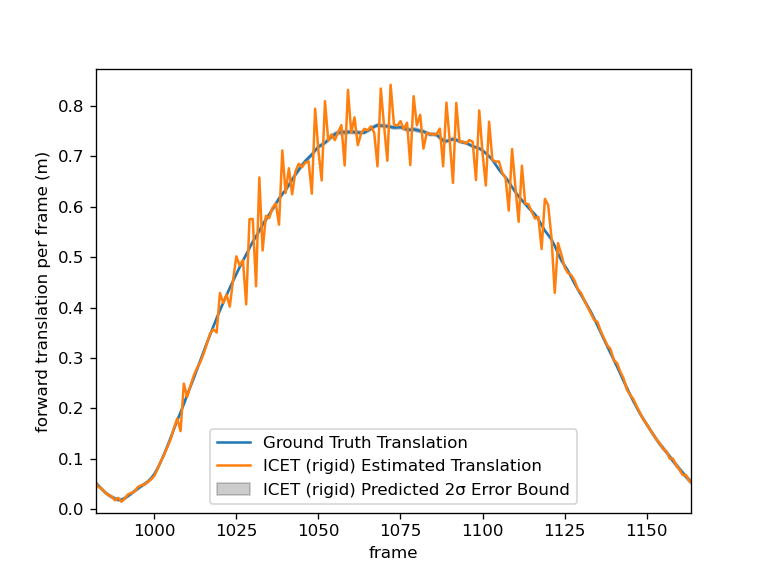

In [270]:
#load ground truth data and rigid transform ICET results
estimates = np.loadtxt("../results/Ford_full_estimates_v10.txt")
pred_stds = np.loadtxt("../results/Ford_full_pred_stds_v10.txt")
ground_truth = np.loadtxt("../spherical_paper/FORD_results/truth_body_frame.txt") # [0, v_xandy, v_vertical, r, p, y]
runlen = np.shape(estimates)[0]
estimates = estimates[1:,:]
pred_stds = pred_stds[1:,:]
vf = (ground_truth[:runlen-1,1]/10 + ground_truth[1:runlen,1]/10)/2 #v5

#plot ground truth vs raw ICET estimates
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(vf, label = 'Ground Truth Translation')
# print(estimates[:,0])
ax.plot(estimates[:,1], label = "ICET (rigid) Estimated Translation") #was this
#NOTE-- adjust linspace here when shifting
ax.fill_between(np.linspace(0,runlen-2,runlen-1),
                   vf - 2*pred_stds[:,1], vf + 2*pred_stds[:,1], 
                   color = [0,0,0], alpha = 0.2, label = 'ICET (rigid) Predicted 2σ Error Bound')
ax.set_xlabel("frame")
ax.set_ylabel("forward translation per frame (m)")
ax.legend(loc = 'best')

In [320]:
from linear_corrector import LC
import mat4py

start_idx = 990 #start on this scan
runlen = 250
m_hat_history = np.zeros([runlen, 6])
X_hat_history = np.zeros([runlen, 6])
X_hat_history_ICET = np.zeros([runlen, 6])
seed_hist = np.zeros([runlen, 6])

A0 = np.array([0., 0, 0, 0, 0, 0,
               0., 0, 0, 0, 0, 0])

for i in range(runlen):
    print("---------------------------------- SCAN IDX", i + start_idx,"-------------------------------------")

    #load point clouds
    fn1 = '/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/Scan%04d.mat' %(i+start_idx+75)
    fn2 = '/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/Scan%04d.mat' %(i+start_idx+76)
    dat1 = mat4py.loadmat(fn1)
    SCAN1 = dat1['SCAN']
    pc1 = np.transpose(np.array(SCAN1['XYZ']))
    dat2 = mat4py.loadmat(fn2)
    SCAN2 = dat2['SCAN']
    pc2 = np.transpose(np.array(SCAN2['XYZ']))

    #align point clouds using ground truth
    ground_truth = np.loadtxt("/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/FORD_DS1_truth.txt")/10
    ground_truth = tf.cast(tf.convert_to_tensor(ground_truth), tf.float32)
    gt = (ground_truth[i+start_idx,:] + ground_truth[i+start_idx+1,:])/2 #avg between pts
        
    #flip order in which points appear in each cloud (so scanner spins ccw in stead of cw)
    pc1 = np.flip(pc1, axis = 0)
    pc2 = np.flip(pc2, axis = 0)
    #need to rotate point clouds so the scan starts aligned with +x axis
    rot = R_tf(np.array([0,0,-np.pi/2])).numpy()
    pc1 = pc1 @ rot
    pc2 = pc2 @ rot

#     #apply "ground truth" transform to point clouds
#     trans = np.array([gt[1], gt[0], gt[2]])
#     trans[0] += 0.01 #add noise to x
#     rot = R_tf(-gt[3:]).numpy().T
#     pc2_transformed =  (pc2 @ rot) + trans 
    
#     print("\n trans, rot GT: \n", trans, -gt[3:].numpy())

    
#     #apply output of ICET to raw point clouds ~~~~~~~~~~~~~~~~~~~
#     #align point clouds using ICET output, seed ICET input with ground truth to ensure convergence
#     it = ICET(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 10, 
#            draw = False, group = 2, RM = True, DNN_filter = False, x0 = gt)
#     #ViewInteractiveWidget(it.plt.window)
#     gt = it.X
#     trans = it.X[:3].numpy()
#     rot = R_tf(-it.X[3:]).numpy().T
#     pc2_transformed =  (pc2 @ rot) + trans 
#     print("\n trans, rot it.X \n", trans, -it.X[3:].numpy())
#     #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
#     #run 12 State Rigid Transform + Distortion Correction
#     dc = LC(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 25, 
#         draw = False, mnp = 25, RM = True, solver = '12_state', max_buffer = 1.0)
    
    noise = 0.05*np.random.randn()
#     run 6 State Rigid Transform ONLY
    x0 = tf.constant([gt[1].numpy()+noise, 0, 0, 0, 0, 0], tf.float32)
    it = ICET(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 10, x0 = x0,
           draw = False, group = 2, RM = True, DNN_filter = False)
    seed_hist[i,0] = gt[1].numpy()+noise
    
#     #seed initial alignments close to GT solution
#     A0 = np.array([gt[1]+noise, 0, 0, 0, 0, 0,
#                    0,           0, 0, 0, 0, 0])
    #seed initial alignments close to ICET solution
    A0 = np.array([it.X[0], it.X[1], it.X[2], it.X[3], it.X[4], it.X[5],
                   0, 0, 0, 0, 0, 0])
    #run 12 State Rigid Transform + Distortion Correction
    dc = LC(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 25, A0 = A0,
        draw = False, mnp = 50, RM = False, solver = '12_state', 
            max_buffer = 0.3)
#     A0[:6] = dc.A[:6]
    
#     print(dc.m_hat)
    X_hat_history[i,:] = dc.A[:6]
    m_hat_history[i,:] = dc.A[6:]
    X_hat_history_ICET[i,:] = it.X

---------------------------------- SCAN IDX 990 -------------------------------------
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor([ 0.02233937  0.00067774 -0.00012921  0.00014718 -0.00038156 -0.00046692], shape=(6,), dtype=float32)
A0:
 [ 0.02233937  0.00067774 -0.00012921  0.00014718 -0.00038156 -0.00046692
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.0194 -0.0041 -0.0009  0.0004 -0.0005 -0.0014] 
 [-0.0017 -0.003   0.0001 -0.0008  0.0005  0.0021]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-2.15229026e-05  2.72747915e-05  1.74878020e-05 ...  1.63789130e-03
  1.5

num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.0168 -0.0083 -0.0019  0.0002 -0.0008 -0.0024] 
 [-0.0032 -0.0057  0.0035 -0.0004  0.001   0.0042]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~

 new: 
 [-4.19019243e-05  5.19223368e-05  3.30967405e-05 ...  3.14903567e-03
  3.06925238e-03  3.04214481e-03]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.0168 -0.0083 -0.0019  0.0002 -0.0008 -0.0024] 
 [-0.0032 -0.0057  0.0035 -0.0004  0.001   0.0042]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 new: 
 [-4.18992464e-05  5.19192349e-05  3.30948037e-05 ...  3.14884178e-03
  3.06906341e-03  3.04195712e-03]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.0168 -0.0083 -0.0019  0.0002 -0.0008 -0.002

num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.011  -0.0038  0.001  -0.0001 -0.001  -0.0023] 
 [-0.0029 -0.0033 -0.003  -0.0003  0.0004  0.0044]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 new: 
 [-3.86866827e-05  3.05136993e-05  5.32397066e-05 ...  2.90911706e-03
  2.84535677e-03  2.83010782e-03]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.011  -0.0038  0.001  -0.0001 -0.001  -0.0023] 
 [-0.0029 -0.0033 -0.003  -0.0003  0.0004  0.0044]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~

 new: 
 [-3.87042590e-05  3.05269921e-05  5.32631361e-05 ...  2.91041465e-03
  2.84662592e-03  2.83137017e-03]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.011  -0.0038  0.001  -0.0001 -0.001  -0.002

num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.021  -0.0077 -0.0021  0.0005 -0.0002 -0.0012] 
 [-0.0003 -0.0039  0.0019 -0.0003 -0.0006  0.0022]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 new: 
 [-1.68403723e-06 -3.36143570e-06  2.72000311e-06 ...  2.55516986e-04
  2.49050870e-04  2.46851676e-04]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.021  -0.0077 -0.0021  0.0005 -0.0002 -0.0012] 
 [-0.0003 -0.0039  0.0019 -0.0003 -0.0006  0.0022]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 new: 
 [-1.68484668e-06 -3.36305067e-06  2.72131093e-06 ...  2.55639820e-04
  2.49170595e-04  2.46970345e-04]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.021  -0.0077 -0.0021  0.0005 -0.0002 -0.001

num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.0272 -0.0031  0.0006  0.0001  0.0008  0.    ] 
 [-0.0005  0.0002 -0.0001  0.0005 -0.001   0.0007]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [-5.90784023e-06  4.97208962e-06  8.54517381e-06 ...  4.57698273e-04
  4.47676389e-04  4.45278087e-04]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.0272 -0.0031  0.0007  0.0001  0.0008 -0.    ] 
 [-0.0005  0.0002 -0.0001  0.0005 -0.001   0.0007]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [-6.01690007e-06  5.06251531e-06  8.70112238e-06 ...  4.66089815e-04
  4.55884105e-04  4.53441860e-04]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.0272 -0.0031  0.0007  0.      0.0008 -0.   

num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.0316 -0.0004 -0.0009 -0.      0.0003 -0.0014] 
 [-0.0006 -0.0016  0.0021  0.0001  0.0001  0.0021]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [-8.02243002e-06  1.02048474e-05  6.54856084e-06 ...  6.12906781e-04
  5.99495515e-04  5.96286315e-04]
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.0316 -0.0005 -0.0009 -0.      0.0003 -0.0014] 
 [-0.0006 -0.0016  0.0021  0.0001  0.0001  0.0021]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [-8.16269518e-06  1.03838969e-05  6.66354477e-06 ...  6.23645012e-04
  6.09998602e-04  6.06733141e-04]
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.0316 -0.0005 -0.0009 -0.      0.0003 -0.0014]

num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.0352  0.0011  0.0006 -0.0001 -0.0002 -0.0004] 
 [ 0.      0.0008 -0.0017  0.0004  0.0003  0.0004]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~

 new: 
 [ 4.81365454e-07 -4.20179596e-07 -5.13802095e-07 ... -3.79469193e-05
 -3.71170073e-05 -3.69184487e-05]
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.0352  0.0011  0.0008 -0.0002 -0.0002 -0.0004] 
 [ 0.      0.0008 -0.0019  0.0004  0.0003  0.0004]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [ 5.47202132e-07 -4.77655617e-07 -5.84089232e-07 ... -4.31376034e-05
 -4.21941521e-05 -4.19684333e-05]
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.0351  0.0012  0.0009 -0.0002 -0.0002 -0.0004]

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 4.51468080e-02 -3.35414661e-03 -5.14907879e-04  4.86583085e-05
 -4.64465302e-05  1.17309406e-04], shape=(6,), dtype=float32)
A0:
 [ 4.51468080e-02 -3.35414661e-03 -5.14907879e-04  4.86583085e-05
 -4.64465302e-05  1.17309406e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.0439 -0.0029 -0.0013  0.0002 -0.0001  0.0003] 
 [-0.0008  0.0003  0.0007 -0.0004  0.0002 -0.0004]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-4.91138795e-06 -9.99825979e-06  8.46315832e-06 ...  7.76203145e-04
  7.56653456e-04

num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.0447 -0.002   0.0009  0.0002  0.0001  0.0007] 
 [-0.0003  0.0007 -0.0048 -0.0008 -0.0003 -0.0013]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 new: 
 [-1.62920444e-06 -3.33182743e-06  2.84818543e-06 ...  2.59843866e-04
  2.53302611e-04  2.51077139e-04]
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.0447 -0.002   0.0009  0.0002  0.0001  0.0007] 
 [-0.0003  0.0007 -0.0048 -0.0008 -0.0003 -0.0013]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~

 new: 
 [-1.62685716e-06 -3.32703529e-06  2.84410269e-06 ...  2.59470744e-04
  2.52938882e-04  2.50716606e-04]
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.0447 -0.002   0.0009  0.0002  0.0001  0.000

num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.0444 -0.0021 -0.0023  0.0001 -0.     -0.0008] 
 [-0.0018 -0.0005  0.0047 -0.      0.0003  0.002 ]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 new: 
 [ 8.42665450e-06 -4.88994283e-06  1.44049226e-05 ...  1.76653392e-03
  1.72204843e-03  1.70691528e-03]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.0444 -0.0021 -0.0023  0.0001 -0.     -0.0008] 
 [-0.0018 -0.0005  0.0047 -0.      0.0003  0.002 ]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~

 new: 
 [ 8.42549312e-06 -4.88940909e-06  1.44030018e-05 ...  1.76630888e-03
  1.72182896e-03  1.70669773e-03]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.0444 -0.0021 -0.0023  0.0001 -0.     -0.000

num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.0491 -0.0119 -0.0027  0.0004 -0.0004 -0.0008] 
 [-0.0012 -0.0062  0.0062 -0.0001  0.0007  0.0017]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 new: 
 [ 5.36082632e-06 -3.21912502e-06  9.23717121e-06 ...  1.13982716e-03
  1.11483487e-03  1.10886941e-03]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.0491 -0.0121 -0.0014  0.0003 -0.0002 -0.0008] 
 [-0.0011 -0.0063  0.0041  0.      0.0004  0.0017]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 new: 
 [ 5.30239375e-06 -3.20038122e-06  9.14557689e-06 ...  1.12949146e-03
  1.10472182e-03  1.09881009e-03]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.049  -0.0123 -0.0028  0.0004 -0.0004 -0.000

num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.054   0.0015 -0.0022  0.0007 -0.0009 -0.0002] 
 [-0.0012 -0.0006  0.0047 -0.0003  0.0013  0.0002]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [ 6.02464775e-06 -3.08674993e-06  1.00992717e-05 ...  1.21282144e-03
  1.18632737e-03  1.17998871e-03]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.0541  0.0015 -0.0022  0.0007 -0.0009 -0.0002] 
 [-0.0012 -0.0006  0.0047 -0.0003  0.0013  0.0002]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [ 6.00903994e-06 -3.07528454e-06  1.00714735e-05 ...  1.20922224e-03
  1.18280700e-03  1.17648715e-03]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.0541  0.0016 -0.0022  0.0007 -0.0009 -0.000

num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.0589 -0.005  -0.0029  0.0009 -0.0011  0.0007] 
 [-0.0007 -0.0003  0.0054 -0.0005  0.0012 -0.0009]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [-8.91406358e-06  7.69173480e-06  1.31773547e-05 ...  6.99570176e-04
  6.84270691e-04  6.80613850e-04]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.0589 -0.005  -0.0029  0.0009 -0.0011  0.0007] 
 [-0.0007 -0.0003  0.0054 -0.0005  0.0012 -0.0009]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [-8.90868682e-06  7.68713018e-06  1.31694557e-05 ...  6.99149707e-04
  6.83859418e-04  6.80204775e-04]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.0589 -0.005  -0.0029  0.0009 -0.0011  0.0007

num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.0671 -0.0019 -0.0013  0.0013 -0.0014 -0.0001] 
 [ 0.0005  0.      0.0034 -0.0012  0.0015 -0.    ]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [ 5.92665731e-06 -8.00329210e-06 -5.20731341e-06 ... -4.68280806e-04
 -4.56540442e-04 -4.52546304e-04]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.0671 -0.0019 -0.0013  0.0013 -0.0014 -0.0001] 
 [ 0.0005 -0.      0.0034 -0.0012  0.0015 -0.    ]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [ 6.00569303e-06 -8.11031618e-06 -5.27698118e-06 ... -4.74536576e-04
 -4.62639233e-04 -4.58591740e-04]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.0671 -0.0019 -0.0013  0.0013 -0.0014 -0.0001]

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.0786 -0.0024  0.0008  0.0006 -0.0006  0.001 ] 
 [ 0.0008 -0.0003  0.0031  0.0011 -0.0004 -0.0013]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 1.04656718e-05 -9.40417840e-06 -1.59289617e-05 ... -8.37671629e-04
 -8.19366842e-04 -8.14989362e-04]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.0793 -0.0026 -0.002   0.0009 -0.0007  0.0011] 
 [ 0.0012 -0.0006  0.0071  0.0007 -0.0002 -0.0018]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [ 1.52631385e-05 -1.37610934e-05 -2.32885237e-05 ... -1.22352506e-03
 -1.19679655e-03 -1.19040313e-03]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 d

num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.081  -0.0028 -0.0056  0.0014 -0.0008  0.0013] 
 [ 0.0023 -0.0009  0.0128  0.0001  0.0002 -0.0026]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

 new: 
 [ 2.85046611e-05 -2.57995305e-05 -4.36175420e-05 ... -2.28906394e-03
 -2.23907730e-03 -2.22711807e-03]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.0805 -0.0026 -0.0058  0.0014 -0.0008  0.0013] 
 [ 0.002  -0.0007  0.0132  0.0001  0.0003 -0.0026]
---------------------------------- SCAN IDX 1003 -------------------------------------
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 9.6735805e-02 -5.2343518e-03  1.439

num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.0972 -0.0047  0.0004  0.0011  0.0003  0.0002] 
 [ 0.0003  0.0003  0.0015  0.     -0.0008 -0.0001]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~

 new: 
 [ 3.59475256e-06 -3.03773026e-06 -3.72892822e-06 ... -2.79709785e-04
 -2.73598163e-04 -2.72136802e-04]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.0972 -0.0047  0.0004  0.0011  0.0003  0.0002] 
 [ 0.0003  0.0003  0.0015  0.     -0.0008 -0.0001]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 new: 
 [ 3.59118402e-06 -3.03470666e-06 -3.72521819e-06 ... -2.79431754e-04
 -2.73326240e-04 -2.71866331e-04]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.0972 -0.0047  0.0004  0.0011  0.0003  0.000

num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 1.091e-01 -6.100e-03 -0.000e+00  5.000e-04  1.500e-03  1.000e-04] 
 [-0.0003 -0.0008  0.0022  0.0005 -0.0015  0.0001]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 new: 
 [-3.36152945e-06  4.38642364e-06  2.82993576e-06 ...  2.61334773e-04
  2.55620610e-04  2.54255432e-04]
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 1.091e-01 -6.200e-03 -0.000e+00  5.000e-04  1.500e-03  1.000e-04] 
 [-0.0003 -0.0008  0.0022  0.0005 -0.0015  0.0001]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 new: 
 [-3.39579171e-06  4.43121118e-06  2.85884117e-06 ...  2.64001225e-04
  2.58228728e-04  2.56849638e-04]
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 1.091e-01

num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.124   0.0013 -0.0031  0.0005  0.0007 -0.0005] 
 [-0.0011 -0.0006  0.009   0.0006  0.0004  0.0002]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [-6.80871349e-06 -1.37313172e-05  1.77234007e-05 ...  1.05953075e-03
  1.03312579e-03  1.02416272e-03]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.124   0.0013 -0.0031  0.0005  0.0007 -0.0005] 
 [-0.0011 -0.0006  0.009   0.0006  0.0004  0.0002]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [-6.75980780e-06 -1.36319890e-05  1.75938176e-05 ...  1.05181825e-03
  1.02560618e-03  1.01670835e-03]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.124   0.0014 -0.0031  0.0005  0.0007 -0.0005

num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.1425 -0.0021 -0.0102  0.0003 -0.0013 -0.    ] 
 [-0.0003  0.0002  0.0213  0.0014  0.0028 -0.0006]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [ 1.45334272e-06 -7.76513356e-07  2.46686204e-06 ...  3.01271113e-04
  2.94691258e-04  2.93122353e-04]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.1425 -0.0021 -0.0102  0.0003 -0.0013 -0.    ] 
 [-0.0003  0.0002  0.0213  0.0014  0.0028 -0.0006]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [ 1.44004210e-06 -7.68631580e-07  2.44390627e-06 ...  2.98410396e-04
  2.91893071e-04  2.90339081e-04]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.1425 -0.0021 -0.0102  0.0003 -0.0013 -0.    ]

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.1636 -0.0053 -0.0044  0.0002 -0.0005  0.    ] 
 [ 0.0009 -0.0014  0.0043 -0.0005  0.0008 -0.0007]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 1.09533915e-05 -1.47279348e-05 -9.56945908e-06 ... -8.67975192e-04
 -8.49012534e-04 -8.44497076e-04]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 1.641e-01 -7.300e-03 -2.600e-03 -1.000e-04 -5.000e-04  2.000e-04] 
 [ 0.0011 -0.0022  0.0024 -0.0002  0.0007 -0.001 ]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [ 1.40359734e-05 -1.89195944e-05 -1.22981402e-05 ... -1.11400352e-03
 -1.08964972e-03 -1.08385346e-03]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 resi

num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.1608 -0.0229 -0.0011 -0.0003 -0.0005 -0.0007] 
 [-0.0013 -0.007   0.0006  0.0001  0.0006  0.0008]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

 new: 
 [-1.69425411e-05  2.23123732e-05  1.44134517e-05 ...  1.32755322e-03
  1.29841082e-03  1.29149283e-03]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.1608 -0.0231 -0.0011 -0.0003 -0.0005 -0.0007] 
 [-0.0014 -0.007   0.0006  0.0001  0.0006  0.0008]
---------------------------------- SCAN IDX 1008 -------------------------------------
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 1.8075980e-01 -3.9339983e-03 -1.044

num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.1798 -0.0131 -0.0009 -0.0009 -0.0004  0.0005] 
 [-0.0009 -0.0036  0.0007  0.0004  0.0002 -0.0004]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~

 new: 
 [-1.06261496e-05  1.43956828e-05  9.36493645e-06 ...  8.45079367e-04
  8.23973368e-04  8.16886759e-04]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.1798 -0.0132 -0.0009 -0.0009 -0.0004  0.0005] 
 [-0.0009 -0.0036  0.0007  0.0004  0.0002 -0.0004]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 new: 
 [-1.07727676e-05  1.45914254e-05  9.49180209e-06 ...  8.56643145e-04
  8.35247425e-04  8.28063748e-04]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.1798 -0.0133 -0.0009 -0.0009 -0.0004  0.000

num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 1.63e-01 -4.80e-03  1.10e-03 -1.00e-03 -1.00e-04 -6.00e-04] 
 [ 0.0028 -0.0024 -0.0047  0.0006 -0.0003 -0.0002]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 new: 
 [ 3.50884644e-05 -4.63170901e-05 -2.99649851e-05 ... -2.75403404e-03
 -2.69384224e-03 -2.67953469e-03]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 1.63e-01 -4.80e-03  1.10e-03 -1.00e-03 -1.00e-04 -6.00e-04] 
 [ 0.0028 -0.0024 -0.0047  0.0006 -0.0003 -0.0002]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 new: 
 [ 3.51570070e-05 -4.63805160e-05 -3.00018495e-05 ... -2.75849283e-03
 -2.69820280e-03 -2.68387193e-03]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 1.63e-01 -4.90e-03  1

num corr: 
 tf.Tensor([197], shape=(1,), dtype=int32)
LUT tf.Tensor([197   3   3], shape=(3,), dtype=int32)

 residuals (591, 1)

 delta_A
 (12,)
A: 
 [ 2.495e-01 -3.000e-04 -4.900e-03  1.000e-04 -0.000e+00  4.000e-04] 
 [ 0.0002 -0.0008  0.0038 -0.0007 -0.0004 -0.0005]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [-8.83022056e-07  4.09611084e-07 -1.47717754e-06 ... -1.77094042e-04
 -1.73235255e-04 -1.72317712e-04]
num corr: 
 tf.Tensor([197], shape=(1,), dtype=int32)
LUT tf.Tensor([197   3   3], shape=(3,), dtype=int32)

 residuals (591, 1)

 delta_A
 (12,)
A: 
 [ 2.495e-01 -3.000e-04 -4.900e-03  1.000e-04 -0.000e+00  4.000e-04] 
 [ 0.0002 -0.0008  0.0038 -0.0007 -0.0004 -0.0005]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [-9.47577277e-07  4.40352637e-07 -1.58553025e-06 ... -1.90149812e-04
 -1.86006545e-04 -1.85021359e-04]
num corr: 
 tf.Tensor([197], shape=(1,), dtype=int32)
LUT tf.Tensor([197   3   3], shape=(3,), dtype=int32)

 residuals (591, 1)

 delta_A
 (12,)
A: 
 [ 2.495e-01 

num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 2.194e-01 -1.310e-02 -4.500e-03 -4.000e-04  1.000e-04 -9.000e-04] 
 [-0.0009 -0.0055  0.0042  0.0009 -0.0002  0.0019]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~

 new: 
 [-1.12327719e-05  1.47178269e-05  9.50391271e-06 ...  8.78830822e-04
  8.59601121e-04  8.55036769e-04]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 2.193e-01 -1.360e-02 -5.100e-03 -4.000e-04  1.000e-04 -9.000e-04] 
 [-0.0009 -0.0057  0.0052  0.0008 -0.0002  0.0019]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [-1.14797606e-05  1.50310189e-05  9.70446888e-06 ...  8.97802208e-04
  8.78156207e-04  8.73493241e-04]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 2.193e-01 -

num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.2194 -0.0143 -0.006  -0.0003  0.     -0.0009] 
 [-0.0007 -0.0061  0.0068  0.0008 -0.0001  0.0019]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

 new: 
 [-9.37249551e-06  1.22770212e-05  7.92705927e-06 ...  7.33186931e-04
  7.17141628e-04  7.13333496e-04]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.2194 -0.0144 -0.006  -0.0003  0.     -0.0009] 
 [-0.0007 -0.0062  0.0067  0.0008 -0.0001  0.0018]
---------------------------------- SCAN IDX 1012 -------------------------------------
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 2.4433355e-01 -2.0581598e-03 -2.015

num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 2.412e-01 -1.100e-03 -5.500e-03 -3.000e-04 -1.000e-04 -1.000e-03] 
 [-0.0018  0.0008  0.0082  0.0012  0.0004  0.0013]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 new: 
 [ 8.09082211e-06 -4.71145486e-06  1.39863022e-05 ...  1.75520119e-03
  1.71192880e-03  1.69738315e-03]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 2.412e-01 -1.200e-03 -5.500e-03 -3.000e-04 -1.000e-04 -1.000e-03] 
 [-0.0018  0.0008  0.0082  0.0012  0.0004  0.0013]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~

 new: 
 [ 8.16245219e-06 -4.76537740e-06  1.41160363e-05 ...  1.77239601e-03
  1.72869822e-03  1.71400986e-03]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 2.411e-01

num corr: 
 tf.Tensor([198], shape=(1,), dtype=int32)
LUT tf.Tensor([198   3   3], shape=(3,), dtype=int32)

 residuals (594, 1)

 delta_A
 (12,)
A: 
 [ 0.2654 -0.0071 -0.0074  0.0003 -0.0006 -0.0007] 
 [ 0.0014 -0.0008  0.0129  0.0013  0.0008  0.0014]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [-6.30771201e-06  3.57129873e-06 -1.08777190e-05 ... -1.36080996e-03
 -1.33112106e-03 -1.32407590e-03]
num corr: 
 tf.Tensor([198], shape=(1,), dtype=int32)
LUT tf.Tensor([198   3   3], shape=(3,), dtype=int32)

 residuals (594, 1)

 delta_A
 (12,)
A: 
 [ 0.2653 -0.0072 -0.0074  0.0003 -0.0006 -0.0007] 
 [ 0.0014 -0.0008  0.0129  0.0013  0.0008  0.0014]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [-6.25343011e-06  3.54684200e-06 -1.07873289e-05 ... -1.34995196e-03
 -1.32049926e-03 -1.31351041e-03]
num corr: 
 tf.Tensor([198], shape=(1,), dtype=int32)
LUT tf.Tensor([198   3   3], shape=(3,), dtype=int32)

 residuals (594, 1)

 delta_A
 (12,)
A: 
 [ 0.2653 -0.0073 -0.0074  0.0003 -0.0006 -0.000

num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 2.812e-01 -6.900e-03 -1.900e-03  4.000e-04 -8.000e-04  1.000e-04] 
 [-0.0013 -0.      0.0022  0.0008  0.0005 -0.0008]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [ 6.11262262e-06 -3.20585846e-06  1.04224043e-05 ...  1.26675033e-03
  1.25856131e-03  1.25190542e-03]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 2.812e-01 -6.800e-03 -2.000e-03  4.000e-04 -8.000e-04  2.000e-04] 
 [-0.0013 -0.      0.0022  0.0008  0.0005 -0.0009]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [ 6.04911222e-06 -3.16386431e-06  1.03097955e-05 ...  1.25242230e-03
  1.24432597e-03  1.23774544e-03]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 2.812e-01 

num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 2.971e-01 -4.000e-04  1.900e-03  7.000e-04 -4.000e-04 -2.000e-04] 
 [-0.0005  0.     -0.0018  0.0008 -0.0003 -0.0007]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~

 new: 
 [-7.00257083e-06  5.83849329e-06  1.01050241e-05 ...  5.44938928e-04
  5.33105829e-04  5.30288896e-04]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 2.972e-01 -5.000e-04  1.800e-03  7.000e-04 -4.000e-04 -1.000e-04] 
 [-0.0005 -0.     -0.0017  0.0008 -0.0004 -0.0009]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [-6.56539785e-06  5.48974805e-06  9.49520965e-06 ...  5.11597317e-04
  5.00488298e-04  4.97843752e-04]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.2971 -0.0

num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.2971 -0.0013  0.0016  0.0008 -0.0004  0.0003] 
 [-0.0006 -0.0004 -0.0017  0.0007 -0.0004 -0.0013]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

 new: 
 [-8.17685456e-06  6.90986655e-06  1.19235428e-05 ...  6.40319490e-04
  6.26413951e-04  6.23103914e-04]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.2971 -0.0013  0.0016  0.0008 -0.0004  0.0004] 
 [-0.0006 -0.0004 -0.0017  0.0007 -0.0004 -0.0013]
---------------------------------- SCAN IDX 1016 -------------------------------------
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor([ 0.30692714 -0.00925996 -0.00402195  

num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 3.093e-01 -1.180e-02 -6.300e-03  7.000e-04  0.000e+00 -3.000e-04] 
 [ 0.0014 -0.0011  0.0082  0.0004 -0.0007  0.0012]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~

 new: 
 [ 8.83301852e-06  1.78272678e-05 -1.47621541e-05 ... -1.38190159e-03
 -1.34793399e-03 -1.33659987e-03]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.3093 -0.0118 -0.0062  0.0006  0.     -0.0004] 
 [ 0.0014 -0.0011  0.0081  0.0004 -0.0007  0.0012]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~

 new: 
 [ 8.82365645e-06  1.78035006e-05 -1.47334396e-05 ... -1.37967613e-03
 -1.34576217e-03 -1.33444615e-03]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.3093 -0.0119 -0.0062  0.0

num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 3.258e-01 -7.200e-03  3.500e-03 -5.000e-04  1.500e-03  1.000e-04] 
 [ 0.0002 -0.0001 -0.0103  0.0007 -0.0019 -0.0008]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 new: 
 [ 2.85118670e-06 -2.49641296e-06 -4.28005286e-06 ... -2.26984322e-04
 -2.21416893e-04 -2.19559802e-04]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 3.258e-01 -7.200e-03  3.500e-03 -5.000e-04  1.500e-03  1.000e-04] 
 [ 0.0002 -0.0001 -0.0103  0.0007 -0.0019 -0.0008]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 new: 
 [ 2.79204962e-06 -2.44421811e-06 -4.19073599e-06 ... -2.22258783e-04
 -2.16807182e-04 -2.14988753e-04]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 3.258e-01

num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 3.498e-01 -2.900e-03 -1.000e-03 -4.000e-04 -6.000e-04  3.000e-04] 
 [-0.0003  0.0002 -0.0008  0.0006  0.001  -0.0011]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [-1.61782073e-06 -3.29037597e-06  2.76919331e-06 ...  2.57447570e-04
  2.51165007e-04  2.49070691e-04]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 3.499e-01 -2.900e-03 -1.000e-03 -4.000e-04 -6.000e-04  3.000e-04] 
 [-0.0003  0.0002 -0.0008  0.0006  0.001  -0.0011]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [-1.61464368e-06 -3.28393017e-06  2.76379674e-06 ...  2.56944448e-04
  2.50674179e-04  2.48583955e-04]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 3.499e-01 

num corr: 
 tf.Tensor([197], shape=(1,), dtype=int32)
LUT tf.Tensor([197   3   3], shape=(3,), dtype=int32)

 residuals (591, 1)

 delta_A
 (12,)
A: 
 [ 3.55e-01 -8.90e-03  1.90e-03  0.00e+00  2.00e-04  1.20e-03] 
 [-0.0008 -0.0002 -0.0166 -0.0014 -0.0021 -0.0014]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~

 new: 
 [-4.85702111e-06 -9.98816422e-06  1.32794617e-05 ...  7.79174353e-04
  7.74153682e-04  7.70073938e-04]
num corr: 
 tf.Tensor([197], shape=(1,), dtype=int32)
LUT tf.Tensor([197   3   3], shape=(3,), dtype=int32)

 residuals (591, 1)

 delta_A
 (12,)
A: 
 [ 3.553e-01 -8.300e-03  1.700e-03  1.000e-04  2.000e-04  1.400e-03] 
 [-0.0007 -0.     -0.0165 -0.0015 -0.0021 -0.0018]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [-3.99865903e-06 -8.24724329e-06  1.10195931e-05 ...  6.45209798e-04
  6.41052628e-04  6.37674576e-04]
num corr: 
 tf.Tensor([197], shape=(1,), dtype=int32)
LUT tf.Tensor([197   3   3], shape=(3,), dtype=int32)

 residuals (591, 1)

 delta_A
 (12,)
A: 
 [ 3.555e-01 -7.700e

num corr: 
 tf.Tensor([197], shape=(1,), dtype=int32)
LUT tf.Tensor([197   3   3], shape=(3,), dtype=int32)

 residuals (591, 1)

 delta_A
 (12,)
A: 
 [ 3.573e-01 -2.400e-03  1.000e-03  2.000e-04  2.000e-04  3.400e-03] 
 [ 0.0003  0.002  -0.0156 -0.0017 -0.002  -0.0052]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

 new: 
 [ 1.96822820e-06  4.17378099e-06 -5.83435770e-06 ... -3.35212072e-04
 -3.33053760e-04 -3.31300256e-04]
num corr: 
 tf.Tensor([197], shape=(1,), dtype=int32)
LUT tf.Tensor([197   3   3], shape=(3,), dtype=int32)

 residuals (591, 1)

 delta_A
 (12,)
A: 
 [ 3.573e-01 -2.300e-03  1.100e-03  2.000e-04  2.000e-04  3.400e-03] 
 [ 0.0003  0.002  -0.0157 -0.0017 -0.002  -0.0052]
---------------------------------- SCAN IDX 1020 -------------------------------------
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[

num corr: 
 tf.Tensor([187], shape=(1,), dtype=int32)
LUT tf.Tensor([187   3   3], shape=(3,), dtype=int32)

 residuals (561, 1)

 delta_A
 (12,)
A: 
 [ 0.4561  0.3077 -0.0336  0.0035 -0.0022  0.0587] 
 [ 0.0479  0.0831  0.0445 -0.0036  0.0035 -0.1103]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~

 new: 
 [ 0.00013805 -0.0012249  -0.00095761 ... -0.0461902  -0.04550406
 -0.04527393]
num corr: 
 tf.Tensor([187], shape=(1,), dtype=int32)
LUT tf.Tensor([187   3   3], shape=(3,), dtype=int32)

 residuals (561, 1)

 delta_A
 (12,)
A: 
 [ 0.4591  0.3178 -0.0351  0.0037 -0.0022  0.0604] 
 [ 0.0493  0.0859  0.0465 -0.0039  0.0037 -0.1135]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 new: 
 [ 0.00012852 -0.0012727  -0.00099814 ... -0.04748666 -0.0467839
 -0.04654761]
num corr: 
 tf.Tensor([186], shape=(1,), dtype=int32)
LUT tf.Tensor([186   3   3], shape=(3,), dtype=int32)

 residuals (558, 1)

 delta_A
 (12,)
A: 
 [ 0.4626  0.3287 -0.0337  0.0038 -0.002   0.0618] 
 [ 0.051   0.0889  0.0435 -0.0041  0.0033 -0.

num corr: 
 tf.Tensor([193], shape=(1,), dtype=int32)
LUT tf.Tensor([193   3   3], shape=(3,), dtype=int32)

 residuals (579, 1)

 delta_A
 (12,)
A: 
 [ 4.296e-01 -8.700e-03 -4.100e-03  1.000e-04  8.000e-04 -2.000e-04] 
 [ 0.0014  0.001   0.0093  0.002  -0.001  -0.001 ]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 new: 
 [-6.38338877e-06  3.49217060e-06 -1.10153062e-05 ... -1.36920430e-03
 -1.36040858e-03 -1.35326024e-03]
num corr: 
 tf.Tensor([193], shape=(1,), dtype=int32)
LUT tf.Tensor([193   3   3], shape=(3,), dtype=int32)

 residuals (579, 1)

 delta_A
 (12,)
A: 
 [ 4.296e-01 -8.700e-03 -4.100e-03  1.000e-04  8.000e-04 -2.000e-04] 
 [ 0.0014  0.001   0.0093  0.002  -0.001  -0.001 ]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 new: 
 [-6.39039925e-06  3.49484262e-06 -1.10268225e-05 ... -1.37054892e-03
 -1.36174456e-03 -1.35458920e-03]
num corr: 
 tf.Tensor([193], shape=(1,), dtype=int32)
LUT tf.Tensor([193   3   3], shape=(3,), dtype=int32)

 residuals (579, 1)

 delta_A
 (12,)
A: 
 [ 4.296e-01

num corr: 
 tf.Tensor([193], shape=(1,), dtype=int32)
LUT tf.Tensor([193   3   3], shape=(3,), dtype=int32)

 residuals (579, 1)

 delta_A
 (12,)
A: 
 [ 0.3676 -0.1421  0.0121 -0.0014  0.0012 -0.0403] 
 [-0.0229 -0.0451 -0.0166  0.0022 -0.0016  0.0628]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [-0.0002894  -0.00044086  0.00023621 ...  0.02264526  0.02249758
  0.02237705]
num corr: 
 tf.Tensor([193], shape=(1,), dtype=int32)
LUT tf.Tensor([193   3   3], shape=(3,), dtype=int32)

 residuals (579, 1)

 delta_A
 (12,)
A: 
 [ 0.3655 -0.1481  0.0121 -0.0014  0.0012 -0.0425] 
 [-0.0241 -0.0468 -0.0161  0.0022 -0.0014  0.0664]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [-0.00031325 -0.00047265  0.00023951 ...  0.02381377  0.02365836
  0.0235315 ]
num corr: 
 tf.Tensor([192], shape=(1,), dtype=int32)
LUT tf.Tensor([192   3   3], shape=(3,), dtype=int32)

 residuals (576, 1)

 delta_A
 (12,)
A: 
 [ 0.3631 -0.1541  0.0122 -0.0014  0.0012 -0.0448] 
 [-0.0254 -0.0485 -0.0158  0.0022 -0.0014  0.

num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 4.266e-01 -4.500e-03  4.600e-03 -5.000e-04 -1.300e-03 -2.000e-04] 
 [ 0.0005 -0.     -0.0106  0.0003  0.0009 -0.0014]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [ 3.35757121e-06  6.81304211e-06 -8.85342492e-06 ... -5.26014521e-04
 -5.22635780e-04 -5.19891084e-04]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 4.266e-01 -4.500e-03  4.600e-03 -5.000e-04 -1.300e-03 -2.000e-04] 
 [ 0.0005 -0.0001 -0.0106  0.0003  0.0009 -0.0014]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [ 3.26512810e-06  6.62451657e-06 -8.60621942e-06 ... -5.11384590e-04
 -5.08099761e-04 -5.05431405e-04]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 4.265e-01 -

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 4.0176603e-01 -7.3954882e-03 -8.4882398e-04 -1.3428718e-05
 -1.3806304e-03  8.4721814e-06], shape=(6,), dtype=float32)
A0:
 [ 4.01766032e-01 -7.39548821e-03 -8.48823984e-04 -1.34287184e-05
 -1.38063042e-03  8.47218143e-06  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 4.019e-01 -1.690e-02 -4.100e-03  2.000e-04 -1.900e-03  1.000e-03] 
 [ 0.0032  0.0137  0.0054 -0.0002  0.0007 -0.0028]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 4.03858373e-05 -5.35553617e-05 -3.46747989e-05 ... -3.19893495e-03
 -3.

num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 3.999e-01 -4.620e-02 -3.500e-03  2.000e-04 -2.000e-03  1.200e-03] 
 [ 0.0118  0.0589  0.0048 -0.0001  0.0008 -0.0045]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~

 new: 
 [ 0.00014803 -0.00019496 -0.0001259  ... -0.01168757 -0.01139923
 -0.01130528]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 3.998e-01 -4.660e-02 -3.500e-03  2.000e-04 -2.000e-03  1.200e-03] 
 [ 0.0119  0.0596  0.0048 -0.0001  0.0008 -0.0045]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 new: 
 [ 0.00014918 -0.00019638 -0.00012679 ... -0.01177475 -0.0114842
 -0.01138954]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 3.997e-01 -4.700e-02 -3.500e-03  2.000e-04 -2.000e-03  1.2

num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.4533 -0.0055 -0.0019 -0.0011 -0.0012  0.0028] 
 [ 0.0005  0.0017  0.0088  0.0016  0.0003 -0.0039]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 new: 
 [ 5.72659920e-06  4.35218634e-06 -7.84295602e-06 ... -4.56294170e-04
 -4.53373998e-04 -4.50995842e-04]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.4533 -0.0054 -0.002  -0.0011 -0.0012  0.0028] 
 [ 0.0005  0.0018  0.0088  0.0016  0.0003 -0.004 ]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~

 new: 
 [ 5.96124450e-06  4.53043037e-06 -8.16520297e-06 ... -4.75019987e-04
 -4.71979942e-04 -4.69504245e-04]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.4533 -0.0053 -0.002  -0.0011 -0.0012  0.002

num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.5017  0.0141 -0.0078 -0.0006 -0.0018 -0.0019] 
 [-0.0009  0.0139  0.0182  0.001   0.0017  0.0016]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 new: 
 [-5.79217603e-06 -1.14526918e-05 -5.05690049e-06 ...  8.76376841e-04
  8.57411683e-04  8.52916311e-04]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.5018  0.0146 -0.0078 -0.0006 -0.0018 -0.0019] 
 [-0.0009  0.0142  0.0182  0.0009  0.0017  0.0016]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 new: 
 [-5.59252306e-06 -1.10619120e-05 -4.88209402e-06 ...  8.46790952e-04
  8.28468219e-04  8.24124873e-04]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.5018  0.0151 -0.0078 -0.0006 -0.0018 -0.001

num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.4751  0.0016 -0.0034 -0.0019 -0.0014 -0.0008] 
 [-0.0018 -0.0299  0.0023  0.0009 -0.0005  0.0011]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [-1.15056348e-05 -2.31887117e-05 -9.95546103e-06 ...  1.80493977e-03
  1.76146660e-03  1.74706353e-03]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.475   0.0017 -0.0034 -0.0019 -0.0014 -0.0008] 
 [-0.0018 -0.03    0.0023  0.0009 -0.0005  0.0011]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [-1.14704798e-05 -2.31175330e-05 -9.92508847e-06 ...  1.79937554e-03
  1.75603862e-03  1.74168005e-03]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.475   0.0018 -0.0034 -0.002  -0.0014 -0.000

num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.4864 -0.0047 -0.0111 -0.0043 -0.002  -0.0005] 
 [-0.0052 -0.004   0.0283  0.0033  0.0019  0.0013]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [ 2.39463876e-05 -1.26228921e-05  4.13482773e-05 ...  5.15108449e-03
  5.06548274e-03  5.03880351e-03]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.4864 -0.0047 -0.0111 -0.0043 -0.002  -0.0005] 
 [-0.0052 -0.004   0.0284  0.0033  0.002   0.0013]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [ 2.39400583e-05 -1.26201038e-05  4.13376836e-05 ...  5.14980017e-03
  5.06421976e-03  5.03754750e-03]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.4864 -0.0047 -0.0111 -0.0043 -0.002  -0.0005

num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.3825 -0.3286 -0.0087 -0.0041 -0.0014  0.0028] 
 [ 0.0749  0.4659  0.0191  0.0043  0.     -0.0106]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [ 0.00047277  0.00096526  0.00074203 ... -0.07448212 -0.07274433
 -0.07235089]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.3802 -0.3532 -0.0081 -0.0042 -0.0014  0.0025] 
 [ 0.0773  0.4944  0.0186  0.0045 -0.     -0.0102]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [ 0.00049423  0.00100391  0.00077317 ... -0.07692902 -0.07512493
 -0.0747178 ]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.378  -0.3761 -0.0076 -0.0043 -0.0014  0.0025] 
 [ 8.000e-02  5.231e-01  1.790e-02  4.600e-03 

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 5.754e-01  1.570e-02 -8.900e-03 -2.500e-03  5.000e-04  1.400e-03] 
 [-0.0051 -0.0397  0.0083  0.0018 -0.0007 -0.0005]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 2.59971645e-05 -9.43163848e-06  4.26055718e-05 ...  5.06850784e-03
  4.94872757e-03  4.90907615e-03]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 5.768e-01  3.260e-02 -1.390e-02 -2.000e-03  2.000e-04  2.800e-03] 
 [-0.0078 -0.0656  0.0166  0.0014 -0.0001 -0.0022]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [ 4.29739859e-05 -1.10747579e-05  6.79443204e-05 ...  7.74512229e-03
  7.56367960e-03  7.50321535e-03]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), d

num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 5.898e-01  2.673e-01 -1.310e-02 -1.600e-03  2.000e-04  1.100e-03] 
 [-4.530e-02 -3.744e-01  1.440e-02  7.000e-04 -2.000e-04  2.100e-03]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 new: 
 [3.53928114e-04 4.71197637e-05 4.66630436e-04 ... 4.47793484e-02
 4.38509145e-02 4.35099210e-02]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 5.892e-01  2.615e-01 -1.330e-02 -1.600e-03  2.000e-04  4.000e-04] 
 [-4.500e-02 -3.646e-01  1.500e-02  8.000e-04 -2.000e-04  2.900e-03]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~

 new: 
 [3.44285414e-04 3.94004634e-05 4.56958092e-04 ... 4.44730630e-02
 4.35480616e-02 4.32091379e-02]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A

num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 5.727e-01 -1.530e-02 -8.200e-03  2.000e-04  1.700e-03 -1.600e-03] 
 [-0.0049 -0.0014  0.0044  0.0007 -0.0018  0.0021]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 new: 
 [-3.15058596e-05 -6.28229526e-05 -2.75595558e-05 ...  4.78906885e-03
  4.75853732e-03  4.73349045e-03]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 5.727e-01 -1.540e-02 -8.200e-03  2.000e-04  1.700e-03 -1.600e-03] 
 [-0.0049 -0.0014  0.0044  0.0007 -0.0018  0.0021]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~

 new: 
 [-3.15493971e-05 -6.29133086e-05 -2.75974387e-05 ...  4.79619477e-03
  4.76561756e-03  4.74053345e-03]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 5.726e-01

num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 4.334e-01 -2.300e-02 -8.500e-03  2.000e-03  2.000e-04 -2.600e-03] 
 [-0.0039 -0.0014  0.0087  0.001   0.0022  0.0037]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [-2.42956924e-05 -4.89341424e-05 -2.12315570e-05 ...  3.82025961e-03
  3.72812617e-03  3.69778665e-03]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 4.334e-01 -2.300e-02 -8.500e-03  2.000e-03  2.000e-04 -2.600e-03] 
 [-0.0039 -0.0014  0.0087  0.0011  0.0022  0.0037]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [-2.44394874e-05 -4.92172063e-05 -2.13580144e-05 ...  3.84184364e-03
  3.74918918e-03  3.71867778e-03]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 4.334e-01

num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 6.599e-01 -5.170e-02  1.290e-02  2.000e-04 -2.000e-03 -1.000e-04] 
 [ 0.0012 -0.0117 -0.0114  0.0045  0.0017 -0.0025]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [ 7.50264205e-06  1.51976967e-05  6.50383568e-06 ... -1.17893732e-03
 -1.17143601e-03 -1.16528765e-03]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 6.585e-01 -5.560e-02  1.340e-02  1.000e-04 -2.000e-03 -6.000e-04] 
 [ 0.0005 -0.0128 -0.0121  0.0046  0.0016 -0.0017]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [ 3.37996870e-06  6.79743676e-06  2.93613587e-06 ... -5.23510903e-04
 -5.20178880e-04 -5.17447533e-04]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.6576 -0.0

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor([ 0.5108059  -0.00380276 -0.00161538 -0.00198568 -0.00087165 -0.00070818], shape=(6,), dtype=float32)
A0:
 [ 0.5108059  -0.00380276 -0.00161538 -0.00198568 -0.00087165 -0.00070818
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.5217 -0.007  -0.0052 -0.0032 -0.0014 -0.0007] 
 [ 0.007  -0.0025  0.0146  0.003   0.0004 -0.0027]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 4.30012970e-05  8.73669406e-05  6.67487928e-05 ... -6.78643419e-03
 -6.74317495e-03 -6.70771129e-03]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT

num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.5249 -0.0089 -0.0127 -0.0024 -0.0018 -0.0006] 
 [ 0.009  -0.0038  0.0276  0.002   0.0014 -0.0036]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~

 new: 
 [ 5.53598323e-05  1.12539614e-04  8.60050973e-05 ... -8.74809785e-03
 -8.69234604e-03 -8.64664095e-03]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.5249 -0.0089 -0.0127 -0.0024 -0.0018 -0.0006] 
 [ 0.009  -0.0038  0.0276  0.002   0.0014 -0.0036]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 new: 
 [ 5.53625201e-05  1.12545371e-04  8.60094364e-05 ... -8.74856805e-03
 -8.69281378e-03 -8.64710570e-03]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.5249 -0.0089 -0.0127 -0.0024 -0.0018 -0.000

num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.5691 -0.0084 -0.0085 -0.0045 -0.0013 -0.0048] 
 [-0.0082 -0.0039  0.0217  0.0006  0.0026  0.0058]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 new: 
 [-5.52464643e-05 -1.07549884e-04 -4.81241063e-05 ...  8.11237871e-03
  7.91814027e-03  7.85435159e-03]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.5691 -0.0084 -0.0085 -0.0045 -0.0013 -0.0048] 
 [-0.0082 -0.0039  0.0217  0.0006  0.0026  0.0058]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~

 new: 
 [-5.52846979e-05 -1.07622319e-04 -4.81576813e-05 ...  8.11768046e-03
  7.92331508e-03  7.85948471e-03]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.5691 -0.0084 -0.0085 -0.0045 -0.0013 -0.004

num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.5665 -0.0073 -0.0115 -0.0044  0.0011 -0.002 ] 
 [-0.0011 -0.0038  0.0198  0.0007 -0.001   0.0014]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 new: 
 [-7.14100998e-06 -1.43077704e-05 -6.17616447e-06 ...  1.09768388e-03
  1.09069645e-03  1.08496142e-03]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.5665 -0.0073 -0.0115 -0.0044  0.0011 -0.002 ] 
 [-0.0011 -0.0038  0.0198  0.0007 -0.001   0.0014]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 new: 
 [-7.13693869e-06 -1.42997055e-05 -6.17263111e-06 ...  1.09707189e-03
  1.09008836e-03  1.08435652e-03]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.5665 -0.0073 -0.0115 -0.0044  0.0011 -0.002

num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 5.764e-01 -2.420e-02 -1.620e-02 -3.200e-03 -1.000e-04 -4.200e-03] 
 [-0.0055 -0.004   0.0226  0.0026  0.0011  0.0063]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [-3.76938277e-05 -7.26320961e-05 -5.64866958e-05 ...  5.35459012e-03
  5.32049804e-03  5.29251644e-03]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 5.753e-01 -2.530e-02 -1.640e-02 -3.300e-03 -1.000e-04 -4.500e-03] 
 [-0.0059 -0.0041  0.0229  0.0027  0.0011  0.0068]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [-4.06924312e-05 -7.81339454e-05 -6.08315212e-05 ...  5.73782193e-03
  5.70128543e-03  5.67129600e-03]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 5.744e-01 

num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 6.082e-01 -2.000e-03 -9.900e-03 -2.300e-03  6.000e-04  1.700e-03] 
 [ 0.004  -0.0036  0.0091  0.0028  0.     -0.0029]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~

 new: 
 [ 2.30128007e-05  4.84028178e-05  1.97433606e-05 ... -3.90064438e-03
 -3.87588232e-03 -3.85557839e-03]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 6.086e-01 -4.000e-04 -1.080e-02 -2.200e-03  6.000e-04  1.700e-03] 
 [ 0.0031 -0.0049  0.0105  0.0026  0.0002 -0.0029]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [ 1.80092308e-05  3.79112523e-05  1.54488485e-05 ... -3.05766318e-03
 -3.03825492e-03 -3.02234159e-03]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 6.094e-01  

num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 6.165e-01  1.740e-02 -1.360e-02 -1.800e-03  3.000e-04  2.200e-03] 
 [-0.0098 -0.0303  0.0161  0.0023  0.0008 -0.0034]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

 new: 
 [-5.54041183e-05 -1.17910196e-04 -4.73825033e-05 ...  9.60646441e-03
  9.54556338e-03  9.49565318e-03]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 6.161e-01  1.590e-02 -1.390e-02 -1.800e-03  2.000e-04  1.800e-03] 
 [-0.01   -0.0308  0.0166  0.0023  0.0008 -0.003 ]
---------------------------------- SCAN IDX 1039 -------------------------------------
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[

num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.5662 -0.0175 -0.0044  0.0012  0.0037 -0.0017] 
 [-0.0129  0.0072 -0.0083  0.0015 -0.0033  0.0014]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 new: 
 [-7.96984071e-05 -1.61657682e-04 -6.95306904e-05 ...  1.26011087e-02
  1.25210812e-02  1.24554856e-02]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.5662 -0.0175 -0.0044  0.0012  0.0037 -0.0017] 
 [-0.0129  0.0072 -0.0083  0.0015 -0.0033  0.0014]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~

 new: 
 [-7.97149937e-05 -1.61690745e-04 -6.95452466e-05 ...  1.26036384e-02
  1.25235964e-02  1.24579876e-02]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.5662 -0.0175 -0.0044  0.0012  0.0037 -0.001

num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.6599 -0.0964  0.0188  0.001   0.006  -0.0178] 
 [-0.0317 -0.0163 -0.0353  0.0043 -0.0054  0.0263]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 new: 
 [-0.00027429 -0.00047699 -0.00038437 ...  0.0310877   0.03088916
  0.03072661]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.6596 -0.0964  0.0188  0.001   0.006  -0.0178] 
 [-0.0318 -0.0162 -0.0352  0.0043 -0.0054  0.0264]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 new: 
 [-0.0002758  -0.00047947 -0.0003864  ...  0.03123653  0.03103704
  0.03087371]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.6594 -0.0969  0.019   0.0009  0.0061 -0.0179] 
 [-0.032  -0.0164 -0.0355  0.0043 -0.0055  0

num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 6.179e-01 -1.100e-02  1.300e-03  8.000e-04 -6.000e-04 -2.300e-03] 
 [-0.0023 -0.0025  0.0121  0.0032  0.0053  0.002 ]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [-1.44969627e-05 -2.90387807e-05  3.70567217e-05 ...  2.24009484e-03
  2.22585310e-03  2.21426093e-03]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 6.178e-01 -1.110e-02  1.300e-03  8.000e-04 -6.000e-04 -2.300e-03] 
 [-0.0023 -0.0025  0.012   0.0032  0.0053  0.002 ]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [-1.46076596e-05 -2.92577237e-05  3.73291904e-05 ...  2.25674902e-03
  2.24240127e-03  2.23072278e-03]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 6.178e-01 

num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.6743  0.0031 -0.0119 -0.0019 -0.0013 -0.0015] 
 [-0.0034 -0.0012  0.0287  0.0011  0.0035  0.001 ]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~

 new: 
 [-2.15147110e-05 -4.28173251e-05  5.40658346e-05 ...  3.28801952e-03
  3.26713363e-03  3.25016900e-03]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.6742  0.0018 -0.0127 -0.0019 -0.0014 -0.0013] 
 [-0.0034 -0.0018  0.0309  0.0011  0.0038  0.0009]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [-2.19303683e-05 -4.37458335e-05  5.54519039e-05 ...  3.36680419e-03
  3.34541745e-03  3.32804543e-03]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 6.742e-01  5.000e-04 -1.300e-02 -1.900e-03 -1.5

num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.6746 -0.0097 -0.0133 -0.002  -0.0016 -0.    ] 
 [-0.0037 -0.007   0.0329  0.0012  0.004  -0.0008]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

 new: 
 [-2.29751552e-05 -4.65015687e-05  6.03016377e-05 ...  3.62693140e-03
  3.60388362e-03  3.58515654e-03]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.6746 -0.0099 -0.0133 -0.002  -0.0016 -0.    ] 
 [-0.0037 -0.0071  0.0329  0.0012  0.004  -0.0008]
---------------------------------- SCAN IDX 1043 -------------------------------------
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 6.2652439e-01 -6.0168300e-03 -4.626

num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.6216  0.0082 -0.0137 -0.003  -0.0008 -0.0015] 
 [-0.0032  0.0055  0.0232  0.0008  0.0019  0.0031]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~

 new: 
 [-2.00939679e-05 -4.00759285e-05  5.09061306e-05 ...  3.08641309e-03
  3.06679290e-03  3.05087326e-03]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.6216  0.0082 -0.0137 -0.003  -0.0008 -0.0015] 
 [-0.0032  0.0055  0.0232  0.0008  0.0019  0.0031]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 new: 
 [-2.00918645e-05 -4.00717596e-05  5.09009494e-05 ...  3.08609611e-03
  3.06647793e-03  3.05055992e-03]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.6216  0.0082 -0.0137 -0.003  -0.0008 -0.001

num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.6658 -0.0032 -0.0077 -0.0007  0.0018 -0.0032] 
 [-0.0056  0.002   0.0082  0.0019 -0.0014  0.004 ]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 new: 
 [-3.60640103e-05 -7.13904677e-05  8.92934164e-05 ...  5.45207222e-03
  5.41744762e-03  5.38936291e-03]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.6658 -0.0031 -0.0077 -0.0007  0.0018 -0.0032] 
 [-0.0056  0.002   0.0082  0.0019 -0.0014  0.004 ]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~

 new: 
 [-3.60690103e-05 -7.13958033e-05  8.92910254e-05 ...  5.45215873e-03
  5.41753356e-03  5.38944839e-03]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.6658 -0.0031 -0.0077 -0.0007  0.0018 -0.003

num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 6.816e-01 -2.300e-02 -1.310e-02  3.500e-03 -1.000e-04 -2.700e-03] 
 [-0.005   0.0012  0.0261  0.0031  0.0029  0.0026]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [-3.19565146e-05 -6.36235125e-05  8.03807152e-05 ...  4.94926632e-03
  4.83249328e-03  4.79443864e-03]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 6.816e-01 -2.300e-02 -1.310e-02  3.500e-03 -1.000e-04 -2.700e-03] 
 [-0.005   0.0012  0.0261  0.0031  0.0029  0.0026]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [-3.19416589e-05 -6.35946690e-05  8.03459726e-05 ...  4.94708155e-03
  4.83035977e-03  4.79232252e-03]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 6.816e-01

num corr: 
 tf.Tensor([197], shape=(1,), dtype=int32)
LUT tf.Tensor([197   3   3], shape=(3,), dtype=int32)

 residuals (591, 1)

 delta_A
 (12,)
A: 
 [ 6.694e-01 -2.760e-02  4.900e-03  4.900e-03 -2.400e-03 -6.000e-04] 
 [-0.0044 -0.0009 -0.0124  0.0003  0.0025  0.0001]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [-2.74643116e-05 -5.55013359e-05  7.21026636e-05 ...  4.32942902e-03
  4.30194264e-03  4.27968381e-03]
num corr: 
 tf.Tensor([197], shape=(1,), dtype=int32)
LUT tf.Tensor([197   3   3], shape=(3,), dtype=int32)

 residuals (591, 1)

 delta_A
 (12,)
A: 
 [ 6.694e-01 -2.770e-02  4.900e-03  4.900e-03 -2.400e-03 -6.000e-04] 
 [-0.0044 -0.0009 -0.0125  0.0003  0.0025  0.0001]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [-2.73592438e-05 -5.52927273e-05  7.18377207e-05 ...  4.31338147e-03
  4.28599700e-03  4.26382044e-03]
num corr: 
 tf.Tensor([197], shape=(1,), dtype=int32)
LUT tf.Tensor([197   3   3], shape=(3,), dtype=int32)

 residuals (591, 1)

 delta_A
 (12,)
A: 
 [ 6.694e-01 -

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 6.9128484e-01 -2.6047075e-02  1.2239979e-03  3.3198521e-03
 -1.3256534e-03 -5.6028226e-04], shape=(6,), dtype=float32)
A0:
 [ 6.91284835e-01 -2.60470752e-02  1.22399791e-03  3.31985205e-03
 -1.32565340e-03 -5.60282264e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.7118  0.0342 -0.002   0.0036 -0.0018 -0.0048] 
 [ 0.0178  0.0311  0.0091 -0.0001  0.0014 -0.0017]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 0.00012012 -0.00028133 -0.00017851 ... -0.01740769 -0.01729762
 -0.01720867]
num corr: 
 

num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.6875  0.0468 -0.0024  0.0035 -0.0021 -0.0064] 
 [ 0.0679  0.0483  0.0126  0.0002  0.0019 -0.0016]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 new: 
 [ 0.0004728  -0.00105756 -0.00066618 ... -0.0662697  -0.06585042
 -0.06551171]
num corr: 
 tf.Tensor([195], shape=(1,), dtype=int32)
LUT tf.Tensor([195   3   3], shape=(3,), dtype=int32)

 residuals (585, 1)

 delta_A
 (12,)
A: 
 [ 0.6655 -0.0025 -0.0032  0.0038 -0.0021 -0.0029] 
 [ 0.054   0.0243  0.0129 -0.0002  0.0019  0.0001]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~

 new: 
 [ 0.00035152 -0.00086207 -0.00054997 ... -0.05270275 -0.05236837
 -0.05209772]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.6887  0.056  -0.0019  0.0034 -0.0021 -0.0071] 
 [ 0.0734  0.0535  0.0118  0.0002  0.0018 -0

num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.6906 -0.3066  0.0093 -0.0043 -0.002   0.0035] 
 [ 0.043   0.4177  0.0063  0.0059  0.0012 -0.0083]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 new: 
 [ 0.00026088 -0.00068767 -0.00043531 ... -0.04203101 -0.04176093
 -0.0415395 ]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.6907 -0.3187  0.0093 -0.0044 -0.0021  0.0034] 
 [ 0.0429  0.4358  0.0067  0.006   0.0013 -0.0083]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~

 new: 
 [ 0.00026175 -0.00068431 -0.0004323  ... -0.04194882 -0.04167912
 -0.04145791]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.6907 -0.3299  0.0097 -0.0045 -0.0021  0.0033] 
 [ 0.0427  0.4526  0.0065  0.0062  0.0014 -0

num corr: 
 tf.Tensor([197], shape=(1,), dtype=int32)
LUT tf.Tensor([197   3   3], shape=(3,), dtype=int32)

 residuals (591, 1)

 delta_A
 (12,)
A: 
 [ 0.6233 -0.0019 -0.0257 -0.0031 -0.0058 -0.0017] 
 [-0.0084  0.0044  0.0558  0.0022  0.0052  0.0037]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [-5.43137074e-05 -1.07263754e-04 -4.70208244e-05 ...  8.21232301e-03
  8.16027767e-03  8.11798059e-03]
num corr: 
 tf.Tensor([197], shape=(1,), dtype=int32)
LUT tf.Tensor([197   3   3], shape=(3,), dtype=int32)

 residuals (591, 1)

 delta_A
 (12,)
A: 
 [ 0.6233 -0.0018 -0.0257 -0.0031 -0.0058 -0.0017] 
 [-0.0084  0.0044  0.0557  0.0022  0.0052  0.0038]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 new: 
 [-5.42423091e-05 -1.07106813e-04 -4.69607237e-05 ...  8.19909965e-03
  8.14713809e-03  8.10490960e-03]
num corr: 
 tf.Tensor([197], shape=(1,), dtype=int32)
LUT tf.Tensor([197   3   3], shape=(3,), dtype=int32)

 residuals (591, 1)

 delta_A
 (12,)
A: 
 [ 0.6233 -0.0018 -0.0257 -0.0031 -0.0058 -0.001

num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.7892 -0.0013 -0.0207 -0.0029 -0.0026 -0.0017] 
 [-0.0022  0.0016  0.0252  0.0006  0.0006  0.0036]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [-1.42455121e-05 -2.79958323e-05 -1.24959472e-05 ...  2.13024258e-03
  2.11679001e-03  2.10582692e-03]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.7892 -0.0013 -0.0207 -0.0029 -0.0026 -0.0017] 
 [-0.0022  0.0016  0.0252  0.0006  0.0006  0.0036]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [-1.42460155e-05 -2.79965533e-05 -1.24964184e-05 ...  2.13027566e-03
  2.11682288e-03  2.10585962e-03]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.7892 -0.0013 -0.0207 -0.0029 -0.0026 -0.0017

num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.7047 -0.0164 -0.0063  0.0016  0.0044 -0.0029] 
 [ 0.0002 -0.0005 -0.0165 -0.     -0.0078  0.0046]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [ 1.62188682e-06  3.16227220e-06  1.43285309e-06 ... -2.38737733e-04
 -2.37225411e-04 -2.35988685e-04]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.7047 -0.0164 -0.0064  0.0016  0.0044 -0.0029] 
 [ 0.0002 -0.0005 -0.0163 -0.     -0.0078  0.0046]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [ 1.61958900e-06  3.15778275e-06  1.43084224e-06 ... -2.38398638e-04
 -2.36888464e-04 -2.35653493e-04]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.7047 -0.0164 -0.0065  0.0016  0.0044 -0.0029]

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 6.547e-01 -1.900e-02  6.000e-04  3.900e-03  4.900e-03 -6.000e-04] 
 [-0.0007  0.0004  0.0038  0.0042 -0.0025 -0.0005]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-4.07721049e-06 -8.35486683e-06 -3.55616259e-06 ...  6.72867914e-04
  6.57054174e-04  6.51893023e-04]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.6546 -0.019  -0.002   0.0044  0.005  -0.0008] 
 [-0.0008  0.0004  0.0053  0.0034 -0.0025 -0.0003]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [-4.64799798e-06 -9.50354097e-06 -4.05891906e-06 ...  7.63826578e-04
  7.45887522e-04  7.40029027e-04]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 resi

num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.6548 -0.0171 -0.0027  0.0046  0.005  -0.0013] 
 [-0.0006  0.0014  0.0062  0.0032 -0.0025  0.0003]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

 new: 
 [-3.47301127e-06 -7.05857775e-06 -3.03847309e-06 ...  5.64032574e-04
  5.50800871e-04  5.46475503e-04]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.6548 -0.0171 -0.0027  0.0046  0.005  -0.0013] 
 [-0.0006  0.0014  0.0062  0.0032 -0.0025  0.0003]
---------------------------------- SCAN IDX 1053 -------------------------------------
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 8.0698359e-01 -1.9806510e-02  7.655

num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 8.05e-01 -9.10e-03  2.10e-03  4.80e-03 -1.00e-03  1.00e-04] 
 [-0.0009  0.0053  0.001  -0.0003  0.0048  0.0001]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 new: 
 [-5.69560090e-06 -1.15252708e-05  1.51827486e-05 ...  9.09291839e-04
  9.03560154e-04  8.98900377e-04]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 8.05e-01 -9.10e-03  2.10e-03  4.80e-03 -1.00e-03  1.00e-04] 
 [-0.0009  0.0053  0.001  -0.0003  0.0048  0.0001]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~

 new: 
 [-5.66257507e-06 -1.14580244e-05  1.50933594e-05 ...  9.03958388e-04
  8.98260321e-04  8.93627874e-04]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 8.05e-01 -9.00e-03  2

num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 7.274e-01  5.300e-03  1.830e-02 -1.500e-03 -1.800e-03 -3.000e-04] 
 [-0.0031  0.0082 -0.0304 -0.0002  0.001   0.0003]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [-1.89886609e-05 -3.84991765e-05  5.03967344e-05 ...  3.02754442e-03
  3.00839284e-03  2.99283755e-03]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 7.274e-01  5.300e-03  1.830e-02 -1.500e-03 -1.800e-03 -3.000e-04] 
 [-0.0031  0.0082 -0.0304 -0.0002  0.001   0.0003]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 new: 
 [-1.89576570e-05 -3.84377706e-05  5.03195909e-05 ...  3.02282786e-03
  3.00370613e-03  2.98817506e-03]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 7.274e-01

num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.7463 -0.0384 -0.0139 -0.0041 -0.0035  0.0012] 
 [-0.0123  0.068   0.0291  0.002   0.0032 -0.0021]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [-7.10842703e-05 -1.48318195e-04 -6.06311811e-05 ...  1.19883988e-02
  1.19124548e-02  1.18506344e-02]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.7464 -0.0399 -0.0134 -0.0042 -0.0035  0.0012] 
 [-0.0124  0.0715  0.0285  0.0021  0.0031 -0.0022]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [-7.17386009e-05 -1.49681010e-04 -6.12031254e-05 ...  1.20959750e-02
  1.20193438e-02  1.19569612e-02]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.7466 -0.0414 -0.0133 -0.0042 -0.0035  0.0012

num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.7358 -0.0224 -0.0228 -0.003  -0.0013  0.0019] 
 [ 0.0121  0.0349  0.0393  0.001   0.0008 -0.0025]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [ 7.33845619e-05  1.49396851e-04  6.33518558e-05 ... -1.18162293e-02
 -1.17414470e-02 -1.16804625e-02]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.7356 -0.0237 -0.0228 -0.003  -0.0013  0.0019] 
 [ 0.0124  0.0369  0.0393  0.001   0.0008 -0.0024]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [ 7.55403089e-05  1.53694739e-04  6.52239752e-05 ... -1.21490339e-02
 -1.20721401e-02 -1.20094304e-02]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.7355 -0.0249 -0.0228 -0.003  -0.0013  0.0019]

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([194], shape=(1,), dtype=int32)
LUT tf.Tensor([194   3   3], shape=(3,), dtype=int32)

 residuals (582, 1)

 delta_A
 (12,)
A: 
 [ 0.7483 -0.0103  0.0042 -0.0029  0.0045 -0.    ] 
 [-0.006  -0.0013 -0.0093  0.0042 -0.0055  0.0013]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-3.81848205e-05 -7.60015690e-05 -3.33053618e-05 ...  5.96307664e-03
  5.82270559e-03  5.77697251e-03]
num corr: 
 tf.Tensor([194], shape=(1,), dtype=int32)
LUT tf.Tensor([194   3   3], shape=(3,), dtype=int32)

 residuals (582, 1)

 delta_A
 (12,)
A: 
 [ 7.492e-01 -1.090e-02 -4.000e-03 -1.500e-03  4.600e-03 -2.000e-04] 
 [-0.0053 -0.0018 -0.0034  0.002  -0.0056  0.0015]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [-3.40055844e-05 -6.75468122e-05 -2.97189986e-05 ...  5.29013425e-03
  5.16578792e-03  5.12522646e-03]
num corr: 
 tf.Tensor([194], shape=(1,), dtype=int32)
LUT tf.Tensor([194   3   3], shape=(3,), dtype=int32)

 resi

num corr: 
 tf.Tensor([194], shape=(1,), dtype=int32)
LUT tf.Tensor([194   3   3], shape=(3,), dtype=int32)

 residuals (582, 1)

 delta_A
 (12,)
A: 
 [ 7.464e-01 -1.770e-02 -7.500e-03 -5.000e-04  4.700e-03 -1.000e-04] 
 [-0.0076 -0.0065 -0.0011  0.0001 -0.0058  0.0017]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~

 new: 
 [-4.81259824e-05 -9.55975446e-05 -4.20979422e-05 ...  7.48772733e-03
  7.31132151e-03  7.25386055e-03]
num corr: 
 tf.Tensor([194], shape=(1,), dtype=int32)
LUT tf.Tensor([194   3   3], shape=(3,), dtype=int32)

 residuals (582, 1)

 delta_A
 (12,)
A: 
 [ 7.463e-01 -1.800e-02 -7.500e-03 -5.000e-04  4.700e-03 -1.000e-04] 
 [-0.0077 -0.0067 -0.0012  0.0001 -0.0058  0.0017]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 new: 
 [-4.88734881e-05 -9.70775888e-05 -4.27522937e-05 ...  7.60323231e-03
  7.42408381e-03  7.36573419e-03]
num corr: 
 tf.Tensor([194], shape=(1,), dtype=int32)
LUT tf.Tensor([194   3   3], shape=(3,), dtype=int32)

 residuals (582, 1)

 delta_A
 (12,)
A: 
 [ 7.461e-01


 new: 
 [ 0.00031629  0.0006451   0.00027604 ... -0.04788885 -0.04757872
 -0.04732205]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.7839 -0.5359  0.0239 -0.0029  0.0057  0.0032] 
 [ 0.0502  0.6734 -0.039   0.0093 -0.0045 -0.0095]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 new: 
 [ 0.00032557  0.00066331  0.00028424 ... -0.04910505 -0.04878685
 -0.04852339]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.7841 -0.5486  0.0245 -0.003   0.0057  0.0033] 
 [ 0.0512  0.6897 -0.0399  0.0094 -0.0045 -0.0097]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~

 new: 
 [ 0.00033224  0.00067728  0.00029006 ... -0.05008447 -0.04975974
 -0.04949075]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.784

num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 6.819e-01 -2.236e-01  8.500e-03  2.000e-04  2.300e-03  8.500e-03] 
 [-0.0137  0.2921 -0.0121  0.0041  0.0015 -0.0096]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [-7.14061916e-05 -1.59586978e-04  2.30921944e-04 ...  1.33506409e-02
  1.32653887e-02  1.31956991e-02]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 6.818e-01 -2.273e-01  8.700e-03  2.000e-04  2.300e-03  8.500e-03] 
 [-0.014   0.2966 -0.0123  0.0041  0.0015 -0.0096]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [-7.31291628e-05 -1.63496055e-04  2.36464849e-04 ...  1.36742006e-02
  1.35868672e-02  1.35154673e-02]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 6.817e-01

num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 8.277e-01 -1.560e-02  2.500e-03 -8.000e-04 -1.700e-03 -0.000e+00] 
 [0.0045 0.005  0.0005 0.0024 0.0037 0.0008]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [ 5.59816624e-05  2.43314223e-05 -7.19665483e-05 ... -4.37463555e-03
 -4.34702538e-03 -4.32470411e-03]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 8.278e-01 -1.460e-02  2.500e-03 -8.000e-04 -1.700e-03 -1.000e-04] 
 [0.0046 0.0055 0.0005 0.0024 0.0037 0.001 ]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [ 5.70983096e-05  2.48611807e-05 -7.32385318e-05 ... -4.45621545e-03
 -4.42809128e-03 -4.40535550e-03]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 8.279e-01 -1.390e-02  2

iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor([ 0.76792276 -0.00919184  0.00130082 -0.00147066 -0.00095259 -0.00120973], shape=(6,), dtype=float32)
A0:
 [ 0.76792276 -0.00919184  0.00130082 -0.00147066 -0.00095259 -0.00120973
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 7.592e-01 -1.500e-02 -9.000e-04 -6.000e-04 -1.300e-03  4.000e-04] 
 [-0.0055 -0.002  -0.0011 -0.0019  0.0019  0.    ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 2.23407536e-05 -1.40579938e-05  4.01472780e-05 ...  5.40588473e-03
  5.27917215e-03  5.23816065e-03]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor

num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.758  -0.004   0.0027 -0.0017 -0.0016  0.0029] 
 [-0.0064  0.0021 -0.0029 -0.0001  0.0022 -0.0031]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~

 new: 
 [ 2.91824843e-05 -1.35607437e-05  4.99873873e-05 ...  6.35332069e-03
  6.20487477e-03  6.15671841e-03]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.758  -0.004   0.0027 -0.0017 -0.0016  0.0029] 
 [-0.0064  0.0021 -0.0029 -0.0001  0.0022 -0.0031]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 new: 
 [ 2.91925201e-05 -1.35589488e-05  5.00010444e-05 ...  6.35455985e-03
  6.20608689e-03  6.15792114e-03]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.758  -0.004   0.0027 -0.0017 -0.0016  0.002

num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 7.697e-01 -9.280e-02  4.700e-03 -3.300e-03 -2.000e-04 -1.410e-02] 
 [-0.0067 -0.0313  0.0058  0.0031  0.0005  0.0193]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 new: 
 [-5.88315501e-05 -1.01608380e-04 -8.21821638e-05 ...  6.60437414e-03
  6.56229487e-03  6.52818307e-03]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 7.692e-01 -9.550e-02  4.900e-03 -3.300e-03 -2.000e-04 -1.460e-02] 
 [-0.007  -0.0322  0.0056  0.0031  0.0005  0.0201]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 new: 
 [-6.15194692e-05 -1.05813369e-04 -8.56884311e-05 ...  6.83542448e-03
  6.79186374e-03  6.75654783e-03]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 7.688e-01

num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 7.204e-01 -1.240e-02 -5.200e-03  1.000e-03  0.000e+00  3.000e-04] 
 [-0.0032 -0.002   0.0035  0.0006 -0.0008  0.0005]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [ 1.33215270e-05 -7.89075266e-06  2.36490342e-05 ...  3.14011948e-03
  3.06640596e-03  3.04244549e-03]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 7.204e-01 -1.240e-02 -5.200e-03  1.000e-03  0.000e+00  3.000e-04] 
 [-0.0032 -0.0021  0.0035  0.0006 -0.0008  0.0005]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [ 1.33270123e-05 -7.89707539e-06  2.36605775e-05 ...  3.14185692e-03
  3.06810149e-03  3.04412738e-03]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 7.204e-01 

num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 7.49e-01 -1.22e-02 -1.60e-03  1.80e-03  5.00e-04  5.00e-04] 
 [ 0.0036 -0.0009 -0.0017  0.0005 -0.0007 -0.0008]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~

 new: 
 [ 2.25127070e-05  4.52652603e-05  1.95998966e-05 ... -3.56601406e-03
 -3.54344109e-03 -3.52517040e-03]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 7.489e-01 -1.230e-02 -1.800e-03  1.900e-03  5.000e-04  5.000e-04] 
 [ 0.0036 -0.0009 -0.0013  0.0005 -0.0007 -0.0007]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [ 2.20981000e-05  4.44337335e-05  1.92392570e-05 ... -3.50062622e-03
 -3.47846695e-03 -3.46053149e-03]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 7.489e-01 -1.230e

num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 7.488e-01 -1.260e-02 -1.800e-03  1.900e-03  4.000e-04  5.000e-04] 
 [ 0.0036 -0.001  -0.0013  0.0005 -0.0007 -0.0006]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~

 new: 
 [ 2.20005791e-05  4.42059800e-05  1.91586010e-05 ... -3.48002751e-03
 -3.45799824e-03 -3.44016750e-03]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 7.488e-01 -1.260e-02 -1.800e-03  1.900e-03  4.000e-04  5.000e-04] 
 [ 0.0036 -0.001  -0.0013  0.0005 -0.0007 -0.0006]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

 new: 
 [ 2.20097963e-05  4.42225107e-05  1.91668821e-05 ... -3.48116584e-03
 -3.45912915e-03 -3.44129258e-03]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 7.488e-01

num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 7.19e-01 -4.42e-02 -1.50e-03  1.20e-03 -4.00e-04  6.70e-03] 
 [-0.0263 -0.0079  0.0094  0.0015  0.0014  0.0004]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~

 new: 
 [ 1.33022122e-04 -4.31400429e-05  2.21132419e-04 ...  2.56625974e-02
  2.54997886e-02  2.53678754e-02]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 7.191e-01 -4.390e-02 -1.600e-03  1.200e-03 -4.000e-04  6.800e-03] 
 [-0.0262 -0.0078  0.0093  0.0015  0.0013  0.0002]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 new: 
 [ 1.33151839e-04 -4.25301393e-05  2.21006786e-04 ...  2.55936569e-02
  2.54312901e-02  2.52997388e-02]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 7.193e-01 -4.37

num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 7.453e-01 -6.100e-03  1.400e-03 -6.000e-04  1.500e-03 -3.900e-03] 
 [ 0.0107  0.0058  0.0011  0.001  -0.0016  0.0052]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [-3.90353777e-05  3.24830336e-05 -7.36684567e-05 ... -1.04644282e-02
 -1.03981312e-02 -1.03444859e-02]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 7.449e-01 -6.700e-03  1.300e-03 -6.000e-04  1.500e-03 -4.000e-03] 
 [ 0.0104  0.0056  0.0014  0.001  -0.0016  0.0055]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [-3.77252851e-05  3.20649231e-05 -7.15371791e-05 ... -1.02105652e-02
 -1.01458723e-02 -1.00935224e-02]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 7.445e-01

num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.7426 -0.0711  0.0097 -0.0056 -0.0044 -0.0091] 
 [-0.0222 -0.0261  0.0079  0.0053  0.0062  0.0154]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [ 4.28818661e-05 -1.06612961e-04  1.19338998e-04 ...  2.17324046e-02
  2.15941234e-02  2.14821447e-02]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.7425 -0.0713  0.01   -0.0057 -0.0044 -0.0093] 
 [-0.0222 -0.0262  0.0077  0.0053  0.0062  0.0156]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [ 4.25799292e-05 -1.07398045e-04  1.19295816e-04 ...  2.18017555e-02
  2.16630266e-02  2.15506867e-02]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.7424 -0.0714  0.0101 -0.0057 -0.0044 -0.0093]

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.763  -0.0296 -0.0116 -0.002  -0.0063 -0.0024] 
 [-0.0183  0.0013  0.0175 -0.0008  0.0033  0.0033]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-0.00011938 -0.00010438  0.00029132 ...  0.01788907  0.01777582
  0.01768394]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 0.7563 -0.0252 -0.0105 -0.0023 -0.0066 -0.0009] 
 [-0.023   0.0037  0.0221  0.0001  0.004   0.0031]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [-0.00014494 -0.00012602  0.00037192 ...  0.02251633  0.0223738
  0.02225817]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 7.556e-01 -2.060e-02 -1.110e

num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 0.7567 -0.0133 -0.0127 -0.002  -0.0068  0.001 ] 
 [-0.0228  0.0085  0.027  -0.0001  0.0045  0.0006]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

 new: 
 [-0.00013608 -0.00011739  0.0003757  ...  0.02229435  0.02215334
  0.022039  ]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 0.7567 -0.0133 -0.0127 -0.002  -0.0068  0.001 ] 
 [-0.0228  0.0085  0.027  -0.0001  0.0045  0.0006]
---------------------------------- SCAN IDX 1069 -------------------------------------
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 6.7968297e-01 -1.1062266e-02 -6.1339210e-03  2.6178590e-04


num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 6.801e-01 -1.800e-02 -1.450e-02 -1.000e-04 -3.100e-03 -8.000e-04] 
 [ 0.0001 -0.0031  0.018   0.0014 -0.0016  0.0013]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~

 new: 
 [ 7.03201377e-07  6.11075283e-07 -1.20218923e-06 ... -1.13222962e-04
 -1.10561988e-04 -1.09698726e-04]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 6.801e-01 -1.810e-02 -1.450e-02 -1.000e-04 -3.100e-03 -9.000e-04] 
 [ 0.0001 -0.0031  0.018   0.0014 -0.0016  0.0013]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~

 new: 
 [ 6.45553422e-07  5.60992654e-07 -1.10334906e-06 ... -1.03924097e-04
 -1.01481627e-04 -1.00689264e-04]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 6.80e-01 

num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 8.328e-01 -2.350e-02 -1.200e-03 -2.000e-04  5.300e-03  1.000e-03] 
 [ 0.0246  0.0185 -0.0039  0.0037 -0.0082 -0.0031]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 new: 
 [ 0.00015081 -0.0002582  -0.00045058 ... -0.02437687 -0.02380505
 -0.02362003]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 8.331e-01 -2.690e-02 -1.100e-03 -2.000e-04  5.300e-03  9.000e-04] 
 [ 0.0246  0.0235 -0.0041  0.0037 -0.0082 -0.0031]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 new: 
 [ 0.00015089 -0.00025733 -0.00044947 ... -0.02433283 -0.02376117
 -0.02357643]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 8.334e-01 -3.060e-02 -1.000e-03 -3.000e-04  5.300e-03  9.

num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 7.667e-01 -1.100e-02 -8.700e-03 -1.000e-03  3.000e-04  1.700e-03] 
 [-0.0036  0.0014  0.0031 -0.0002  0.0007 -0.0016]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [-2.15416095e-05 -1.85714731e-05  3.76105817e-05 ...  3.52302521e-03
  3.44038825e-03  3.41345253e-03]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 7.667e-01 -1.090e-02 -8.700e-03 -1.000e-03  3.000e-04  1.800e-03] 
 [-0.0035  0.0014  0.0031 -0.0002  0.0007 -0.0017]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [-2.13313336e-05 -1.83875327e-05  3.72973686e-05 ...  3.49185758e-03
  3.40995506e-03  3.38325827e-03]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 7.668e-01 

num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 6.903e-01 -7.700e-03 -2.000e-03 -2.700e-03  3.100e-03  4.000e-04] 
 [-0.0054 -0.01   -0.0049  0.0008 -0.003   0.0003]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~

 new: 
 [-3.22474356e-05  5.76650396e-05  1.00027718e-04 ...  5.37487366e-03
  5.25861697e-03  5.23127527e-03]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 6.902e-01 -6.900e-03 -2.000e-03 -2.700e-03  3.100e-03  4.000e-04] 
 [-0.0054 -0.0115 -0.005   0.0008 -0.003   0.0003]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [-3.22721740e-05  5.77011855e-05  1.00084623e-04 ...  5.37824951e-03
  5.26193899e-03  5.23458178e-03]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 6.901e-01 -

num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 6.901e-01 -1.400e-03 -1.800e-03 -2.700e-03  3.100e-03  5.000e-04] 
 [-0.0051 -0.0186 -0.0055  0.0007 -0.0031  0.0002]
---------------------------------- SCAN IDX 1073 -------------------------------------
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 8.3951592e-01 -6.6315108e-03  2.8429646e-03 -2.5115607e-03
  3.8577560e-03  4.9369747e-04], shape=(6,), dtype=float32)
A0:
 [ 8.39515924e-01 -6.63151080e-03  2.84296460e-03 -2.51156068e-03
  3.85775603e-03  4.93697473e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([200], s

num corr: 
 tf.Tensor([197], shape=(1,), dtype=int32)
LUT tf.Tensor([197   3   3], shape=(3,), dtype=int32)

 residuals (591, 1)

 delta_A
 (12,)
A: 
 [ 0.8167  0.0765  0.0101 -0.0036  0.0049 -0.0012] 
 [-0.0175  0.0671 -0.0081  0.0023 -0.0024  0.005 ]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~

 new: 
 [-1.09589746e-04 -9.49725866e-05 -1.69316103e-04 ...  1.73628039e-02
  1.69722520e-02  1.68414023e-02]
num corr: 
 tf.Tensor([197], shape=(1,), dtype=int32)
LUT tf.Tensor([197   3   3], shape=(3,), dtype=int32)

 residuals (591, 1)

 delta_A
 (12,)
A: 
 [ 0.8166  0.0776  0.0101 -0.0036  0.0049 -0.0012] 
 [-0.0176  0.068  -0.0081  0.0023 -0.0024  0.005 ]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 new: 
 [-1.09927586e-04 -9.52685552e-05 -1.69829123e-04 ...  1.74138610e-02
  1.70223700e-02  1.68911460e-02]
num corr: 
 tf.Tensor([197], shape=(1,), dtype=int32)
LUT tf.Tensor([197   3   3], shape=(3,), dtype=int32)

 residuals (591, 1)

 delta_A
 (12,)
A: 
 [ 0.8166  0.0787  0.0102 -0.0036  0.005  -0.001

num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 7.601e-01 -1.150e-02 -6.000e-04 -9.000e-04  2.000e-03  2.000e-04] 
 [-0.0048  0.0018  0.0014  0.0003  0.0014  0.0008]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~

 new: 
 [-5.93117681e-05 -2.50839115e-05 -4.53979808e-05 ...  4.67665568e-03
  4.64706538e-03  4.62299593e-03]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 7.601e-01 -1.150e-02 -6.000e-04 -9.000e-04  2.000e-03  2.000e-04] 
 [-0.0048  0.0018  0.0014  0.0003  0.0014  0.0008]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 new: 
 [-5.93132720e-05 -2.50845166e-05 -4.53991194e-05 ...  4.67677848e-03
  4.64718769e-03  4.62311789e-03]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 7.601e-01

num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 7.601e-01 -1.190e-02 -3.900e-03  4.000e-04 -3.100e-03  1.300e-03] 
 [-0.0055  0.0032  0.0126  0.0022  0.0058 -0.0003]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [ 2.39629843e-05 -1.29798216e-05  4.20136280e-05 ...  5.40031873e-03
  5.36616149e-03  5.33845751e-03]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 7.601e-01 -1.190e-02 -3.900e-03  4.000e-04 -3.100e-03  1.300e-03] 
 [-0.0055  0.0032  0.0126  0.0022  0.0058 -0.0003]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [ 2.39574340e-05 -1.29763948e-05  4.20036875e-05 ...  5.39900759e-03
  5.36485798e-03  5.33716105e-03]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 7.601e-01

num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.7586 -0.0195 -0.0057  0.003   0.0026 -0.0046] 
 [-0.0046  0.0016 -0.0107 -0.0008 -0.0045  0.0053]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [-3.05234805e-05 -5.99525341e-05 -2.68790888e-05 ...  4.54172414e-03
  4.51295970e-03  4.48960639e-03]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.7586 -0.0201 -0.0056  0.003   0.0026 -0.0046] 
 [-0.0047  0.0023 -0.0107 -0.0008 -0.0045  0.0053]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [-3.06081731e-05 -6.01171840e-05 -2.69536277e-05 ...  4.55403021e-03
  4.52518685e-03  4.50176925e-03]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.7586 -0.0207 -0.0056  0.003   0.0026 -0.0046]

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 7.582e-01 -1.890e-02  3.100e-03  9.000e-04  5.100e-03  2.000e-04] 
 [-0.0032 -0.0056 -0.0013  0.0049 -0.0035 -0.0006]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 1.32469104e-05 -7.74451162e-06  2.35525560e-05 ...  3.11823060e-03
  3.04488729e-03  3.02112141e-03]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 7.551e-01 -2.230e-02 -3.400e-03  1.800e-03  4.800e-03  6.000e-04] 
 [-0.0055 -0.0076  0.0064  0.0038 -0.0029 -0.0008]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [ 2.32429426e-05 -1.31089767e-05  4.11086938e-05 ...  5.39894592e-03
  5.27185529e-03  5.23068820e-03]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), d

num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 7.49e-01 -2.57e-02 -5.40e-03  2.00e-03  4.70e-03  2.00e-04] 
 [-0.0101 -0.0094  0.0111  0.0036 -0.0025  0.0004]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~

 new: 
 [ 4.22110025e-05 -2.52741100e-05  7.54384548e-05 ...  1.00161169e-02
  9.77990748e-03  9.70344735e-03]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 7.49e-01 -2.57e-02 -5.40e-03  2.00e-03  4.70e-03  2.00e-04] 
 [-0.0101 -0.0094  0.0111  0.0036 -0.0025  0.0004]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 new: 
 [ 4.22099708e-05 -2.52745766e-05  7.54372167e-05 ...  1.00160320e-02
  9.77982456e-03  9.70336508e-03]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 7.49e-01 -2.57e-02 -5

num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.7571 -0.0069  0.0093 -0.0025 -0.0015  0.002 ] 
 [-0.0022  0.0043  0.0011  0.0024  0.0059 -0.0022]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 new: 
 [ 9.44507669e-06 -4.89722729e-06  1.64490722e-05 ...  2.10619196e-03
  2.09284907e-03  2.08207996e-03]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.7572 -0.0067  0.0091 -0.0025 -0.0015  0.002 ] 
 [-0.0021  0.0043  0.0013  0.0024  0.0059 -0.0023]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 new: 
 [ 9.10156048e-06 -4.68920758e-06  1.58355993e-05 ...  2.02525405e-03
  2.01242440e-03  2.00206900e-03]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.7573 -0.0066  0.0091 -0.0025 -0.0015  0.002

num corr: 
 tf.Tensor([198], shape=(1,), dtype=int32)
LUT tf.Tensor([198   3   3], shape=(3,), dtype=int32)

 residuals (594, 1)

 delta_A
 (12,)
A: 
 [ 0.6758  0.0019  0.001  -0.0033 -0.0068  0.0033] 
 [ 0.0002 -0.0006  0.0066 -0.0006  0.0071 -0.0035]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [ 2.45731362e-06  1.00663171e-06  1.86432841e-06 ... -1.97929259e-04
 -1.96676345e-04 -1.95665739e-04]
num corr: 
 tf.Tensor([198], shape=(1,), dtype=int32)
LUT tf.Tensor([198   3   3], shape=(3,), dtype=int32)

 residuals (594, 1)

 delta_A
 (12,)
A: 
 [ 0.6758  0.0019  0.001  -0.0033 -0.0068  0.0033] 
 [ 0.0002 -0.0006  0.0066 -0.0006  0.0071 -0.0035]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 new: 
 [ 2.45982760e-06  1.00765937e-06  1.86623458e-06 ... -1.98132011e-04
 -1.96877825e-04 -1.95866173e-04]
num corr: 
 tf.Tensor([198], shape=(1,), dtype=int32)
LUT tf.Tensor([198   3   3], shape=(3,), dtype=int32)

 residuals (594, 1)

 delta_A
 (12,)
A: 
 [ 0.6758  0.0019  0.001  -0.0033 -0.0068  0.003


 new: 
 [-3.64468657e-06 -3.17989394e-06 -5.57172317e-06 ...  5.61418977e-04
  5.49341218e-04  5.46518750e-04]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 8.196e-01  4.300e-03 -1.010e-02 -1.700e-03 -2.000e-04 -7.000e-04] 
 [-0.0006  0.0057  0.0038  0.0002 -0.0039  0.002 ]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [-3.71937191e-06 -3.24529876e-06 -5.68490011e-06 ...  5.72630528e-04
  5.60311508e-04  5.57432642e-04]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 8.196e-01  4.300e-03 -1.010e-02 -1.700e-03 -2.000e-04 -7.000e-04] 
 [-0.0006  0.0057  0.0038  0.0002 -0.0039  0.002 ]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [-3.78673743e-06 -3.30431025e-06 -5.78692740e-06 ...  5.82725591e-04
  5.70189326e-04  5.67259672e-04]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 7.5387692e-01 -3.4538242e-03 -5.7877637e-03 -3.9184734e-04
 -8.3191837e-05  1.6519252e-03], shape=(6,), dtype=float32)
A0:
 [ 7.53876925e-01 -3.45382420e-03 -5.78776374e-03 -3.91847338e-04
 -8.31918369e-05  1.65192515e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.7488 -0.0026 -0.0048 -0.0014  0.      0.0016] 
 [ 0.0109 -0.0009  0.0061  0.0022 -0.0003 -0.0004]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 6.42090122e-05  5.54730368e-05  1.01466141e-04 ... -1.06318698e-02
 -1.05645582e-02 -1.05

num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.7541 -0.0026 -0.0088 -0.0008  0.      0.001 ] 
 [-0.0043  0.0034  0.0118  0.0014 -0.0001  0.0008]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~

 new: 
 [-2.57476116e-05 -2.23111934e-05 -4.04771217e-05 ...  4.19984397e-03
  4.17326076e-03  4.15171828e-03]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.7469 -0.0032 -0.0087 -0.0008  0.      0.0011] 
 [ 0.0156  0.0012  0.0118  0.0015 -0.0001  0.0001]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~

 new: 
 [ 9.34885990e-05  8.09790209e-05  1.47096533e-04 ... -1.52843447e-02
 -1.51875715e-02 -1.51091431e-02]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.7541 -0.0028 -0.0088 -0.0008  0.      0.001

num corr: 
 tf.Tensor([198], shape=(1,), dtype=int32)
LUT tf.Tensor([198   3   3], shape=(3,), dtype=int32)

 residuals (594, 1)

 delta_A
 (12,)
A: 
 [ 7.699e-01 -1.180e-02  2.000e-04  2.300e-03 -3.700e-03  4.000e-04] 
 [-0.009   0.003   0.0018  0.0017  0.0034  0.0018]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 new: 
 [-5.64899249e-05 -4.94102134e-05 -8.74756184e-05 ...  8.79890739e-03
  8.74320555e-03  8.69802289e-03]
num corr: 
 tf.Tensor([198], shape=(1,), dtype=int32)
LUT tf.Tensor([198   3   3], shape=(3,), dtype=int32)

 residuals (594, 1)

 delta_A
 (12,)
A: 
 [ 7.699e-01 -1.180e-02  2.000e-04  2.300e-03 -3.700e-03  4.000e-04] 
 [-0.009   0.003   0.0018  0.0017  0.0034  0.0018]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 new: 
 [-5.65024405e-05 -4.94211031e-05 -8.74952455e-05 ...  8.80092804e-03
  8.74521340e-03  8.70002090e-03]
num corr: 
 tf.Tensor([198], shape=(1,), dtype=int32)
LUT tf.Tensor([198   3   3], shape=(3,), dtype=int32)

 residuals (594, 1)

 delta_A
 (12,)
A: 
 [ 7.699e-01

num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 7.341e-01 -8.840e-02  9.400e-03  1.600e-03  1.000e-04 -1.200e-03] 
 [-0.0266  0.1204 -0.02    0.0004 -0.0039  0.0013]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [-0.00017445 -0.00015279  0.00026658 ...  0.0263227   0.0256836
  0.0254805 ]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 7.367e-01 -9.700e-02  9.300e-03  1.600e-03  1.000e-04 -1.100e-03] 
 [-0.0296  0.1342 -0.0199  0.0004 -0.0039  0.0012]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [-0.00019467 -0.0001705   0.00029686 ...  0.02934893  0.02863382
  0.02840729]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 7.382e-01 -1.034e-01  9.400e-03  1.600e-03  1.000e-04 -1.20

num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 7.525e-01 -3.900e-03  2.000e-03 -1.600e-03  9.000e-04 -3.000e-04] 
 [ 0.0011  0.0024  0.025   0.0035 -0.     -0.0005]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [ 6.65972313e-06  5.73955821e-06 -1.16904049e-05 ... -1.07997419e-03
 -1.07313880e-03 -1.06757526e-03]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 7.525e-01 -3.900e-03  2.000e-03 -1.600e-03  9.000e-04 -3.000e-04] 
 [ 0.0011  0.0024  0.025   0.0035 -0.     -0.0005]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [ 6.61830681e-06  5.70385080e-06 -1.16179159e-05 ... -1.07327012e-03
 -1.06647716e-03 -1.06094817e-03]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 7.525e-01 -

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 7.4193627e-01  1.0547149e-02  9.1270107e-04 -2.4084910e-03
 -1.2439006e-03  2.2063570e-05], shape=(6,), dtype=float32)
A0:
 [ 7.41936266e-01  1.05471490e-02  9.12701071e-04 -2.40849098e-03
 -1.24390062e-03  2.20635702e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 7.378e-01  1.270e-02 -8.100e-03 -2.600e-03 -3.200e-03 -3.000e-04] 
 [-0.0026  0.0015  0.0204  0.0004  0.004   0.0011]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 1.12694170e-05 -6.14209588e-06  1.96048440e-05 ...  2.52811204e-03
  2.

num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 7.375e-01  8.400e-03 -9.400e-03 -3.200e-03 -4.200e-03 -6.000e-04] 
 [-0.0026  0.0002  0.0336  0.0021  0.006   0.0015]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~

 new: 
 [ 1.09051624e-05 -6.33001851e-06  1.91927565e-05 ...  2.50186866e-03
  2.48604110e-03  2.47315844e-03]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 7.375e-01  8.400e-03 -9.400e-03 -3.200e-03 -4.200e-03 -6.000e-04] 
 [-0.0026  0.0001  0.0336  0.0021  0.006   0.0015]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 new: 
 [ 1.09300735e-05 -6.34936021e-06  1.92392192e-05 ...  2.50828071e-03
  2.49241260e-03  2.47949676e-03]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 7.375e-01

num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 7.31e-01 -7.40e-03 -1.26e-02 -4.20e-03 -3.60e-03  2.00e-04] 
 [-0.0026 -0.007  -0.0101  0.0009 -0.0026  0.0009]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 new: 
 [-1.58483327e-05  2.81602392e-05  4.88916891e-05 ...  2.59051241e-03
  2.57411136e-03  2.56072419e-03]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 7.31e-01 -7.40e-03 -1.26e-02 -4.20e-03 -3.60e-03  2.00e-04] 
 [-0.0026 -0.007  -0.0101  0.0009 -0.0026  0.0009]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~

 new: 
 [-1.58433730e-05  2.81519726e-05  4.88771765e-05 ...  2.58973379e-03
  2.57333767e-03  2.55995452e-03]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 7.31e-01 -7.40e-03 -1

num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 7.407e-01 -1.180e-02 -1.740e-02 -1.300e-03  6.100e-03 -1.000e-04] 
 [-0.0086 -0.0064 -0.0037  0.     -0.01    0.0006]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [-5.19151837e-05 -4.48671294e-05  9.06881300e-05 ...  8.49639198e-03
  8.29591439e-03  8.23030610e-03]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 7.407e-01 -1.180e-02 -1.740e-02 -1.300e-03  6.100e-03 -1.000e-04] 
 [-0.0086 -0.0064 -0.0037  0.     -0.01    0.0006]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [-5.19060820e-05 -4.48592792e-05  9.06717315e-05 ...  8.49487412e-03
  8.29443185e-03  8.22883426e-03]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 7.407e-01

num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 0.7302 -0.0692  0.0117 -0.0009  0.0132 -0.0085] 
 [-0.0146 -0.0119 -0.0266  0.0026 -0.0111  0.0129]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [ 3.33198072e-05 -6.56269839e-05  8.33550443e-05 ...  1.43070970e-02
  1.42160862e-02  1.41415094e-02]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.7276 -0.0742  0.0117 -0.0009  0.0132 -0.0095] 
 [-0.0162 -0.0129 -0.0265  0.0026 -0.0111  0.0144]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [ 3.37738533e-05 -7.61248473e-05  8.95266073e-05 ...  1.58808445e-02
  1.57797796e-02  1.56969492e-02]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.7255 -0.078   0.0121 -0.0009  0.0133 -0.0103]

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 6.778e-01 -2.120e-02  1.010e-02  6.000e-04  6.500e-03  6.000e-04] 
 [ 0.0052 -0.0051 -0.0124  0.0007  0.0025 -0.0014]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 3.24377703e-05  2.82433672e-05  5.03061209e-05 ... -5.12227178e-03
 -5.08978805e-03 -5.06343562e-03]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 6.79e-01 -3.30e-02  7.80e-03  1.00e-04  5.80e-03  1.60e-03] 
 [ 0.006  -0.0089 -0.0024  0.0024  0.0038 -0.0027]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [ 3.61199641e-05  3.13753261e-05  5.64545010e-05 ... -5.82311524e-03
 -5.78617505e-03 -5.75619505e-03]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=i

num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 6.738e-01 -7.190e-02  7.700e-03 -1.000e-04  5.700e-03  8.000e-04] 
 [ 0.002  -0.0203 -0.0001  0.0026  0.004  -0.001 ]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~

 new: 
 [ 1.22895391e-05  1.07664667e-05  1.90155027e-05 ... -1.91510893e-03
 -1.90293595e-03 -1.89304360e-03]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 6.736e-01 -7.250e-02  7.700e-03 -1.000e-04  5.700e-03  7.000e-04] 
 [ 0.0018 -0.0204 -0.0001  0.0026  0.004  -0.0008]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 new: 
 [ 1.14232030e-05  1.00115192e-05  1.76595690e-05 ... -1.77555193e-03
 -1.76426539e-03 -1.75509340e-03]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 6.734e-01

num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 8.088e-01 -1.070e-02  1.100e-02  3.000e-04 -6.400e-03 -0.000e+00] 
 [-0.0123 -0.0044  0.0093  0.0023  0.0128  0.0016]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 new: 
 [ 5.40045180e-05 -2.75677708e-05  9.41032555e-05 ...  1.22030211e-02
  1.19192263e-02  1.18273507e-02]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 8.086e-01 -1.090e-02  1.100e-02  3.000e-04 -6.400e-03 -0.000e+00] 
 [-0.0122 -0.0044  0.0093  0.0023  0.0128  0.0017]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~

 new: 
 [ 5.32694024e-05 -2.72680712e-05  9.28617967e-05 ...  1.20479318e-02
  1.17677278e-02  1.16770162e-02]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 8.085e-01

num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 7.275e-01 -4.200e-02  4.600e-03  1.000e-04 -7.300e-03 -4.500e-03] 
 [-0.0073 -0.0088 -0.0001 -0.0005  0.0055  0.006 ]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [-5.05401772e-05 -9.74927026e-05 -4.46058041e-05 ...  7.12730589e-03
  7.08200718e-03  7.04547102e-03]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 7.274e-01 -4.250e-02  4.600e-03  1.000e-04 -7.300e-03 -4.600e-03] 
 [-0.0074 -0.009  -0.0001 -0.0005  0.0055  0.0062]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [-5.15352740e-05 -9.93260704e-05 -4.54943155e-05 ...  7.25513910e-03
  7.20902673e-03  7.17183273e-03]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.7273 -0

num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.6837 -0.2075 -0.01   -0.0017 -0.0048 -0.0014] 
 [-0.0552  0.2476  0.0152  0.0011 -0.0011  0.0012]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [ 9.75268381e-05 -2.76861184e-04  3.10934139e-04 ...  5.46409658e-02
  5.32472397e-02  5.28241344e-02]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.687  -0.2245 -0.0101 -0.0018 -0.0048 -0.001 ] 
 [-0.059   0.2669  0.0156  0.0011 -0.0011  0.0007]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [ 9.62149307e-05 -3.04513053e-04  3.27420138e-04 ...  5.84384910e-02
  5.69380553e-02  5.64852388e-02]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 6.900e-01 -2.393e-01 -9.800e-03 -1.600e-03 -4.7

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.7951 -0.0155  0.0014 -0.0015  0.0021 -0.0009] 
 [-0.0023 -0.0031  0.0036  0.0027 -0.0044  0.0016]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 8.94905756e-06 -6.16452572e-06  1.63681128e-05 ...  2.20354247e-03
  2.18960590e-03  2.17826388e-03]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 7.954e-01 -1.710e-02 -2.400e-03 -1.100e-03  2.200e-03 -6.000e-04] 
 [-0.002  -0.004   0.0071  0.0023 -0.0048  0.0014]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [ 7.97238677e-06 -5.40646762e-06  1.45446698e-05 ...  1.95058905e-03
  1.93825241e-03  1.92821222e-03]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 resi

num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 7.938e-01 -2.350e-02 -3.700e-03 -1.100e-03  2.200e-03 -3.000e-04] 
 [-0.0032 -0.0074  0.0097  0.0023 -0.0047  0.0012]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~

 new: 
 [ 1.27255864e-05 -8.76125130e-06  2.33345270e-05 ...  3.13121866e-03
  3.11141080e-03  3.09528575e-03]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 7.939e-01 -2.360e-02 -3.800e-03 -1.100e-03  2.200e-03 -3.000e-04] 
 [-0.0032 -0.0075  0.0097  0.0023 -0.0046  0.0012]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 new: 
 [ 1.26687343e-05 -8.73331786e-06  2.32361091e-05 ...  3.11885568e-03
  3.09912565e-03  3.08306428e-03]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 7.938e-01

num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 7.271e-01 -1.320e-02 -7.700e-03  3.000e-04  5.000e-04  8.000e-04] 
 [-0.0034 -0.003   0.0193  0.0016 -0.0006 -0.0007]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 new: 
 [-2.00596868e-05 -4.22081486e-05 -1.72962823e-05 ...  3.35550019e-03
  3.33423943e-03  3.31691796e-03]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 7.271e-01 -1.320e-02 -7.700e-03  3.000e-04  5.000e-04  8.000e-04] 
 [-0.0034 -0.003   0.0193  0.0016 -0.0006 -0.0007]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 new: 
 [-2.00627187e-05 -4.22144635e-05 -1.72988946e-05 ...  3.35599570e-03
  3.33473221e-03  3.31740798e-03]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 7.271e-01


 new: 
 [ 3.55715515e-05  7.15523922e-05  3.09144515e-05 ... -5.65355843e-03
 -5.50549151e-03 -5.46129884e-03]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.7437 -0.272  -0.0041 -0.0013 -0.0025  0.0027] 
 [ 0.0054  0.3952 -0.0017  0.0024  0.0013 -0.0061]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [ 3.37082707e-05  6.78140967e-05  2.92929603e-05 ... -5.35814026e-03
 -5.21737906e-03 -5.17547217e-03]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.7436 -0.2758 -0.0039 -0.0013 -0.0025  0.0028] 
 [ 0.0053  0.3994 -0.0021  0.0024  0.0013 -0.0062]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [ 3.30829155e-05  6.65802330e-05  2.87462468e-05 ... -5.26216181e-03
 -5.12370600e-03 -5.08253873e-03]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shap

num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 7.237e-01 -6.000e-03 -3.400e-03 -7.000e-04  3.200e-03  2.000e-04] 
 [-0.0025  0.0013 -0.0025  0.0009 -0.0055 -0.0002]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~

 new: 
 [-1.52103063e-05 -3.12407101e-05 -1.31856543e-05 ...  2.42158091e-03
  2.40623503e-03  2.39371072e-03]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 7.218e-01 -8.400e-03 -3.400e-03 -7.000e-04  3.200e-03 -6.000e-04] 
 [-0.0042  0.0007 -0.0027  0.0009 -0.0055  0.0011]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [-2.62980742e-05 -5.34480727e-05 -2.28677723e-05 ...  4.10249510e-03
  4.07648971e-03  4.05526519e-03]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.7207 -0.0

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 7.3537213e-01 -9.4687650e-03 -5.2298191e-03 -8.5235202e-05
  3.8586420e-03  2.5878962e-05], shape=(6,), dtype=float32)
A0:
 [ 7.35372126e-01 -9.46876500e-03 -5.22981910e-03 -8.52352023e-05
  3.85864195e-03  2.58789623e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 0.7319 -0.0599  0.0057 -0.0024  0.0058 -0.0016] 
 [ 0.0023  0.0724 -0.0154  0.0031 -0.0057  0.0017]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 1.54097334e-05  3.04069352e-05  1.34727640e-05 ... -2.28996891e-03
 -2.27541764e-03 -2.26

num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.7335 -0.51    0.0148 -0.0043  0.0069  0.0029] 
 [ 0.041   0.6851 -0.0304  0.0062 -0.0078 -0.007 ]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~

 new: 
 [ 0.00029596  0.0005319   0.00026041 ... -0.0401796  -0.03992021
 -0.03970567]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.7341 -0.5201  0.0155 -0.0044  0.007   0.0031] 
 [ 0.0409  0.6968 -0.0317  0.0063 -0.0079 -0.0073]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 new: 
 [ 0.00029496  0.00052941  0.0002595  ... -0.04002979 -0.03977127
 -0.0395574 ]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.7346 -0.5307  0.0162 -0.0045  0.007   0.0032] 
 [ 0.0406  0.7094 -0.0328  0.0065 -0.008  -0

num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 7.248e-01  4.000e-04  2.100e-03 -4.000e-04  1.000e-03 -8.000e-04] 
 [-0.0035 -0.0041  0.0025  0.0015  0.0029  0.001 ]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 new: 
 [-2.21908888e-05 -4.51047672e-05 -1.93185228e-05 ...  3.46019949e-03
  3.43825766e-03  3.42044205e-03]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 7.248e-01  3.000e-04  2.100e-03 -4.000e-04  1.000e-03 -8.000e-04] 
 [-0.0035 -0.0042  0.0025  0.0015  0.0029  0.001 ]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~

 new: 
 [-2.21987813e-05 -4.51200503e-05 -1.93254247e-05 ...  3.46140172e-03
  3.43945208e-03  3.42163029e-03]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 7.248e-01

num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 6.529e-01 -1.620e-02 -4.000e-04  1.000e-04 -1.600e-03 -9.000e-04] 
 [-0.0043 -0.0086  0.0068  0.0012  0.0049  0.001 ]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [-2.71328180e-05 -2.36736928e-05 -4.17019636e-05 ...  4.20610501e-03
  4.17941295e-03  4.15778320e-03]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 6.529e-01 -1.640e-02 -4.000e-04  1.000e-04 -1.600e-03 -9.000e-04] 
 [-0.0043 -0.0087  0.0069  0.0012  0.0049  0.001 ]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [-2.70456673e-05 -2.35975946e-05 -4.15682589e-05 ...  4.19269100e-03
  4.16608410e-03  4.14452260e-03]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 6.528e-01

num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 7.864e-01 -1.580e-02  1.660e-02 -5.000e-04 -1.900e-03 -9.000e-04] 
 [-0.0022  0.0021 -0.0211  0.0014  0.0012  0.0009]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [-1.33820041e-05 -1.15966764e-05 -2.08298997e-05 ...  2.15774520e-03
  2.14408701e-03  2.13302610e-03]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 7.863e-01 -1.570e-02  1.560e-02 -6.000e-04 -2.100e-03 -1.000e-03] 
 [-0.0023  0.0023 -0.0206  0.0014  0.0013  0.0011]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [-1.42452236e-05 -1.23488322e-05 -2.21536895e-05 ...  2.29124157e-03
  2.27673808e-03  2.26499298e-03]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 7.861e-01 -

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 7.1171755e-01  6.8443356e-04  5.4869386e-03  2.5289631e-04
 -1.1875455e-03 -8.8466238e-04], shape=(6,), dtype=float32)
A0:
 [ 7.11717546e-01  6.84433558e-04  5.48693864e-03  2.52896309e-04
 -1.18754548e-03 -8.84662382e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 6.813e-01 -1.700e-03  2.300e-03 -1.000e-04 -2.100e-03 -6.000e-04] 
 [ 0.0283 -0.002   0.01    0.001   0.0014  0.    ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 0.0001747   0.00035154  0.00015178 ... -0.02762592 -0.02745041
 -0.0273

num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 6.71e-01 -2.30e-03  2.10e-03 -2.00e-04 -2.30e-03 -3.00e-04] 
 [ 0.0413 -0.0028  0.0127  0.0014  0.002  -0.0002]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~

 new: 
 [ 0.00025338  0.00051169  0.00021986 ... -0.04034565 -0.04008921
 -0.03988137]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 6.71e-01 -2.30e-03  2.10e-03 -2.00e-04 -2.30e-03 -3.00e-04] 
 [ 0.0413 -0.0028  0.0127  0.0013  0.002  -0.0002]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

 new: 
 [ 0.00025333  0.00051159  0.00021981 ... -0.04033816 -0.04008177
 -0.03987397]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 6.709e-01 -2.300e-03  2.100e-03 -2.000e-04 -2.300e-03 -3.000e-04] 
 [

num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 5.905e-01 -2.580e-02 -1.390e-02 -4.000e-04 -2.400e-03 -8.000e-04] 
 [ 0.066  -0.0104  0.0271  0.0005  0.0009  0.0004]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~

 new: 
 [ 0.00041541  0.00084012  0.00036188 ... -0.06453793 -0.0641273
 -0.06379338]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 5.905e-01 -2.580e-02 -1.390e-02 -4.000e-04 -2.400e-03 -9.000e-04] 
 [ 0.066  -0.0104  0.0271  0.0005  0.0009  0.0004]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~

 new: 
 [ 0.00041537  0.00083989  0.00036186 ... -0.06450991 -0.06409945
 -0.06376568]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 5.905e-01 -2.590e-02 -1.390e-02 -4.000e-04 -2.400e-03 -9.0

num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 6.99e-01 -6.63e-02 -5.20e-03 -5.00e-04 -2.60e-03  2.40e-03] 
 [ 0.0941  0.0899  0.0003  0.0009  0.0009 -0.004 ]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 new: 
 [ 0.00053816  0.00112572  0.00046294 ... -0.09309329 -0.09083905
 -0.09011724]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 6.989e-01 -6.630e-02 -5.200e-03 -5.000e-04 -2.600e-03  2.400e-03] 
 [ 0.094   0.0899  0.0003  0.0009  0.0009 -0.0039]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 new: 
 [ 0.00053818  0.00112534  0.00046301 ... -0.09302876 -0.09077604
 -0.09005472]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 6.989e-01 -6.640e-02 -5.200e-03 -5.000e-04 -2.600e-03  2.300e-0

num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.6842 -0.1082  0.0011  0.0019  0.0029  0.0012] 
 [ 0.0135  0.1207 -0.0147 -0.001  -0.0062 -0.0033]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [-4.66918725e-05  4.53190259e-05 -9.42844563e-05 ... -1.32206120e-02
 -1.30606718e-02 -1.29921400e-02]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.6841 -0.1131  0.0011  0.002   0.0029  0.0012] 
 [ 0.014   0.1266 -0.0149 -0.001  -0.0062 -0.0032]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [-4.76060192e-05  4.80015147e-05 -9.72306495e-05 ... -1.37326414e-02
 -1.35664555e-02 -1.34952446e-02]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.6839 -0.1177  0.0013  0.0019  0.0029  0.001

num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 6.972e-01 -1.130e-02  4.900e-03  2.400e-03  3.500e-03 -5.000e-04] 
 [-0.0134 -0.0046 -0.0079  0.0002 -0.0036  0.001 ]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [ 5.82686514e-05 -3.27881304e-05  1.01976179e-04 ...  1.30858287e-02
  1.31870838e-02  1.29606688e-02]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 6.972e-01 -1.140e-02  4.900e-03  2.400e-03  3.500e-03 -5.000e-04] 
 [-0.0134 -0.0046 -0.0079  0.0002 -0.0036  0.001 ]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [ 5.80511233e-05 -3.27022061e-05  1.01612931e-04 ...  1.30421325e-02
  1.31430503e-02  1.29173905e-02]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 6.972e-01 -

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 6.86928511e-01 -1.09672146e-02  1.05566485e-02  2.47787195e-03
  3.81411839e-04 -9.60596779e-04], shape=(6,), dtype=float32)
A0:
 [ 6.86928511e-01 -1.09672146e-02  1.05566485e-02  2.47787195e-03
  3.81411839e-04 -9.60596779e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 6.647e-01 -1.310e-02  1.000e-04  4.400e-03 -4.000e-04 -2.400e-03] 
 [ 0.0221  0.002   0.0048 -0.0038  0.0023  0.0021]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 0.00014267  0.00028065  0.00012567 ... -0.02175284 -0.02162887
 -

num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 6.484e-01 -7.800e-03  9.100e-03  2.300e-03 -6.000e-04 -3.600e-03] 
 [ 0.0341 -0.021  -0.0012 -0.0001  0.0026  0.0049]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~

 new: 
 [ 0.00022566  0.00043852  0.00019906 ... -0.0335319  -0.03334095
 -0.0329556 ]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 6.484e-01 -7.800e-03  9.100e-03  2.300e-03 -6.000e-04 -3.600e-03] 
 [ 0.0341 -0.021  -0.0012 -0.0001  0.0026  0.0049]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 new: 
 [ 0.00022556  0.00043831  0.00019897 ... -0.03351492 -0.03332408
 -0.03293892]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 6.483e-01 -7.800e-03  9.100e-03  2.300e-03 -6.000e-04 -3.

num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 6.562e-01 -7.115e-01  2.150e-02 -3.000e-04 -2.000e-03 -6.400e-03] 
 [ 1.080e-02  9.035e-01 -2.260e-02  4.800e-03  1.000e-04  6.600e-03]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 new: 
 [ 9.90617171e-05  1.67505170e-04  9.03976347e-05 ... -1.07074188e-02
 -1.03724717e-02 -1.02855645e-02]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 6.559e-01 -7.355e-01  2.250e-02 -5.000e-04 -2.000e-03 -6.700e-03] 
 [ 1.110e-02  9.348e-01 -2.380e-02  5.100e-03  1.000e-04  6.900e-03]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~

 new: 
 [ 1.02730215e-04  1.72863358e-04  9.38470023e-05 ... -1.09658110e-02
 -1.06199469e-02 -1.05308453e-02]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 

num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.6564 -0.075  -0.0146  0.0027 -0.0019  0.0008] 
 [ 0.0038  0.0779  0.0175 -0.0018 -0.0005 -0.0026]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [ 2.37814555e-05  4.73652448e-05  2.07391129e-05 ... -3.75003401e-03
 -3.65868936e-03 -3.62933065e-03]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.6564 -0.0778 -0.0144  0.0026 -0.0019  0.0008] 
 [ 0.004   0.0815  0.017  -0.0018 -0.0006 -0.0026]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [ 2.51850836e-05  5.01245309e-05  2.19654516e-05 ... -3.96560306e-03
 -3.86888224e-03 -3.83782889e-03]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.6565 -0.0806 -0.0141  0.0026 -0.0018  0.000

num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.5869 -0.015  -0.0254  0.001   0.0054  0.0014] 
 [-0.0045 -0.0026  0.0312 -0.0006 -0.0059 -0.0002]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [-2.62870722e-05 -5.40154064e-05 -2.26251441e-05 ...  4.37354371e-03
  4.34854142e-03  4.29823096e-03]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.5869 -0.0151 -0.0264  0.0015  0.0055  0.0014] 
 [-0.0045 -0.0026  0.0318 -0.0016 -0.0061 -0.0001]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [-2.66751940e-05 -5.48021638e-05 -2.29709825e-05 ...  4.43669036e-03
  4.41132662e-03  4.36029446e-03]
num corr: 
 tf.Tensor([210], shape=(1,), dtype=int32)
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 0.5869 -0.015  -0.0254  0.0015  0.0056  0.0013


 new: 
 [ 8.07995715e-06 -4.42339482e-06  1.41216624e-05 ...  1.82286151e-03
  1.77966203e-03  1.76557078e-03]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.7137 -0.0099 -0.015  -0.0028  0.0045  0.0019] 
 [-0.0018  0.0162  0.0179  0.0006 -0.0008 -0.0012]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [ 7.83881482e-06 -4.30808070e-06  1.37084106e-05 ...  1.77085042e-03
  1.72888181e-03  1.71519198e-03]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.7137 -0.0099 -0.0142 -0.0029  0.0046  0.0019] 
 [-0.0018  0.0162  0.0161  0.0005 -0.001  -0.0012]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [ 7.67699818e-06 -4.23401449e-06  1.34328941e-05 ...  1.73641647e-03
  1.69526132e-03  1.68183737e-03]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 6.461e-01  1.500e-03 -2.300e-03 -1.200e-03  3.000e-03 -2.000e-04] 
 [-0.0016  0.0007 -0.0053 -0.0018  0.0006 -0.0007]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-1.01984448e-05 -8.88419242e-06 -1.56336459e-05 ...  1.58891298e-03
  1.60116490e-03  1.57367648e-03]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 6.454e-01  1.400e-03 -7.000e-04 -1.400e-03  3.000e-03 -3.000e-04] 
 [-0.0022  0.0007 -0.0078 -0.0016  0.0006 -0.0009]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [-1.35886323e-05 -1.18396343e-05 -2.08078167e-05 ...  2.11103703e-03
  2.12731904e-03  2.09079434e-03]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), d

num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 6.44e-01 -4.00e-04  2.00e-04 -1.60e-03  3.00e-03 -1.70e-03] 
 [-0.0032 -0.0002 -0.0088 -0.0011  0.0005  0.0014]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 new: 
 [-2.09754573e-05 -1.83650304e-05 -3.17287616e-05 ...  3.14462648e-03
  3.16889808e-03  3.11447024e-03]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 6.439e-01 -5.000e-04  3.000e-04 -1.600e-03  3.000e-03 -1.800e-03] 
 [-0.0032 -0.0003 -0.0089 -0.0011  0.0005  0.0015]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~

 new: 
 [-2.11487065e-05 -1.85193725e-05 -3.19795816e-05 ...  3.16729943e-03
  3.19174680e-03  3.13692577e-03]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 6.439e-01 -5.00

num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.5797 -0.1818  0.001   0.003   0.0007  0.0078] 
 [ 0.0139  0.246  -0.     -0.0036  0.0031 -0.0149]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~

 new: 
 [ 7.67509622e-05  1.61396130e-04  6.58447760e-05 ... -1.35773244e-02
 -1.36876245e-02 -1.34510639e-02]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.5798 -0.1841  0.0009  0.003   0.0006  0.0078] 
 [ 0.0142  0.2493  0.0003 -0.0035  0.0032 -0.0151]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 new: 
 [ 7.78261273e-05  1.63682049e-04  6.67544096e-05 ... -1.37824115e-02
 -1.38944562e-02 -1.36542952e-02]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.5799 -0.1863  0.0008  0.003   0.0006  0.007

num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.6802 -0.026   0.0101  0.0023 -0.0015  0.0046] 
 [-0.0013  0.0259 -0.0032  0.0004  0.0029 -0.0052]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [-7.50953919e-06 -1.58386285e-05 -6.46418793e-06 ...  1.27231661e-03
  1.26508478e-03  1.25055521e-03]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.6802 -0.0261  0.01    0.0023 -0.0015  0.0046] 
 [-0.0013  0.0261 -0.0031  0.0005  0.003  -0.0052]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [-7.62638387e-06 -1.60831104e-05 -6.56490332e-06 ...  1.29188492e-03
  1.28454141e-03  1.26978855e-03]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.6802 -0.0263  0.0101  0.0022 -0.0015  0.004

num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.6056  0.232  -0.0093 -0.0016 -0.0008 -0.0079] 
 [-3.620e-02 -3.269e-01  3.150e-02  1.000e-04  2.200e-03  1.860e-02]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [-0.00024543 -0.00049847 -0.00021424 ...  0.0353955   0.03516742
  0.03497063]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.6057  0.2319 -0.0091 -0.0016 -0.0008 -0.0081] 
 [-3.610e-02 -3.269e-01  3.140e-02  1.000e-04  2.200e-03  1.870e-02]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [-0.00024582 -0.00049822 -0.0002147  ...  0.03530483  0.03507732
  0.03488103]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.605   0.2307 -0.009  -0.0016 -0.0008 -0.0082] 
 [-0.0367

num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.6175 -0.2723  0.001  -0.0048 -0.003   0.0045] 
 [ 0.0158  0.3529  0.0121  0.0029  0.0039 -0.0096]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [ 1.03429093e-04  1.97021540e-04  9.02363561e-05 ... -1.54125178e-02
 -1.55417106e-02 -1.53428525e-02]
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.619  -0.3029  0.0017 -0.0052 -0.0031  0.0051] 
 [ 0.0176  0.394   0.0122  0.0037  0.004  -0.011 ]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [ 0.0001153   0.00021828  0.00010061 ... -0.01713925 -0.01728424
 -0.01706162]
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.6205 -0.3276  0.0027 -0.0056 -0.0031  0.0056] 
 [ 0.0189  0.4274  0.0

num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 5.88e-01 -4.20e-03 -2.90e-03 -4.00e-04 -6.50e-03 -2.80e-03] 
 [-0.0034 -0.0007 -0.0012 -0.0048  0.0039  0.0028]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~

 new: 
 [-2.23236411e-05 -4.45175020e-05 -1.95290712e-05 ...  3.39885397e-03
  3.31806587e-03  3.29144929e-03]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.5881 -0.0044 -0.0024 -0.0008 -0.0066 -0.0029] 
 [-0.0034 -0.0008 -0.0008 -0.0038  0.004   0.0029]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [-2.22367586e-05 -4.43021676e-05 -1.94514999e-05 ...  3.37893836e-03
  3.29858489e-03  3.27212308e-03]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.5881 -0.0044 -0.002  -0.0011 -0.0

num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.5878 -0.0044 -0.0025 -0.0019 -0.0069 -0.0033] 
 [-0.0037 -0.0009  0.0047 -0.0002  0.005   0.0038]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

 new: 
 [-2.41309933e-05 -4.78170031e-05 -2.11213738e-05 ...  3.62565228e-03
  3.53933268e-03  3.51093520e-03]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.5878 -0.0044 -0.0025 -0.0019 -0.0069 -0.0034] 
 [-0.0037 -0.0009  0.0047 -0.0002  0.005   0.0038]
---------------------------------- SCAN IDX 1117 -------------------------------------
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 5.7714093e-01 -3.3316328e-03  7.540

num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.5642  0.1084 -0.0153  0.0021 -0.0044 -0.0017] 
 [-0.0127 -0.1544  0.0311 -0.0033  0.0015  0.0047]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 new: 
 [-7.67672844e-05 -1.55444718e-04 -6.65443184e-05 ...  1.24188819e-02
  1.23383625e-02  1.22761928e-02]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.5639  0.1135 -0.0153  0.0022 -0.0043 -0.0019] 
 [-0.0131 -0.1615  0.031  -0.0034  0.0015  0.0051]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~

 new: 
 [-7.92435696e-05 -1.60465072e-04 -6.86852031e-05 ...  1.28216761e-02
  1.27385412e-02  1.26743460e-02]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.5635  0.1184 -0.0153  0.0022 -0.0043 -0.002

num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 5.772e-01 -4.800e-03 -1.350e-02 -1.000e-04  1.100e-03  2.900e-03] 
 [-0.0011  0.0023  0.0335  0.0051 -0.0033 -0.0046]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [ 4.94710711e-06 -2.35579147e-06  8.43250380e-06 ...  1.03864000e-03
  1.02607170e-03  1.02092702e-03]
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.5772 -0.0048 -0.013  -0.      0.0012  0.0029] 
 [-0.0011  0.0023  0.0317  0.0047 -0.0035 -0.0046]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [ 5.21178845e-06 -2.47825508e-06  8.88099672e-06 ...  1.09369526e-03
  1.08046069e-03  1.07504334e-03]
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 5.772e-01 -4.800e-03 -1.250

num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.5137 -0.0124 -0.0132  0.0011  0.0029  0.002 ] 
 [-0.0012  0.0002  0.0363  0.0022 -0.0005  0.0005]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [-7.29980948e-06 -1.47205379e-05 -6.35025568e-06 ...  1.16684960e-03
  1.17587853e-03  1.15579635e-03]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.5136 -0.0125 -0.0131  0.0012  0.003   0.002 ] 
 [-0.0012  0.0002  0.0356  0.0019 -0.0006  0.0006]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [-7.58267690e-06 -1.52864004e-05 -6.59772663e-06 ...  1.21136534e-03
  1.22073809e-03  1.19988968e-03]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.5136 -0.0125 -0.0129  0.0013  0.0031  0.0019]

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 6.097e-01 -1.220e-02 -8.800e-03  2.600e-03 -2.000e-04 -8.000e-04] 
 [-0.0031  0.0003  0.0051 -0.0021  0.0011  0.0016]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-1.88994291e-05 -3.82276839e-05 -1.64122586e-05 ...  3.04256213e-03
  3.06597670e-03  3.01380357e-03]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 6.096e-01 -1.310e-02 -9.400e-03  2.500e-03 -4.000e-04 -1.300e-03] 
 [-0.0032 -0.0003  0.0082 -0.0019  0.0015  0.0021]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [-1.95271428e-05 -3.92458973e-05 -1.69872616e-05 ...  3.10370058e-03
  3.12759753e-03  3.07436422e-03]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), d

num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 6.105e-01 -1.350e-02 -1.030e-02  2.300e-03 -6.000e-04 -1.500e-03] 
 [-0.0026 -0.0007  0.013  -0.002   0.0022  0.0019]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~

 new: 
 [-1.58854819e-05 -3.18689371e-05 -1.38247004e-05 ...  2.51570814e-03
  2.53508250e-03  2.49193243e-03]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 6.105e-01 -1.350e-02 -1.030e-02  2.300e-03 -6.000e-04 -1.500e-03] 
 [-0.0026 -0.0007  0.013  -0.002   0.0022  0.0019]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

 new: 
 [-1.58927947e-05 -3.18834335e-05 -1.38310906e-05 ...  2.51683896e-03
  2.53622187e-03  2.49305241e-03]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 6.105e-01


 new: 
 [-5.83092861e-08 -1.14212072e-07 -5.10898738e-08 ...  8.92808425e-06
  8.71460472e-06  8.64373728e-06]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.6    -0.0067 -0.0178  0.001  -0.0016 -0.0024] 
 [-0.     -0.0009  0.0124 -0.0034  0.0015  0.0027]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 new: 
 [-9.89160708e-08 -1.93709616e-07 -8.66744663e-08 ...  1.51391874e-05
  1.47771931e-05  1.46570245e-05]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.6    -0.0067 -0.0178  0.001  -0.0016 -0.0024] 
 [-0.     -0.0009  0.0124 -0.0034  0.0015  0.0027]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~

 new: 
 [-8.89726169e-08 -1.74203486e-07 -7.79660915e-08 ...  1.36119327e-05
  1.32864560e-05  1.31784092e-05]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], sha

num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.5606 -0.2172 -0.0104 -0.0009  0.0025  0.0124] 
 [ 0.0143  0.2983  0.0014  0.002  -0.0033 -0.0271]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [-5.51012728e-05  4.46655892e-05 -1.11201885e-04 ... -1.39246059e-02
 -1.38549111e-02 -1.38843682e-02]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.5608 -0.2204 -0.0103 -0.0009  0.0025  0.0121] 
 [ 0.0143  0.3028  0.0011  0.002  -0.0033 -0.0268]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [-5.41457281e-05  4.58964127e-05 -1.10523974e-04 ... -1.39602475e-02
 -1.38903708e-02 -1.39199284e-02]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.5612 -0.2258 -0.01   -0.0009  0.0025  0.012

num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 4.225e-01 -3.700e-03  1.110e-02 -4.000e-04  9.200e-03  1.900e-03] 
 [-0.0075 -0.0004 -0.0182  0.0006 -0.0076 -0.001 ]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [-4.64373549e-05 -9.30776306e-05 -4.03364809e-05 ...  7.36745563e-03
  7.33051081e-03  7.34533258e-03]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 4.224e-01 -3.600e-03  1.140e-02 -3.000e-04  9.300e-03  2.000e-03] 
 [-0.0076 -0.0003 -0.0198  0.0004 -0.0078 -0.001 ]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [-4.69367156e-05 -9.41469806e-05 -4.07642580e-05 ...  7.45761974e-03
  7.42022310e-03  7.43522314e-03]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 4.223e-01 -

iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor([ 0.52757347 -0.01131522  0.00801744  0.00164459  0.00544876  0.00308945], shape=(6,), dtype=float32)
A0:
 [ 0.52757347 -0.01131522  0.00801744  0.00164459  0.00544876  0.00308945
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.5201 -0.0154  0.0098  0.0022  0.0055  0.0018] 
 [-0.0058 -0.0008 -0.0093 -0.0024  0.0004  0.0029]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-3.52610514e-05 -7.14916182e-05 -3.08246319e-05 ...  5.69019534e-03
  5.70156509e-03  5.63637272e-03]
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], sh

num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.5018 -0.0315  0.0082  0.0029  0.0054 -0.0156] 
 [-0.0204 -0.0024 -0.0073 -0.0038  0.0007  0.0303]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~

 new: 
 [-0.00018022 -0.00030793 -0.00016482 ...  0.0199691   0.02000911
  0.01977944]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.5018 -0.0316  0.0082  0.0029  0.0054 -0.0157] 
 [-0.0204 -0.0024 -0.0073 -0.0038  0.0007  0.0304]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

 new: 
 [-0.00018085 -0.00030885 -0.00016541 ...  0.02001435  0.02005444
  0.01982425]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.5017 -0.0316  0.0082  0.0029  0.0054 -0.0157] 
 [-0.0205 -0.0024 -0.0073 -0.0038  0.0007  0

num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.511   0.0947  0.0131  0.0039 -0.0032  0.0013] 
 [-0.025  -0.1461  0.0149  0.0012  0.0099  0.0052]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 new: 
 [-0.00014596 -0.00030785 -0.00012531 ...  0.02432116  0.02421021
  0.02409124]
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.5112  0.0985  0.0132  0.0039 -0.0032  0.0012] 
 [-0.0259 -0.1513  0.0147  0.0012  0.0098  0.0054]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~

 new: 
 [-0.00015102 -0.00031888 -0.00012954 ...  0.02520002  0.02508504
  0.02496179]
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.5113  0.1021  0.0133  0.0039 -0.0032  0.0012] 
 [-0.0268 -0.1563  0.0145  0.0012  0.0098  0

num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.4741 -0.0266 -0.0052  0.008  -0.0059 -0.005 ] 
 [-0.0054  0.0027 -0.0014 -0.0063  0.0046  0.0066]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 new: 
 [ 2.06591279e-05 -1.69024778e-05  3.80000418e-05 ...  5.29921750e-03
  5.26455420e-03  5.23857532e-03]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.4739 -0.0267 -0.0051  0.008  -0.0059 -0.0051] 
 [-0.0055  0.0027 -0.0016 -0.0063  0.0046  0.0068]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 new: 
 [ 2.09669612e-05 -1.73366149e-05  3.86504125e-05 ...  5.40370216e-03
  5.36835438e-03  5.34186292e-03]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.4738 -0.0268 -0.0051  0.0081 -0.0059 -0.005

num corr: 
 tf.Tensor([210], shape=(1,), dtype=int32)
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 4.603e-01 -2.350e-02 -7.600e-03  3.800e-03 -3.000e-03 -1.000e-04] 
 [-0.0015  0.0119  0.0064 -0.0022 -0.0001 -0.0012]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [-9.45316592e-06 -1.89567283e-05 -8.27543053e-06 ...  1.51140420e-03
  1.48418390e-03  1.47682631e-03]
num corr: 
 tf.Tensor([210], shape=(1,), dtype=int32)
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 4.603e-01 -2.380e-02 -7.500e-03  3.900e-03 -3.000e-03 -1.000e-04] 
 [-0.0014  0.0125  0.006  -0.0023 -0.0002 -0.0012]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [-8.60323157e-06 -1.72536482e-05 -7.53210977e-06 ...  1.37566597e-03
  1.35088870e-03  1.34419216e-03]
num corr: 
 tf.Tensor([210], shape=(1,), dtype=int32)
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 4.603e-01 

num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.4674 -0.1366 -0.0034 -0.002   0.0011  0.0056] 
 [-1.000e-04  1.747e-01  1.440e-02  4.600e-03 -3.000e-03 -9.500e-03]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~

 new: 
 [-5.97266656e-07 -1.22293833e-06 -5.11532781e-07 ...  9.84909583e-05
  9.80468981e-05  9.75618440e-05]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.4685 -0.1592 -0.0029 -0.0021  0.0011  0.0067] 
 [ 0.0008  0.2082  0.0132  0.0049 -0.0033 -0.0114]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [ 4.40982209e-06  9.07602225e-06  3.76900644e-06 ... -7.34689447e-04
 -7.31380892e-04 -7.27765581e-04]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.4696 -0.1767 -0.0025 -0.002

num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 4.807e-01 -2.634e-01 -4.000e-04 -2.200e-03  1.200e-03  1.140e-02] 
 [ 0.0104  0.3574  0.0084  0.0051 -0.0037 -0.0231]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

 new: 
 [ 5.77243836e-05  1.21589091e-04  4.88694846e-05 ... -1.00669995e-02
 -1.00219256e-02 -9.97259885e-03]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 4.810e-01 -2.648e-01 -4.000e-04 -2.200e-03  1.200e-03  1.140e-02] 
 [ 0.0106  0.3593  0.0083  0.0051 -0.0037 -0.0233]
---------------------------------- SCAN IDX 1129 -------------------------------------
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor([ 

num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.4546  0.006   0.0006 -0.0054  0.0019  0.0044] 
 [ 0.0012  0.0006  0.0105  0.0055 -0.0023 -0.0065]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~

 new: 
 [ 6.63989425e-06  1.38532132e-05  5.65076066e-06 ... -1.14945420e-03
 -1.13400346e-03 -1.12887386e-03]
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.4547  0.006   0.0006 -0.0054  0.0019  0.0044] 
 [ 0.0012  0.0006  0.0105  0.0055 -0.0023 -0.0065]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~

 new: 
 [ 6.87043525e-06  1.43377652e-05  5.84645178e-06 ... -1.18993473e-03
 -1.17394015e-03 -1.16862989e-03]
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.4546  0.006   0.0006 -0.0054  0.0019  0.004

num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.4412  0.1445 -0.0029 -0.0009 -0.0014  0.0087] 
 [-0.0204 -0.1924 -0.0095 -0.0039  0.0009 -0.0049]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 new: 
 [-8.71499774e-05 -2.11764441e-04 -7.07878474e-05 ...  2.01058774e-02
  1.97584862e-02  1.96597837e-02]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.4413  0.1549 -0.0026 -0.001  -0.0013  0.0088] 
 [-0.0221 -0.2065 -0.01   -0.0039  0.0008 -0.0047]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~

 new: 
 [-9.28951047e-05 -2.27765077e-04 -7.51796336e-05 ...  2.17702903e-02
  2.13951655e-02  2.12882545e-02]
num corr: 
 tf.Tensor([210], shape=(1,), dtype=int32)
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 0.4415  0.1654 -0.0027 -0.0009 -0.0013  0.008

num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 4.267e-01 -9.330e-02  9.700e-03  0.000e+00  1.000e-04  8.000e-04] 
 [ 0.0114  0.1178 -0.0136  0.0008 -0.0011 -0.0024]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [ 7.55373532e-05  1.45562625e-04  6.62670938e-05 ... -1.12242578e-02
 -1.10180267e-02 -1.09632593e-02]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 4.268e-01 -9.810e-02  9.800e-03 -0.000e+00  1.000e-04  8.000e-04] 
 [ 0.012   0.1244 -0.0135  0.0009 -0.0011 -0.0026]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [ 7.97110323e-05  1.53407421e-04  6.99386146e-05 ... -1.18125149e-02
 -1.15952228e-02 -1.15375937e-02]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 4.269e-01

num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 4.195e-01 -1.720e-02  3.000e-03  3.800e-03 -2.000e-04 -3.300e-03] 
 [ 0.0023 -0.002  -0.0047 -0.0011 -0.0004  0.0048]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [ 1.56746246e-05  2.99263647e-05  1.39004151e-05 ... -2.29880410e-03
 -2.28565560e-03 -2.24443657e-03]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 4.196e-01 -1.740e-02  3.400e-03  3.800e-03 -2.000e-04 -3.700e-03] 
 [ 0.0024 -0.0021 -0.0055 -0.0013 -0.0005  0.0053]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [ 1.65736906e-05  3.15118443e-05  1.47142857e-05 ... -2.40939674e-03
 -2.39561466e-03 -2.35240961e-03]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 4.198e-01 -

num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.3995 -0.0125  0.0018  0.0032 -0.0031  0.0005] 
 [-0.0014  0.0012 -0.0022  0.0027  0.0015 -0.0011]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-8.66680179e-06 -1.72494973e-05 -7.58260079e-06 ...  1.37397700e-03
  1.34073897e-03  1.32971811e-03]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.3983 -0.0128  0.0021  0.0035 -0.0031  0.0007] 
 [-0.0023  0.0012 -0.0019  0.0018  0.0019 -0.0012]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [-1.40482086e-05 -2.80273007e-05 -1.22849538e-05 ...  2.23795681e-03
  2.18381860e-03  2.16586499e-03]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.3979 -0.0133  0.002   0.0036 -0.0031  0.0009]

num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.3986 -0.0124 -0.0004  0.0042 -0.0031  0.0035] 
 [-0.0021  0.0007  0.0033 -0.0015  0.0031 -0.0052]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~

 new: 
 [-1.19130106e-05 -2.46483092e-05 -1.03144847e-05 ...  2.04001356e-03
  1.99071359e-03  1.97435686e-03]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.3987 -0.0123 -0.0004  0.0042 -0.0031  0.0036] 
 [-0.002   0.0007  0.0034 -0.0016  0.0031 -0.0054]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

 new: 
 [-1.16412056e-05 -2.41169171e-05 -1.00752953e-05 ...  1.99846443e-03
  1.95017060e-03  1.93414736e-03]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.3987 -0.0123 -0.0004  0.0042 -0.0031  0.003

num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.3934 -0.0122  0.0074  0.002  -0.0016  0.0064] 
 [ 0.0018 -0.0004 -0.0161 -0.0025 -0.0011 -0.0087]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~

 new: 
 [ 9.48845310e-06  2.07952636e-05  8.02848804e-06 ... -1.80770853e-03
 -1.78325921e-03 -1.76605556e-03]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.3933 -0.0122  0.0074  0.002  -0.0016  0.0064] 
 [ 0.0018 -0.0004 -0.0162 -0.0026 -0.0011 -0.0087]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~

 new: 
 [ 9.47655246e-06  2.07687614e-05  8.01854822e-06 ... -1.80537513e-03
 -1.78095736e-03 -1.76377602e-03]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.3933 -0.0122  0.0074  0.002  -0.0016  0.006

num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [0.394  0.0122 0.0093 0.0006 0.0018 0.0326] 
 [ 0.0127  0.0004 -0.0249 -0.0042 -0.0054 -0.0469]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 new: 
 [-1.22001229e-04 -3.35151824e-05 -1.62742254e-04 ... -1.24457372e-02
 -1.22787347e-02 -1.21602259e-02]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [0.3946 0.0132 0.0096 0.0006 0.0018 0.0339] 
 [ 0.0131  0.0006 -0.0259 -0.0044 -0.0055 -0.049 ]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 new: 
 [-1.28737501e-04 -3.73947650e-05 -1.70780987e-04 ... -1.28510963e-02
 -1.26787208e-02 -1.25563650e-02]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [0.3955 0.0142 0.01   0.0006 0.0019 0.0354] 
 [ 0.0138  0.0

num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.3815  0.0047  0.0035 -0.0013  0.0006  0.015 ] 
 [ 0.0066 -0.0009 -0.0081 -0.0023 -0.0013 -0.0203]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [ 2.60449624e-05  2.05915822e-05  4.75450794e-05 ... -6.52954956e-03
 -6.44153859e-03 -6.37920873e-03]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.3822  0.0053  0.0039 -0.0013  0.0007  0.0159] 
 [ 0.0071 -0.0009 -0.0092 -0.0025 -0.0014 -0.0215]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [ 2.69099719e-05  2.10703168e-05  4.99356197e-05 ... -6.99395202e-03
 -6.89970418e-03 -6.83294795e-03]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.383   0.0058  0.0041 -0.0013  0.0007  0.0166

num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 3.515e-01 -2.100e-03  2.000e-03 -1.200e-03 -2.000e-04 -1.000e-03] 
 [-0.0016  0.0002 -0.0092 -0.0012 -0.0014  0.0002]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~

 new: 
 [ 7.21377405e-06 -4.37651102e-06  1.25782771e-05 ...  1.59273156e-03
  1.58224253e-03  1.57404518e-03]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 3.512e-01 -2.300e-03  1.700e-03 -1.000e-03 -2.000e-04 -1.200e-03] 
 [-0.0018  0.0001 -0.009  -0.0016 -0.0013  0.0004]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [ 7.82684877e-06 -4.82094714e-06  1.36795975e-05 ...  1.73800105e-03
  1.72655517e-03  1.71761043e-03]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 3.511e-01 -

num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 3.51e-01 -2.70e-03  2.50e-03 -8.00e-04 -1.00e-04 -1.60e-03] 
 [-0.0019 -0.     -0.0104 -0.0029 -0.0011  0.0008]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~

 new: 
 [ 8.43406224e-06 -5.38899839e-06  1.48290429e-05 ...  1.89935892e-03
  1.88684972e-03  1.87707562e-03]
num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 3.51e-01 -2.70e-03  2.60e-03 -8.00e-04 -1.00e-04 -1.60e-03] 
 [-0.0019 -0.     -0.0104 -0.0029 -0.0011  0.0008]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

 new: 
 [ 8.43592551e-06 -5.39021705e-06  1.48323250e-05 ...  1.89978220e-03
  1.88727021e-03  1.87749394e-03]
num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 3.51e-01 -2.70e-03  2

num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.338  -0.0026 -0.0043 -0.0014  0.0014 -0.0009] 
 [-0.0026  0.      0.0002 -0.0014 -0.0025  0.0011]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~

 new: 
 [ 1.13726140e-05 -6.96878634e-06  1.98797825e-05 ...  2.51613142e-03
  2.49955625e-03  2.48658786e-03]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.338  -0.0026 -0.0043 -0.0014  0.0014 -0.0009] 
 [-0.0026  0.      0.0002 -0.0013 -0.0025  0.0012]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~

 new: 
 [ 1.14335918e-05 -7.01488942e-06  1.99905217e-05 ...  2.53080999e-03
  2.51413782e-03  2.50109393e-03]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.338  -0.0026 -0.0044 -0.0014  0.0014 -0.000

num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.3262  0.0009 -0.001  -0.0016  0.001   0.0014] 
 [-0.001  -0.0004  0.0045 -0.0007 -0.0001 -0.001 ]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 new: 
 [-6.10181717e-06 -1.22494653e-05 -5.28965096e-06 ...  9.67713607e-04
  9.61339378e-04  9.56344158e-04]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.3262  0.0009 -0.001  -0.0016  0.001   0.0014] 
 [-0.001  -0.0004  0.0045 -0.0007 -0.0001 -0.001 ]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 new: 
 [-6.09222709e-06 -1.22305438e-05 -5.28129848e-06 ...  9.66245020e-04
  9.59880465e-04  9.54892884e-04]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.3262  0.0009 -0.001  -0.0016  0.001   0.001

num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.3128 -0.0062 -0.0032 -0.0012 -0.0011  0.0008] 
 [-0.0029  0.0004  0.0028  0.0018  0.0018 -0.0002]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [ 1.32591679e-05 -7.59025674e-06  2.29424567e-05 ...  2.89279920e-03
  2.82192690e-03  2.79829170e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.3128 -0.0062 -0.0032 -0.0012 -0.0011  0.0008] 
 [-0.0029  0.0004  0.0028  0.0018  0.0018 -0.0002]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [ 1.32406177e-05 -7.57870488e-06  2.29097830e-05 ...  2.88862794e-03
  2.81785818e-03  2.79425741e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.3128 -0.0062 -0.0032 -0.0012 -0.0011  0.000

num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.3022 -0.0074 -0.0047  0.0019 -0.0004  0.0015] 
 [ 0.0032 -0.0018  0.0026 -0.0009  0.0006 -0.0018]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [ 1.98350193e-05  3.99202152e-05  1.73636614e-05 ... -3.15351913e-03
 -3.13277595e-03 -3.11680567e-03]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.3022 -0.0074 -0.0047  0.0019 -0.0004  0.0016] 
 [ 0.0032 -0.0018  0.0025 -0.0009  0.0006 -0.0018]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [ 1.97756347e-05  3.98240169e-05  1.73086177e-05 ... -3.14778933e-03
 -3.12708363e-03 -3.11114275e-03]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.3022 -0.0073 -0.0047  0.0019 -0.0004  0.0016

num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.2859 -0.007  -0.0014  0.0028  0.0009 -0.0008] 
 [-0.0025 -0.0001  0.0042 -0.0007 -0.0005  0.0013]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [-1.60503162e-05 -3.14129305e-05 -1.40878082e-05 ...  2.42294250e-03
  2.40699512e-03  2.39451392e-03]
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.2859 -0.0071 -0.0014  0.0028  0.0009 -0.0009] 
 [-0.0025 -0.0001  0.0042 -0.0006 -0.0005  0.0014]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [-1.64131482e-05 -3.21043685e-05 -1.44085933e-05 ...  2.47474153e-03
  2.45845291e-03  2.44570473e-03]
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.2859 -0.0071 -0.0014  0.0028  0.0009 -0.0009]

A0:
 [ 2.75324136e-01 -1.21995918e-02 -2.10928061e-04  1.79827563e-03
  4.99300426e-04  1.26371204e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 2.723e-01 -1.260e-02 -2.400e-03  1.800e-03  1.000e-04  2.000e-04] 
 [-0.0023  0.0003  0.0069  0.0006  0.0006 -0.0002]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-1.45568879e-05 -2.87117791e-05 -1.27321685e-05 ...  2.24859532e-03
  2.23608701e-03  2.20986590e-03]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 2.715e-01 -1.260e-02 -2.400e-03  1.800e-03  1.000e-04  1.000e-04] 
 [-0.0029  0.0005  0.0073  0.0006  0.0007 -0.0003]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 

num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 2.707e-01 -1.270e-02 -2.400e-03  1.800e-03  1.000e-04 -1.000e-04] 
 [-0.0035  0.0008  0.0075  0.0005  0.0007  0.0002]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~

 new: 
 [-2.22837927e-05 -4.37827106e-05 -1.95128743e-05 ...  3.41489345e-03
  3.39589451e-03  3.35606801e-03]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 2.707e-01 -1.270e-02 -2.400e-03  1.800e-03  1.000e-04 -2.000e-04] 
 [-0.0035  0.0008  0.0075  0.0005  0.0007  0.0002]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 new: 
 [-2.23116783e-05 -4.38341012e-05 -1.95377405e-05 ...  3.41862261e-03
  3.39960272e-03  3.35973272e-03]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 2.707e-01


 new: 
 [ 3.31162440e-05 -1.99929328e-05  5.75083198e-05 ...  7.24526395e-03
  7.20481003e-03  7.12320796e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.2517 -0.0046  0.0023  0.0003 -0.0013 -0.0007] 
 [-0.0075  0.0032 -0.002   0.0003  0.0013  0.0021]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 new: 
 [ 3.33604232e-05 -2.02693933e-05  5.79920935e-05 ...  7.31613464e-03
  7.27528411e-03  7.19288028e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.2515 -0.0046  0.0023  0.0003 -0.0013 -0.0008] 
 [-0.0075  0.0032 -0.0019  0.0003  0.0013  0.0022]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 new: 
 [ 3.36405620e-05 -2.05635670e-05  5.85361745e-05 ...  7.39432574e-03
  7.35303816e-03  7.26974911e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], sha

num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.2393 -0.0026  0.0025 -0.0008 -0.0014 -0.0027] 
 [-0.0019 -0.0004 -0.0053  0.0003  0.0002  0.0051]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [-1.27734277e-05 -2.43871493e-05 -1.12161592e-05 ...  1.83060987e-03
  1.81820625e-03  1.80995096e-03]
num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.2393 -0.0026  0.0025 -0.0008 -0.0014 -0.0027] 
 [-0.0019 -0.0004 -0.0053  0.0003  0.0002  0.0051]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [-1.27764006e-05 -2.43926938e-05 -1.12187889e-05 ...  1.83101439e-03
  1.81860803e-03  1.81035092e-03]
num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.2393 -0.0026  0.0025 -0.0008 -0.0014 -0.0027

num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 2.151e-01 -3.500e-03  9.000e-04 -1.500e-03 -1.000e-04 -5.500e-03] 
 [-0.0093  0.0012 -0.0026 -0.0009 -0.0016  0.0091]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [-6.75126680e-05 -1.25316839e-04 -5.97612831e-05 ...  9.14527678e-03
  9.09382103e-03  8.98657009e-03]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 2.151e-01 -3.600e-03  8.000e-04 -1.500e-03 -1.000e-04 -5.700e-03] 
 [-0.0093  0.0012 -0.0025 -0.0008 -0.0016  0.0094]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [-6.78693087e-05 -1.25764420e-04 -6.01052471e-05 ...  9.15938925e-03
  9.10785188e-03  9.00043268e-03]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 2.15e-01 -3

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor([ 0.2159173   0.00080182  0.00288615 -0.00265024  0.00040828  0.00046987], shape=(6,), dtype=float32)
A0:
 [ 0.2159173   0.00080182  0.00288615 -0.00265024  0.00040828  0.00046987
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.2188  0.0005  0.0047 -0.0016  0.001   0.0003] 
 [ 0.0017 -0.001  -0.0061 -0.0016 -0.0015  0.0004]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 1.05209423e-05  2.08050907e-05  9.14281122e-06 ... -1.63037532e-03
 -1.62119345e-03 -1.60209600e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT


 new: 
 [ 1.47349953e-05  2.91439569e-05  1.28045113e-05 ... -2.28440062e-03
 -2.27153643e-03 -2.24477961e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.22    0.0006  0.0014 -0.0016  0.0011  0.0004] 
 [ 0.0023 -0.001  -0.0014 -0.0007 -0.0022  0.0004]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~

 new: 
 [ 1.47494673e-05  2.91733240e-05  1.28169710e-05 ... -2.28676168e-03
 -2.27388405e-03 -2.24709958e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.22    0.0006  0.0014 -0.0016  0.0011  0.0004] 
 [ 0.0023 -0.001  -0.0014 -0.0007 -0.0022  0.0004]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

 new: 
 [ 1.47596647e-05  2.91942117e-05  1.28257185e-05 ... -2.28845670e-03
 -2.27556967e-03 -2.24876521e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], sha

num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.203  -0.002  -0.0004 -0.0005  0.0012 -0.0005] 
 [-0.0014 -0.0002  0.0001  0.0005 -0.0011  0.0021]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 new: 
 [-9.21705366e-06 -1.80113681e-05 -8.06789269e-06 ...  1.39140778e-03
  1.38355045e-03  1.36724396e-03]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.2029 -0.002  -0.0004 -0.0005  0.0012 -0.0006] 
 [-0.0015 -0.0002  0.0001  0.0005 -0.0011  0.0022]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~

 new: 
 [-9.61196910e-06 -1.87698340e-05 -8.41528698e-06 ...  1.44890646e-03
  1.44072444e-03  1.42374365e-03]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.2028 -0.0021 -0.0004 -0.0005  0.0012 -0.000


 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.182  -0.0074 -0.0035  0.0004 -0.0007 -0.0048] 
 [-0.0095  0.0016  0.0123  0.0015  0.002   0.008 ]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [-6.84826636e-05 -1.27592987e-04 -6.07129349e-05 ...  9.30333271e-03
  9.24222623e-03  9.19364348e-03]
num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.182  -0.0074 -0.0035  0.0004 -0.0007 -0.0048] 
 [-0.0095  0.0016  0.0124  0.0015  0.002   0.008 ]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [-6.85228288e-05 -1.27660572e-04 -6.07497718e-05 ...  9.30765096e-03
  9.24651610e-03  9.19791136e-03]
num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.182  -0.0074 -0.0035  0.0004 -0.0007 -0.0048] 
 [-0.0095  0.0016  0.0123  0.0014  0.002   0.008 ]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 new: 
 [-6.8522

num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.1843 -0.0058 -0.0015  0.0009 -0.0018 -0.0014] 
 [0.     0.0002 0.0068 0.001  0.0022 0.0034]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [ 2.65122758e-07  5.11827826e-07  2.32380903e-07 ... -3.88082456e-05
 -3.86326143e-05 -3.84295059e-05]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.1843 -0.0058 -0.0015  0.0009 -0.0018 -0.0014] 
 [0.     0.0002 0.0068 0.0009 0.0022 0.0035]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [ 2.83628005e-07  5.47170348e-07  2.48653047e-07 ... -4.14564976e-05
 -4.12688762e-05 -4.10519052e-05]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.1844 -0.0059 -0.0015  0.0009 -0.0018 -0.0015] 
 [0.     

num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.1668 -0.0066  0.001   0.0013 -0.0005 -0.0036] 
 [-0.0013  0.0008 -0.0015 -0.0004 -0.0004  0.0067]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [ 5.84806082e-06 -3.85598047e-06  1.02677524e-05 ...  1.31583454e-03
  1.28310744e-03  1.27206249e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.166  -0.0069  0.0009  0.0013 -0.0006 -0.004 ] 
 [-0.0019  0.001  -0.0014 -0.0003 -0.0004  0.0074]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [ 8.09505516e-06 -5.54246387e-06  1.43071795e-05 ...  1.84893488e-03
  1.80293932e-03  1.78741656e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.1653 -0.0071  0.0009  0.0012 -0.0006 -0.0043]

A0:
 [ 1.60584167e-01 -2.27853772e-03  3.21673928e-03 -2.30309044e-04
  1.17958034e-05 -1.18814358e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 1.634e-01 -2.500e-03  3.900e-03  1.000e-04  3.000e-04 -2.000e-04] 
 [ 0.002  -0.0006 -0.0008 -0.     -0.0007  0.0001]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 1.30806935e-05  2.57871942e-05  1.13910084e-05 ... -1.99192294e-03
 -1.98291527e-03 -1.97245477e-03]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.1645 -0.0025  0.0025  0.0003  0.0003 -0.0002] 
 [ 0.0028 -0.0007  0.0006 -0.0001 -0.0008  0.0003]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [ 1.78840099e-05

num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.1636 -0.0027  0.0005  0.0005  0.0003 -0.0004] 
 [ 0.0021 -0.0006  0.0032  0.0001 -0.001   0.001 ]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 new: 
 [ 1.37845554e-05  2.71029359e-05  1.20178649e-05 ... -2.08790025e-03
 -2.07845501e-03 -2.06749101e-03]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.1636 -0.0027  0.0005  0.0005  0.0003 -0.0004] 
 [ 0.0021 -0.0006  0.0032  0.0001 -0.001   0.001 ]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~

 new: 
 [ 1.37605787e-05  2.70537870e-05  1.19972258e-05 ... -2.08395221e-03
 -2.07452508e-03 -2.06358168e-03]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.1636 -0.0027  0.0005  0.0005  0.0003 -0.000

num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.1597 -0.0022 -0.001  -0.0002  0.0005 -0.0004] 
 [ 0.0061 -0.0014  0.0007 -0.0003 -0.0008  0.0017]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 new: 
 [-2.93645050e-05  1.51917513e-05 -4.96399266e-05 ... -6.03026747e-03
 -5.88029068e-03 -5.82962386e-03]
num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.1597 -0.0022 -0.001  -0.0002  0.0005 -0.0004] 
 [ 0.0061 -0.0014  0.0007 -0.0003 -0.0009  0.0017]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~

 new: 
 [-2.93697356e-05  1.51943440e-05 -4.96486509e-05 ... -6.03132936e-03
 -5.88132616e-03 -5.83065042e-03]
num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.1597 -0.0022 -0.001  -0.0002  0.0005 -0.000


 new: 
 [-1.61347930e-05 -3.05012248e-05 -1.42373064e-05 ...  2.24674536e-03
  2.23208590e-03  2.22027237e-03]
num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 1.367e-01 -2.000e-04 -4.000e-03 -1.000e-04 -4.000e-04 -3.900e-03] 
 [-0.0024  0.0008  0.0094  0.0003  0.001   0.0075]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 new: 
 [-1.66425291e-05 -3.14365919e-05 -1.46887344e-05 ...  2.31359175e-03
  2.29849598e-03  2.28633066e-03]
num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 1.366e-01 -2.000e-04 -4.000e-03 -1.000e-04 -4.000e-04 -3.900e-03] 
 [-0.0024  0.0009  0.0094  0.0003  0.001   0.0076]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 new: 
 [-1.70492895e-05 -3.21864545e-05 -1.50502434e-05 ...  2.36722234e-03
  2.35177649e-03  2.33932917e-03]
num corr: 
 tf.Tensor([217], shape=(1,), dtype=int

num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.1324 -0.0041 -0.0048 -0.     -0.0017 -0.0021] 
 [-0.0008  0.      0.0097 -0.0001  0.0021  0.0037]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [-5.07710399e-06 -9.98221239e-06 -4.43065725e-06 ...  7.78012345e-04
  7.58597056e-04  7.52035319e-04]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.1323 -0.0042 -0.0047 -0.     -0.0017 -0.0023] 
 [-0.0009  0.      0.0096 -0.0002  0.0021  0.0039]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [-5.53157640e-06 -1.08532775e-05 -4.83019769e-06 ...  8.44061960e-04
  8.22997133e-04  8.15877979e-04]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.1321 -0.0043 -0.0047 -0.     -0.0017 -0.0024

num corr: 
 tf.Tensor([219], shape=(1,), dtype=int32)
LUT tf.Tensor([219   3   3], shape=(3,), dtype=int32)

 residuals (657, 1)

 delta_A
 (12,)
A: 
 [ 0.1262 -0.0003 -0.0068  0.0007 -0.0014 -0.0014] 
 [ 0.0024 -0.0002  0.0085 -0.0014  0.0008  0.0025]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [-1.16837583e-05  6.12224738e-06 -1.97457032e-05 ... -2.36439929e-03
 -2.34897902e-03 -2.33653981e-03]
num corr: 
 tf.Tensor([219], shape=(1,), dtype=int32)
LUT tf.Tensor([219   3   3], shape=(3,), dtype=int32)

 residuals (657, 1)

 delta_A
 (12,)
A: 
 [ 0.126  -0.0004 -0.0067  0.0007 -0.0014 -0.0015] 
 [ 0.0023 -0.0002  0.0085 -0.0014  0.0008  0.0026]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [-1.11975600e-05  5.92065977e-06 -1.89482735e-05 ... -2.27300113e-03
 -2.25817639e-03 -2.24621788e-03]
num corr: 
 tf.Tensor([219], shape=(1,), dtype=int32)
LUT tf.Tensor([219   3   3], shape=(3,), dtype=int32)

 residuals (657, 1)

 delta_A
 (12,)
A: 
 [ 0.1259 -0.0004 -0.0068  0.0006 -0.0015 -0.0016]

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.1194 -0.0034  0.003   0.0003 -0.0003 -0.0005] 
 [ 0.0008 -0.0002 -0.0034 -0.0002 -0.0005  0.0016]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 5.07912875e-06  1.00300724e-05  4.46601574e-06 ... -7.81422652e-04
 -7.64364483e-04 -7.60311244e-04]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.1196 -0.0035  0.0023  0.0004 -0.0003 -0.0009] 
 [ 0.0009 -0.0003 -0.003  -0.0005 -0.0004  0.0022]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [ 5.62001013e-06  1.10478140e-05  4.94874774e-06 ... -8.56621580e-04
 -8.37922522e-04 -8.33479049e-04]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 d

num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.1182 -0.0038  0.0012  0.0006 -0.0003 -0.0013] 
 [ 0.0002 -0.0001 -0.0017 -0.0008 -0.0003  0.0028]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~

 new: 
 [ 1.26809070e-06  2.48274788e-06  1.11816909e-06 ... -1.91667688e-04
 -1.87483944e-04 -1.86489598e-04]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.1181 -0.0038  0.0014  0.0006 -0.0003 -0.0012] 
 [ 0.0002 -0.0001 -0.0019 -0.0007 -0.0004  0.0027]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

 new: 
 [ 1.11598636e-06  2.18625859e-06  9.83854931e-07 ... -1.68885047e-04
 -1.65198529e-04 -1.64322377e-04]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.1182 -0.0038  0.0012  0.0006 -0.0003 -0.001

num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 1.056e-01 -8.000e-04 -1.000e-03  8.000e-04 -1.000e-04 -1.300e-03] 
 [-0.0003 -0.0002  0.0073  0.0006 -0.      0.0035]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~

 new: 
 [-3.65867798e-06 -1.65755678e-06 -2.82116480e-06 ...  2.80507268e-04
  2.73500001e-04  2.71121982e-04]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 1.056e-01 -8.000e-04 -1.000e-03  8.000e-04 -1.000e-04 -1.300e-03] 
 [-0.0003 -0.0002  0.0073  0.0006 -0.      0.0035]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 new: 
 [-3.66511168e-06 -1.66047575e-06 -2.82612772e-06 ...  2.80999982e-04
  2.73980424e-04  2.71598211e-04]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 1.056e-01

num corr: 
 tf.Tensor([219], shape=(1,), dtype=int32)
LUT tf.Tensor([219   3   3], shape=(3,), dtype=int32)

 residuals (657, 1)

 delta_A
 (12,)
A: 
 [ 0.0996 -0.0075 -0.0003  0.0008 -0.0006 -0.0043] 
 [-0.0015 -0.0004  0.0033  0.      0.0006  0.0079]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 new: 
 [ 6.67467155e-06 -4.77261098e-06  1.18490883e-05 ...  1.53214101e-03
  1.49370889e-03  1.48069477e-03]
num corr: 
 tf.Tensor([219], shape=(1,), dtype=int32)
LUT tf.Tensor([219   3   3], shape=(3,), dtype=int32)

 residuals (657, 1)

 delta_A
 (12,)
A: 
 [ 0.0996 -0.0075 -0.0002  0.0008 -0.0006 -0.0043] 
 [-0.0015 -0.0004  0.0033  0.      0.0006  0.0079]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [ 6.67786877e-06 -4.77481787e-06  1.18547466e-05 ...  1.53286398e-03
  1.49441363e-03  1.48139318e-03]
num corr: 
 tf.Tensor([219], shape=(1,), dtype=int32)
LUT tf.Tensor([219   3   3], shape=(3,), dtype=int32)

 residuals (657, 1)

 delta_A
 (12,)
A: 
 [ 0.0996 -0.0075 -0.0002  0.0008 -0.0006 -0.004

num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.0879 -0.0023 -0.0011  0.0005 -0.0009 -0.0039] 
 [ 0.0007 -0.001   0.0025 -0.0004  0.0006  0.006 ]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [ 5.07742272e-06  9.60238818e-06  4.48707140e-06 ... -7.06787161e-04
 -7.02171889e-04 -6.98437235e-04]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.0879 -0.0023 -0.001   0.0005 -0.0009 -0.004 ] 
 [ 0.0007 -0.001   0.0024 -0.0004  0.0007  0.006 ]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [ 4.92322237e-06  9.30697656e-06  4.35125844e-06 ... -6.84724954e-04
 -6.80253746e-04 -6.76635669e-04]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.0878 -0.0023 -0.001   0.0005 -0.0009 -0.004 ]

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.0883 -0.0015  0.0031  0.0003 -0.0001 -0.0013] 
 [ 0.0056 -0.0007 -0.0006  0.0009 -0.0005  0.0014]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 7.06565294e-05  3.10009416e-05  5.40936177e-05 ... -5.55720141e-03
 -5.41796519e-03 -5.37068219e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0922 -0.0016  0.0019  0.0005 -0.0001 -0.0017] 
 [ 0.008  -0.001   0.0008  0.0007 -0.0005  0.0022]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [ 1.01421690e-04  4.47796437e-05  7.77675415e-05 ... -7.93953565e-03
 -7.74071633e-03 -7.67320452e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 d

num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0945 -0.0017  0.0009  0.0006 -0.0001 -0.0019] 
 [ 0.0095 -0.0012  0.0019  0.0006 -0.0006  0.0027]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

 new: 
 [ 1.20077247e-04  5.31889033e-05  9.21477936e-05 ... -9.37743776e-03
 -9.14268693e-03 -9.06297626e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0945 -0.0017  0.0009  0.0006 -0.0001 -0.0019] 
 [ 0.0095 -0.0012  0.0019  0.0006 -0.0006  0.0027]
---------------------------------- SCAN IDX 1162 -------------------------------------
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 7.0783801e-02 -1.3429563e-03  1.266

num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.0724 -0.0022  0.0007  0.001   0.0001 -0.0014] 
 [ 0.001  -0.0005 -0.0006 -0.0001 -0.0003  0.0027]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~

 new: 
 [-4.60552880e-06  2.82370717e-06 -7.95289802e-06 ... -9.76859315e-04
 -9.70481364e-04 -9.65313806e-04]
num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.0724 -0.0022  0.0007  0.001   0.0001 -0.0014] 
 [ 0.001  -0.0005 -0.0006 -0.0001 -0.0003  0.0028]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~

 new: 
 [-4.57737295e-06  2.80800491e-06 -7.90498493e-06 ... -9.71090737e-04
 -9.64750449e-04 -9.59613347e-04]
num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.0724 -0.0022  0.0007  0.001   0.0001 -0.001


 new: 
 [ 1.77820209e-04  7.83590168e-05  1.36254909e-04 ... -1.37444842e-02
 -1.36548702e-02 -1.35822688e-02]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 1.02e-01 -4.00e-03  1.20e-03  3.00e-04 -1.00e-04  3.00e-04] 
 [ 0.0141 -0.0033 -0.0001  0.0008 -0.      0.0002]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 new: 
 [ 1.77813568e-04  7.83565676e-05  1.36250033e-04 ... -1.37439050e-02
 -1.36542948e-02 -1.35816965e-02]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 1.019e-01 -4.000e-03  1.200e-03  3.000e-04 -1.000e-04  3.000e-04] 
 [ 0.0141 -0.0033 -0.0001  0.0008 -0.      0.0002]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 new: 
 [ 1.77725734e-04  7.83236328e-05  1.36185158e-04 ... -1.37362958e-02
 -1.36467343e-02 -1.35741770e-02]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LU

num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.0581 -0.0013 -0.0021  0.0009 -0.0003  0.0002] 
 [ 0.      0.0001  0.0037 -0.0005  0.0004  0.0004]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [-4.00961590e-08  1.82348214e-08 -6.62752414e-08 ... -7.76418616e-06
 -7.56922048e-06 -7.50288262e-06]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.0581 -0.0013 -0.0021  0.0009 -0.0003  0.0002] 
 [ 0.      0.0001  0.0037 -0.0005  0.0004  0.0004]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [-4.01569733e-08  1.82626331e-08 -6.63758288e-08 ... -7.77598158e-06
 -7.58072017e-06 -7.51428153e-06]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.0581 -0.0013 -0.0021  0.0009 -0.0003  0.0002

num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.0615 -0.0004 -0.0002  0.0003  0.0001  0.0002] 
 [ 0.0072 -0.0032  0.0005  0.0005 -0.0003 -0.0006]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [ 8.90652690e-05  3.82157693e-05  6.78132695e-05 ... -7.01351294e-03
 -6.96771653e-03 -6.93059747e-03]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.0615 -0.0004 -0.0002  0.0003  0.0001  0.0002] 
 [ 0.0072 -0.0032  0.0005  0.0005 -0.0003 -0.0006]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [ 8.91969097e-05  3.82688351e-05  6.79121631e-05 ... -7.02439267e-03
 -6.97852563e-03 -6.94134857e-03]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.0615 -0.0004 -0.0003  0.0003  0.0001  0.0002]

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.0548 -0.002   0.0002  0.0005  0.0002  0.0009] 
 [ 0.005  -0.0009  0.0007  0.0002 -0.0001 -0.0014]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 6.10843782e-05  2.59012071e-05  4.63861535e-05 ... -4.85062568e-03
 -4.81894466e-03 -4.79326108e-03]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.0573 -0.0019 -0.0003  0.0005  0.0002  0.001 ] 
 [ 0.0066 -0.0011  0.0018  0.0002 -0.0001 -0.0017]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [ 8.07070283e-05  3.41294236e-05  6.12489550e-05 ... -6.42267458e-03
 -6.38073255e-03 -6.34673124e-03]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 d


 new: 
 [ 9.76547128e-05  4.09168591e-05  7.39545488e-05 ... -7.82606541e-03
 -7.77496952e-03 -7.73354844e-03]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.0596 -0.0017 -0.0011  0.0006  0.0002  0.0016] 
 [ 0.008  -0.0013  0.0029  0.0001 -0.0001 -0.0023]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~

 new: 
 [ 9.76534762e-05  4.09162844e-05  7.39535738e-05 ... -7.82597315e-03
 -7.77487833e-03 -7.73345773e-03]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.0596 -0.0017 -0.0011  0.0006  0.0002  0.0016] 
 [ 0.008  -0.0013  0.0029  0.0001 -0.0001 -0.0023]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

 new: 
 [ 9.76555597e-05  4.09170115e-05  7.39550954e-05 ... -7.82615966e-03
 -7.77506267e-03 -7.73364109e-03]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], sha

num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0443 -0.0021 -0.0002  0.0003 -0.0001 -0.002 ] 
 [ 0.0016 -0.0006  0.0004  0.0002  0.0003  0.0033]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~

 new: 
 [ 2.00909307e-05  8.89058296e-06  1.54073567e-05 ... -1.54138931e-03
 -1.53131184e-03 -1.52314329e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0443 -0.0021 -0.0002  0.0003 -0.0001 -0.002 ] 
 [ 0.0016 -0.0006  0.0004  0.0002  0.0003  0.0033]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 new: 
 [ 2.00913849e-05  8.89076140e-06  1.54076958e-05 ... -1.54142765e-03
 -1.53134993e-03 -1.52318108e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0443 -0.0021 -0.0002  0.0003 -0.0001 -0.002


 new: 
 [ 4.31688264e-05  8.49460355e-05  3.75932035e-05 ... -6.60871907e-03
 -6.44233198e-03 -6.38574914e-03]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.0457 -0.0003 -0.0025 -0.0003 -0.0002 -0.0005] 
 [ 0.0067 -0.0012  0.0039  0.0004  0.0001  0.    ]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [ 4.31550325e-05  8.49191153e-05  3.75811583e-05 ... -6.60664263e-03
 -6.44030782e-03 -6.38374235e-03]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.0457 -0.0003 -0.0025 -0.0003 -0.0002 -0.0005] 
 [ 0.0067 -0.0012  0.0039  0.0004  0.0001  0.    ]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [ 4.31555473e-05  8.49201644e-05  3.75815955e-05 ... -6.60672716e-03
 -6.44039022e-03 -6.38382443e-03]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], sha

num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0361  0.0024 -0.0015 -0.0001  0.0001 -0.    ] 
 [ 0.0033 -0.0007  0.0016 -0.0003 -0.0001  0.0005]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [-1.60068165e-05  8.27826235e-06 -2.68482155e-05 ... -3.21900219e-03
 -3.13797121e-03 -3.11036148e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0361  0.0024 -0.0015 -0.0001  0.0001 -0.    ] 
 [ 0.0033 -0.0007  0.0017 -0.0003 -0.0001  0.0005]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [-1.59653433e-05  8.26443150e-06 -2.67821484e-05 ... -3.21166027e-03
 -3.13081333e-03 -3.10326678e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.036   0.0024 -0.0015 -0.0001  0.0001 -0.    ]

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.029  -0.0002  0.0011 -0.0004  0.0004 -0.0004] 
 [ 0.0014 -0.0007 -0.002   0.0004 -0.0004  0.0006]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 1.82816608e-05  8.10403438e-06  1.40206070e-05 ... -1.39898333e-03
 -1.38983224e-03 -1.38241434e-03]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.0296 -0.0003  0.0008 -0.0003  0.0003 -0.0008] 
 [ 0.0018 -0.0009 -0.0017  0.0002 -0.0003  0.0012]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [ 2.30597957e-05  1.02857306e-05  1.77121456e-05 ... -1.75592547e-03
 -1.74443941e-03 -1.73512833e-03]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 d


 new: 
 [ 2.64950678e-05  1.18248840e-05  2.03538788e-05 ... -2.01665224e-03
 -2.00346058e-03 -1.99276733e-03]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.0299 -0.0003  0.0005 -0.0003  0.0003 -0.0008] 
 [ 0.0021 -0.0009 -0.0014  0.0002 -0.0003  0.0013]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~

 new: 
 [ 2.64972232e-05  1.18258652e-05  2.03555446e-05 ... -2.01681341e-03
 -2.00362082e-03 -1.99292684e-03]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.0299 -0.0003  0.0005 -0.0003  0.0003 -0.0008] 
 [ 0.0021 -0.0009 -0.0014  0.0002 -0.0003  0.0013]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

 new: 
 [ 2.64888230e-05  1.18221013e-05  2.03490876e-05 ... -2.01617619e-03
 -2.00298764e-03 -1.99229692e-03]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], sha

num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.0419  0.0007 -0.0031 -0.0002 -0.0001 -0.0008] 
 [ 0.0102 -0.0032  0.0035 -0.0006  0.0005  0.0008]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~

 new: 
 [ 1.29835411e-04  5.77316164e-05  9.96581288e-05 ... -1.00602659e-02
 -9.80699079e-03 -9.72079572e-03]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.0419  0.0007 -0.0031 -0.0002 -0.0001 -0.0008] 
 [ 0.0102 -0.0032  0.0035 -0.0006  0.0005  0.0008]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 new: 
 [ 1.29839288e-04  5.77335098e-05  9.96611605e-05 ... -1.00605413e-02
 -9.80725927e-03 -9.72106185e-03]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.0419  0.0007 -0.0031 -0.0002 -0.0001 -0.000

num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0249  0.0024  0.0004 -0.0005 -0.     -0.0003] 
 [ 0.0049 -0.001   0.0005  0.0006  0.0001  0.0004]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [-2.38681109e-05  1.27252429e-05 -4.02283778e-05 ... -4.77559345e-03
 -4.74434964e-03 -4.71903623e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0249  0.0024  0.0004 -0.0005 -0.     -0.0003] 
 [ 0.0049 -0.001   0.0005  0.0006  0.0001  0.0004]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [-2.38683222e-05  1.27249488e-05 -4.02285527e-05 ... -4.77558309e-03
 -4.74433905e-03 -4.71902571e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0249  0.0024  0.0004 -0.0005 -0.     -0.000

num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0245 -0.0016 -0.0012  0.0002 -0.0001 -0.0007] 
 [ 0.0056 -0.0012 -0.0003 -0.0005  0.0002  0.0012]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [ 7.15531079e-05  3.18225959e-05  5.49283701e-05 ... -5.46338726e-03
 -5.42763402e-03 -5.39866380e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0245 -0.0016 -0.0012  0.0002 -0.0002 -0.0008] 
 [ 0.0056 -0.0012 -0.0003 -0.0005  0.0002  0.0012]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [ 7.15964739e-05  3.18447007e-05  5.49628616e-05 ... -5.46631088e-03
 -5.43053851e-03 -5.40155245e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0245 -0.0016 -0.0012  0.0002 -0.0002 -0.0008]

num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0225  0.0004  0.001  -0.0002  0.     -0.001 ] 
 [ 0.0066 -0.0014 -0.0003  0.0005 -0.0001  0.0016]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~

 new: 
 [ 4.33372964e-05  8.48303015e-05  3.78595989e-05 ... -6.45363533e-03
 -6.41138813e-03 -6.37715871e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0237  0.0005  0.0011 -0.0002  0.     -0.0009] 
 [ 0.0074 -0.0015 -0.0002  0.0005 -0.0001  0.0015]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [ 4.82061301e-05  9.44328167e-05  4.21027278e-05 ... -7.19036704e-03
 -7.14330071e-03 -7.10516610e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0241  0.0005  0.0011 -0.0002  0.     -0.0009]

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 1.1008292e-02  1.8456058e-03 -1.7355516e-04 -1.4859538e-04
 -8.4941848e-06 -3.7236418e-06], shape=(6,), dtype=float32)
A0:
 [ 1.10082924e-02  1.84560579e-03 -1.73555163e-04 -1.48595384e-04
 -8.49418484e-06 -3.72364184e-06  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.0149  0.0018 -0.0014  0.     -0.0001 -0.0005] 
 [ 0.0025 -0.0006  0.0013 -0.0003  0.0002  0.0003]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 3.13166073e-05  1.38833583e-05  2.40159812e-05 ... -2.42927510e-03
 -2.36796460e-03 -2.34


 new: 
 [ 4.02894737e-05  1.79186480e-05  3.09210762e-05 ... -3.11731111e-03
 -3.03864026e-03 -3.01181798e-03]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.0161  0.0017 -0.0016  0.     -0.0002 -0.0007] 
 [ 0.0032 -0.0008  0.0019 -0.0003  0.0003  0.0007]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 new: 
 [ 4.02943179e-05  1.79208168e-05  3.09248016e-05 ... -3.11768433e-03
 -3.03900406e-03 -3.01217856e-03]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.0161  0.0017 -0.0016  0.     -0.0002 -0.0007] 
 [ 0.0032 -0.0008  0.0019 -0.0003  0.0003  0.0007]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~

 new: 
 [ 4.02928446e-05  1.79201920e-05  3.09236812e-05 ... -3.11756693e-03
 -3.03888962e-03 -3.01206476e-03]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], sha

num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.0071 -0.0008  0.0008 -0.0004 -0.0004 -0.0017] 
 [-0.0007 -0.0002 -0.0007  0.0003  0.0004  0.0032]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 new: 
 [-9.46441279e-06 -4.27436221e-06 -7.28985899e-06 ...  7.12040409e-04
  7.07375204e-04  7.03594421e-04]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.0071 -0.0008  0.0008 -0.0004 -0.0004 -0.0017] 
 [-0.0007 -0.0002 -0.0007  0.0003  0.0004  0.0032]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~

 new: 
 [-9.47212704e-06 -4.27785240e-06 -7.29580368e-06 ...  7.12620061e-04
  7.07951059e-04  7.04167198e-04]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.0071 -0.0008  0.0008 -0.0004 -0.0004 -0.001

num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.0095  0.0008 -0.0012 -0.0005 -0.001  -0.0002] 
 [ 0.0031 -0.0018 -0.0015 -0.0006  0.0007  0.0002]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 new: 
 [ 3.98862163e-05  1.76042839e-05  3.05519243e-05 ... -3.10095136e-03
 -3.02257210e-03 -2.99587598e-03]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.0095  0.0008 -0.0012 -0.0005 -0.001  -0.0002] 
 [ 0.0031 -0.0018 -0.0015 -0.0006  0.0007  0.0002]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [ 3.98755310e-05  1.75997056e-05  3.05437968e-05 ... -3.10010045e-03
 -3.02174270e-03 -2.99505408e-03]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.0095  0.0008 -0.0012 -0.0005 -0.001  -0.000

num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.0159 -0.0007 -0.002  -0.001  -0.0005 -0.001 ] 
 [ 0.0009 -0.0001  0.0004  0.0001 -0.0004  0.0012]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [ 6.22417628e-06  1.21554704e-05  5.42733144e-06 ... -9.23135964e-04
 -9.17093415e-04 -9.12191050e-04]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.0159 -0.0007 -0.002  -0.001  -0.0005 -0.001 ] 
 [ 0.0009 -0.0001  0.0004  0.0001 -0.0004  0.0012]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [ 6.23365674e-06  1.21737343e-05  5.43564491e-06 ... -9.24503269e-04
 -9.18451771e-04 -9.13542088e-04]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.0159 -0.0007 -0.002  -0.001  -0.0005 -0.001 ]

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.0551  0.0091  0.0017 -0.0015  0.0011 -0.0002] 
 [ 0.0146 -0.0092 -0.001   0.0002 -0.0011  0.0011]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 9.30320128e-05  1.84134441e-04  8.07444560e-05 ... -1.44156254e-02
 -1.40539413e-02 -1.39306548e-02]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.0625  0.0098 -0.0005 -0.0011  0.0011 -0.0004] 
 [ 0.0176 -0.0113  0.0015 -0.     -0.0013  0.0017]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [ 1.12490472e-04  2.22191969e-04  9.77313913e-05 ... -1.73646750e-02
 -1.69296835e-02 -1.67813692e-02]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 d

num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.0608  0.0092 -0.0021 -0.0009  0.0013 -0.0001] 
 [ 0.017  -0.0107  0.0033  0.0005 -0.0018  0.0013]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 new: 
 [ 1.07990207e-04  2.14043467e-04  9.37410396e-05 ... -1.67870966e-02
 -1.63664927e-02 -1.62230654e-02]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.0609  0.0092 -0.0021 -0.0009  0.0013 -0.0001] 
 [ 0.017  -0.0107  0.0033  0.0005 -0.0018  0.0013]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~

 new: 
 [ 1.08187614e-04  2.14461108e-04  9.39088843e-05 ... -1.68220572e-02
 -1.64005845e-02 -1.62568625e-02]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.0609  0.0092 -0.0021 -0.0009  0.0013 -0.000

num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.0322  0.003  -0.0003 -0.001   0.0011 -0.0029] 
 [ 0.0001 -0.0005  0.0011  0.0005 -0.0006  0.0051]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~

 new: 
 [ 1.93086155e-06  8.86619988e-07  1.49348741e-06 ... -1.45546909e-04
 -1.41876846e-04 -1.40626900e-04]
num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.0322  0.003  -0.0003 -0.001   0.0011 -0.0029] 
 [ 0.0001 -0.0005  0.0011  0.0005 -0.0006  0.0051]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~

 new: 
 [ 1.93102811e-06  8.86698401e-07  1.49361733e-06 ... -1.45559196e-04
 -1.41888823e-04 -1.40638762e-04]
num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.0322  0.003  -0.0003 -0.001   0.0011 -0.002

num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0358 -0.0011 -0.0031 -0.0008 -0.0002 -0.0005] 
 [0.     0.0006 0.0021 0.0002 0.0009 0.0011]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 new: 
 [-1.45344511e-07  8.59851447e-08 -2.49731912e-07 ... -3.07234174e-05
 -2.99481413e-05 -2.96847008e-05]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0358 -0.0011 -0.0031 -0.0008 -0.0002 -0.0005] 
 [0.     0.0006 0.0021 0.0002 0.0009 0.0011]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 new: 
 [-1.45388549e-07  8.60131421e-08 -2.49808361e-07 ... -3.07329846e-05
 -2.99574670e-05 -2.96939464e-05]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0358 -0.0011 -0.0031 -0.0008 -0.0002 -0.0005] 
 [0.    

num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.0609  0.0004 -0.0045 -0.0006  0.     -0.0011] 
 [ 0.0084 -0.0013  0.0057  0.0005  0.0001  0.0021]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [ 1.07366377e-04  4.80317585e-05  8.25217263e-05 ... -8.17312362e-03
 -8.11971457e-03 -8.07646009e-03]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.0609  0.0004 -0.0045 -0.0006  0.     -0.0011] 
 [ 0.0084 -0.0013  0.0057  0.0005  0.0001  0.0021]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [ 1.07362426e-04  4.80300506e-05  8.25187113e-05 ... -8.17281574e-03
 -8.11940871e-03 -8.07615585e-03]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.0609  0.0004 -0.0045 -0.0006  0.     -0.0011

num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.0933  0.0088 -0.0036 -0.001   0.0012  0.0116] 
 [ 0.0204 -0.0053  0.004   0.0009 -0.0015 -0.017 ]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [ 8.71926936e-05  2.14540151e-04  7.10577827e-05 ... -2.01154505e-02
 -1.96136472e-02 -1.94431832e-02]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.0951  0.0091 -0.0038 -0.001   0.0012  0.0121] 
 [ 0.0213 -0.0055  0.0042  0.001  -0.0015 -0.0177]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [ 8.93586654e-05  2.22017078e-04  7.25290053e-05 ... -2.09612073e-02
 -2.04385034e-02 -2.02609423e-02]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.0971  0.0093 -0.0039 -0.001   0.0012  0.0125]

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.0636  0.0012 -0.0017 -0.0016  0.0012 -0.    ] 
 [ 0.0031 -0.0007  0.0031  0.0013 -0.0005  0.0012]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 1.89437785e-05  3.84094603e-05  1.66516840e-05 ... -2.99114083e-03
 -2.97158507e-03 -2.95576823e-03]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.0659  0.0012 -0.0032 -0.0013  0.0013 -0.0005] 
 [ 0.0046 -0.001   0.0046  0.0012 -0.0006  0.0021]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [ 2.89538032e-05  5.83260505e-05  2.55017087e-05 ... -4.51364358e-03
 -4.48413513e-03 -4.46026958e-03]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 d

num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.0661  0.0007 -0.0052 -0.0009  0.0012 -0.0019] 
 [ 0.0047 -0.001   0.0066  0.0011 -0.0007  0.0046]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

 new: 
 [ 3.07102645e-05  6.08581204e-05  2.71855129e-05 ... -4.63079006e-03
 -4.60051086e-03 -4.57602110e-03]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.0661  0.0007 -0.0052 -0.0009  0.0012 -0.0019] 
 [ 0.0047 -0.001   0.0066  0.0011 -0.0007  0.0046]
---------------------------------- SCAN IDX 1185 -------------------------------------
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor([ 0.06436829  0.00178964 -0.00254807 -

num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.0643  0.0019 -0.0012 -0.0007 -0.0002 -0.0002] 
 [-0.0001  0.0002 -0.001   0.0005  0.001   0.0019]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~

 new: 
 [-7.00905825e-07 -1.42177800e-06 -6.17719806e-07 ...  1.12447884e-04
  1.09622639e-04  1.08664829e-04]
num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.0643  0.0019 -0.0012 -0.0007 -0.0002 -0.0002] 
 [-0.0001  0.0002 -0.001   0.0005  0.001   0.0019]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~

 new: 
 [-7.02819597e-07 -1.42566092e-06 -6.19406648e-07 ...  1.12755007e-04
  1.09922046e-04  1.08961620e-04]
num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.0643  0.0019 -0.0012 -0.0007 -0.0002 -0.000

num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.0696 -0.0003  0.0029 -0.     -0.0015 -0.0003] 
 [-0.0005 -0.     -0.004  -0.0001  0.0019  0.0007]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 new: 
 [ 2.59406745e-06 -1.39223341e-06  4.39340927e-06 ...  5.25684590e-04
  5.22247596e-04  5.19472582e-04]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.0696 -0.0002  0.0029 -0.     -0.0015 -0.0003] 
 [-0.0005 -0.     -0.004  -0.0001  0.0019  0.0007]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 new: 
 [ 2.58671784e-06 -1.38827981e-06  4.38095514e-06 ...  5.24194203e-04
  5.20766954e-04  5.17999807e-04]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.0696 -0.0003  0.0029 -0.     -0.0015 -0.000

num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0643 -0.0056  0.0085  0.0009 -0.0014 -0.0005] 
 [-0.003  -0.     -0.0119 -0.0014  0.0009 -0.0006]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [-1.90818294e-05 -3.85059497e-05 -1.70619311e-05 ...  2.96974070e-03
  2.95031654e-03  2.93461608e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0643 -0.0056  0.0085  0.0009 -0.0014 -0.0005] 
 [-0.003  -0.     -0.0119 -0.0014  0.0009 -0.0006]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [-1.90667069e-05 -3.84770150e-05 -1.70482246e-05 ...  2.96763214e-03
  2.94822159e-03  2.93253246e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0643 -0.0056  0.0085  0.0009 -0.0014 -0.000

num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0739 -0.0043  0.0034  0.0021 -0.0022  0.0001] 
 [ 0.0003 -0.0002  0.0064  0.0001  0.0015 -0.    ]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [ 2.04440130e-06  4.26710493e-06  1.82431882e-06 ... -3.33942433e-04
 -3.31762442e-04 -3.29997569e-04]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.0738 -0.0042  0.0035  0.0021 -0.0022  0.0001] 
 [ 0.0003 -0.0002  0.0064  0.0002  0.0015  0.    ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [ 1.74515711e-06  3.64151276e-06  1.55728548e-06 ... -2.84909608e-04
 -2.83049705e-04 -2.81543951e-04]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.0738 -0.0042  0.0035  0.0021 -0.0022  0.0001]

num corr: 
 tf.Tensor([210], shape=(1,), dtype=int32)
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 0.0704 -0.0085  0.0031  0.0037 -0.0017 -0.0003] 
 [-0.0044  0.      0.001  -0.0009  0.0009  0.0009]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [-2.88925039e-05 -5.61019354e-05 -2.54500970e-05 ...  4.26897296e-03
  4.24112228e-03  4.21852146e-03]
num corr: 
 tf.Tensor([210], shape=(1,), dtype=int32)
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 0.0706 -0.0084  0.0036  0.0036 -0.0018 -0.0002] 
 [-0.0043  0.0001  0.0006 -0.0009  0.001   0.0008]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~

 new: 
 [-2.81525118e-05 -5.46869419e-05 -2.47928867e-05 ...  4.16306315e-03
  4.13590330e-03  4.11386304e-03]
num corr: 
 tf.Tensor([210], shape=(1,), dtype=int32)
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 0.0708 -0.0084  0.0038  0.0036 -0.0018 -0.0002]

num corr: 
 tf.Tensor([210], shape=(1,), dtype=int32)
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 0.0712 -0.0083  0.0037  0.0035 -0.0019 -0.0001] 
 [-0.004   0.0001  0.0018 -0.0009  0.0014  0.0006]
---------------------------------- SCAN IDX 1190 -------------------------------------
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor([ 0.08981814 -0.00569204  0.0028305   0.00335422 -0.0008585   0.00124061], shape=(6,), dtype=float32)
A0:
 [ 0.08981814 -0.00569204  0.0028305   0.00335422 -0.0008585   0.00124061
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residua


 new: 
 [-6.10927042e-08  2.77010496e-08 -1.01385232e-07 ... -1.17451526e-05
 -1.16686767e-05 -1.16064934e-05]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0899 -0.0065  0.0038  0.0034 -0.0002  0.0014] 
 [ 0.     -0.0006  0.001   0.0003 -0.001   0.0007]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 new: 
 [-6.11199541e-08  2.77114734e-08 -1.01429311e-07 ... -1.17501426e-05
 -1.16736342e-05 -1.16114245e-05]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0899 -0.0065  0.0038  0.0034 -0.0002  0.0014] 
 [ 0.     -0.0006  0.001   0.0003 -0.001   0.0007]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~

 new: 
 [-6.11213331e-08  2.77115403e-08 -1.01431196e-07 ... -1.17503368e-05
 -1.16738272e-05 -1.16116172e-05]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], sha

num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.1116 -0.0064 -0.002   0.0025  0.0012  0.0011] 
 [ 0.0023 -0.0013  0.0062  0.0001 -0.0017  0.0013]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 new: 
 [ 1.47195688e-05  2.94035485e-05  1.28369528e-05 ... -2.26131608e-03
 -2.24660830e-03 -2.23463730e-03]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.1116 -0.0064 -0.002   0.0025  0.0012  0.0011] 
 [ 0.0023 -0.0013  0.0062  0.0001 -0.0017  0.0013]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~

 new: 
 [ 1.47133110e-05  2.93909275e-05  1.28315129e-05 ... -2.26033366e-03
 -2.24563227e-03 -2.23366647e-03]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.1116 -0.0064 -0.002   0.0025  0.0012  0.001


 new: 
 [-8.08990866e-07  3.66836906e-07 -1.34443017e-06 ... -1.58779955e-04
 -1.54822172e-04 -1.53482613e-04]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.1341 -0.0027 -0.0099  0.0013  0.0021  0.0022] 
 [ 0.0002 -0.0008  0.0137 -0.0002 -0.0021 -0.0004]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 new: 
 [-1.02422310e-06  4.63194632e-07 -1.70154601e-06 ... -2.00858111e-04
 -1.95851565e-04 -1.94157023e-04]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.1341 -0.0027 -0.0099  0.0013  0.0021  0.0022] 
 [ 0.0002 -0.0008  0.0138 -0.0002 -0.0021 -0.0004]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [-1.17463727e-06  5.30102123e-07 -1.95090934e-06 ... -2.30206727e-04
 -2.24468740e-04 -2.22526626e-04]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], sha


 new: 
 [-6.18304189e-06 -1.21966883e-05 -5.36146291e-06 ...  9.43285525e-04
  9.37155983e-04  9.32180490e-04]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.1418  0.0078 -0.0111 -0.0006  0.0021  0.0014] 
 [-0.0013  0.      0.0091 -0.0007 -0.0014  0.0015]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [-8.29556157e-06 -1.63479376e-05 -7.19639813e-06 ...  1.26293525e-03
  1.25472841e-03  1.24806676e-03]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.1414  0.0078 -0.0116 -0.0005  0.0021  0.0013] 
 [-0.0015  0.0001  0.0098 -0.0008 -0.0014  0.0016]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [-9.78528357e-06 -1.92706310e-05 -8.49125551e-06 ...  1.48758110e-03
  1.47791442e-03  1.47006762e-03]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.1599  0.0106 -0.0081 -0.0024  0.0014  0.0029] 
 [ 0.     -0.0001 -0.0005 -0.0015  0.0001  0.0003]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 6.45691914e-08  1.28266078e-07  9.75857387e-08 ... -1.01842298e-05
 -9.93149795e-06 -9.84611653e-06]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.1599  0.0107 -0.0091 -0.0022  0.0014  0.0028] 
 [ 0.     -0.0001 -0.0003 -0.0018 -0.      0.0004]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [ 9.18202917e-08  1.82318901e-07  1.38746229e-07 ... -1.44702345e-05
 -1.41112662e-05 -1.39899566e-05]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 d

num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.1599  0.0109 -0.0113 -0.0017  0.0014  0.0029] 
 [ 0.      0.      0.0016 -0.0024 -0.0001  0.0002]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~

 new: 
 [ 1.56352656e-07  3.10887026e-07  2.36538507e-07 ... -2.47122823e-05
 -2.40996490e-05 -2.38925023e-05]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.1599  0.0109 -0.0113 -0.0017  0.0014  0.0029] 
 [ 0.      0.      0.0016 -0.0024 -0.0001  0.0002]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

 new: 
 [ 1.56287626e-07  3.10757975e-07  2.36440275e-07 ... -2.47020448e-05
 -2.40896637e-05 -2.38826044e-05]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.1599  0.0109 -0.0113 -0.0017  0.0014  0.002

num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.1856  0.0073 -0.0041 -0.0032  0.0015  0.0046] 
 [ 0.0004 -0.0007 -0.0073 -0.0008 -0.0007 -0.0024]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~

 new: 
 [-1.81344181e-06  8.65112985e-07 -3.04553631e-06 ... -3.61017214e-04
 -3.58672120e-04 -3.56776502e-04]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.1856  0.0073 -0.0041 -0.0032  0.0015  0.0047] 
 [ 0.0004 -0.0007 -0.0073 -0.0008 -0.0007 -0.0025]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~

 new: 
 [-1.84593139e-06  8.77677350e-07 -3.09876415e-06 ... -3.67092192e-04
 -3.64707636e-04 -3.62780166e-04]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.1857  0.0073 -0.0041 -0.0032  0.0015  0.004

num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.1846  0.0051 -0.0081 -0.0016  0.0007 -0.0047] 
 [-0.0095  0.0021  0.0015 -0.0016  0.0004  0.0119]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 new: 
 [-0.0001288  -0.00010062  0.00014916 ...  0.00933288  0.00927214
  0.00922311]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.1843  0.0049 -0.008  -0.0017  0.0007 -0.005 ] 
 [-0.0098  0.0021  0.0013 -0.0016  0.0004  0.0123]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 new: 
 [-0.00013237 -0.00010351  0.00015228 ...  0.00955671  0.00949451
  0.0094443 ]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.1838  0.0047 -0.0078 -0.0017  0.0007 -0.0054] 
 [-0.0101  0.0022  0.0011 -0.0015  0.0004  0

num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 2.155e-01  7.400e-03 -6.800e-03  1.000e-04  6.000e-04  3.100e-03] 
 [ 0.0001 -0.      0.0022 -0.0013  0.0002  0.0003]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [ 9.19977165e-07  6.99659299e-07 -1.26938262e-06 ... -7.47839548e-05
 -7.31593874e-05 -7.27740575e-05]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 2.155e-01  7.400e-03 -6.800e-03  1.000e-04  6.000e-04  3.100e-03] 
 [ 0.0001 -0.      0.0022 -0.0013  0.0002  0.0003]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [ 9.92083889e-07  7.54485923e-07 -1.36899861e-06 ... -8.06497322e-05
 -7.88977445e-05 -7.84821956e-05]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 2.155e-01 

num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.2263 -0.0004 -0.0012  0.0006  0.0011 -0.0006] 
 [ 0.0011  0.0003  0.0016  0.0003 -0.0004  0.0069]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [-4.35711019e-06  3.42648914e-06 -7.98389067e-06 ... -1.07031636e-03
 -1.05253785e-03 -1.04699200e-03]
num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.2258 -0.0008 -0.0018  0.0006  0.0011 -0.0011] 
 [ 0.0008  0.0003  0.0023  0.0002 -0.0004  0.0078]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~

 new: 
 [-2.95973270e-06  2.44603237e-06 -5.47869038e-06 ... -7.43244069e-04
 -7.30897205e-04 -7.27045578e-04]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.2253 -0.001  -0.0021  0.0007  0.0011 -0.0016]

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor([ 0.24308714 -0.00228783  0.00038371  0.00029902  0.00147277  0.00315005], shape=(6,), dtype=float32)
A0:
 [ 0.24308714 -0.00228783  0.00038371  0.00029902  0.00147277  0.00315005
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.2421 -0.0016 -0.0025  0.0006  0.0014  0.003 ] 
 [-0.0006  0.0008  0.0063  0.0005 -0.0004  0.0006]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-7.31884632e-06 -5.63758078e-06  9.54406020e-06 ...  5.73061978e-04
  5.63543645e-04  5.60579266e-04]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT

num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.2406 -0.0024 -0.0128  0.002   0.0013  0.0029] 
 [-0.0015  0.0007  0.018  -0.0011 -0.0003  0.0015]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~

 new: 
 [-1.84308506e-05 -1.42169574e-05  2.39658205e-05 ...  1.44008966e-03
  1.41620124e-03  1.40875221e-03]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.2406 -0.0024 -0.0128  0.002   0.0013  0.0029] 
 [-0.0015  0.0007  0.018  -0.0011 -0.0003  0.0015]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

 new: 
 [-1.84214351e-05 -1.42096304e-05  2.39542620e-05 ...  1.43937779e-03
  1.41550118e-03  1.40805583e-03]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.2406 -0.0024 -0.0128  0.002   0.0013  0.002

num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.2639 -0.0017 -0.0105  0.002  -0.0011  0.0016] 
 [-0.0012 -0.0005  0.0237  0.0003  0.0038  0.0041]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 new: 
 [-1.56240064e-05 -1.20292857e-05  1.95300400e-05 ...  1.17862421e-03
  1.17097804e-03  1.16483511e-03]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.2639 -0.0017 -0.0105  0.002  -0.0011  0.0016] 
 [-0.0012 -0.0005  0.0237  0.0003  0.0038  0.0042]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~

 new: 
 [-1.56700369e-05 -1.20648231e-05  1.95866646e-05 ...  1.18206545e-03
  1.17439695e-03  1.16823608e-03]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.2639 -0.0017 -0.0105  0.002  -0.0011  0.001

num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.2534 -0.0065 -0.0046  0.0035 -0.0035 -0.004 ] 
 [-0.009   0.0019  0.0134 -0.0016  0.0044  0.0136]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 new: 
 [-1.23042675e-04 -9.60844064e-05  1.40106055e-04 ...  8.94756177e-03
  8.75291743e-03  8.70694415e-03]
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.2525 -0.0066 -0.0046  0.0035 -0.0035 -0.0041] 
 [-0.0095  0.0021  0.0133 -0.0016  0.0044  0.0138]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 new: 
 [-0.00013054 -0.00010198  0.00014827 ...  0.00947985  0.00927361
  0.0092249 ]
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.252  -0.0067 -0.0046  0.0035 -0.0035 -0.0042] 
 [-0.0098  0.0022  0


 new: 
 [ 2.68823081e-05 -2.17528350e-05  4.96888822e-05 ...  6.74174456e-03
  6.62991906e-03  6.59507826e-03]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 2.583e-01 -3.200e-03  8.000e-04  2.000e-03 -3.500e-03  1.000e-04] 
 [-0.007   0.0038 -0.0014 -0.0029  0.0022  0.008 ]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [ 2.75554867e-05 -2.25581206e-05  5.10560020e-05 ...  6.94627410e-03
  6.83105134e-03  6.79515225e-03]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.258  -0.0032  0.0009  0.002  -0.0035 -0.    ] 
 [-0.0072  0.0039 -0.0014 -0.0029  0.0022  0.0082]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [ 2.81005892e-05 -2.32799992e-05  5.21962250e-05 ...  7.12149305e-03
  7.00335816e-03  6.96655135e-03]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor(

num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 2.83e-01 -3.06e-02  3.80e-03 -1.00e-04 -7.00e-04  4.70e-03] 
 [ 0.0025  0.0486  0.0017 -0.0008 -0.0017 -0.0015]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [-4.09884779e-05 -2.62680028e-05 -1.18930095e-05 ... -2.46668616e-03
 -2.42540071e-03 -2.41260550e-03]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 2.826e-01 -3.480e-02  3.800e-03 -1.000e-04 -7.000e-04  4.700e-03] 
 [ 0.003   0.0546  0.0016 -0.0008 -0.0017 -0.0017]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [-4.90302846e-05 -3.14038375e-05 -1.41891105e-05 ... -2.95291214e-03
 -2.90343144e-03 -2.88810742e-03]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 2.823e-01 -3.860e

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 3.0825588e-01  3.2766829e-03  6.4336709e-03  6.6244524e-05
 -1.3724617e-03  5.4730671e-03], shape=(6,), dtype=float32)
A0:
 [ 3.08255881e-01  3.27668292e-03  6.43367087e-03  6.62445236e-05
 -1.37246167e-03  5.47306705e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.3062  0.0015  0.0019  0.0009 -0.0013  0.0053] 
 [-0.0007  0.0023  0.0063 -0.0014  0.0006  0.0004]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [3.82319782e-06 7.80329651e-06 1.33127519e-05 ... 7.06774693e-04
 6.89511326e-04 6.83756189

num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 3.054e-01 -8.000e-04  1.000e-04  1.000e-03 -1.500e-03  5.300e-03] 
 [-0.0004  0.0056  0.0111 -0.0016  0.0013  0.0004]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~

 new: 
 [2.31837198e-06 4.73462322e-06 8.08141647e-06 ... 4.29236054e-04
 4.18740849e-04 4.15244733e-04]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 3.054e-01 -9.000e-04  1.000e-04  1.000e-03 -1.500e-03  5.300e-03] 
 [-0.0004  0.0057  0.0111 -0.0016  0.0013  0.0003]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~

 new: 
 [2.18452950e-06 4.46123341e-06 7.61483513e-06 ... 4.04454079e-04
 3.94564384e-04 3.91270119e-04]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 3.054e-01 -1.000e-03 

num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 3.075e-01 -2.000e-04 -4.100e-03  1.100e-03 -7.600e-03  2.700e-03] 
 [-0.004  -0.0052  0.0181  0.0009  0.0078  0.0027]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~

 new: 
 [ 1.76188541e-05 -1.07180859e-05  3.09073265e-05 ...  3.93489984e-03
  3.86974567e-03  3.84936671e-03]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.3076 -0.0008 -0.0041  0.0011 -0.0076  0.0027] 
 [-0.0038 -0.0042  0.0181  0.0009  0.0078  0.0027]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 new: 
 [ 1.67793366e-05 -1.02615190e-05  2.94682218e-05 ...  3.75470813e-03
  3.69252612e-03  3.67307904e-03]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.3075 -0.0015 -0.0041  0.0

num corr: 
 tf.Tensor([198], shape=(1,), dtype=int32)
LUT tf.Tensor([198   3   3], shape=(3,), dtype=int32)

 residuals (594, 1)

 delta_A
 (12,)
A: 
 [ 3.143e-01  6.300e-03 -1.070e-02  2.000e-04 -8.300e-03  2.000e-03] 
 [-0.0069  0.0016  0.0146 -0.0006  0.0041  0.0019]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [4.01806118e-05 1.12004110e-04 7.15435199e-05 ... 6.77995375e-03
 6.66780345e-03 6.63258215e-03]
num corr: 
 tf.Tensor([198], shape=(1,), dtype=int32)
LUT tf.Tensor([198   3   3], shape=(3,), dtype=int32)

 residuals (594, 1)

 delta_A
 (12,)
A: 
 [ 3.143e-01  6.400e-03 -1.070e-02  2.000e-04 -8.300e-03  2.000e-03] 
 [-0.0069  0.0016  0.0146 -0.0006  0.0041  0.0019]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [4.01653674e-05 1.11953345e-04 7.15132216e-05 ... 6.77654202e-03
 6.66444934e-03 6.62924615e-03]
num corr: 
 tf.Tensor([198], shape=(1,), dtype=int32)
LUT tf.Tensor([198   3   3], shape=(3,), dtype=int32)

 residuals (594, 1)

 delta_A
 (12,)
A: 
 [ 3.143e-01  6.300e-03 

num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.3426 -0.0092  0.0024 -0.0008  0.0023  0.0069] 
 [ 0.008   0.0264 -0.0086 -0.0005 -0.0082 -0.0036]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [-3.93983924e-05  1.76384594e-05 -6.66039680e-05 ... -7.91213881e-03
 -7.71800120e-03 -7.65341853e-03]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.3426 -0.0089  0.0024 -0.0008  0.0023  0.007 ] 
 [ 0.008   0.026  -0.0086 -0.0005 -0.0082 -0.0036]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [-3.93784557e-05  1.75849233e-05 -6.65431179e-05 ... -7.90214024e-03
 -7.70826996e-03 -7.64377021e-03]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.3426 -0.0086  0.0024 -0.0008  0.0023  0.0069]

num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.3466  0.0016  0.0073 -0.0008  0.0017  0.0016] 
 [-0.0091  0.0056 -0.0014  0.0016 -0.0015  0.0073]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~

 new: 
 [5.04180720e-05 1.44828746e-04 1.60759279e-04 ... 8.85490870e-03
 8.79810496e-03 8.75130822e-03]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.3446  0.0011  0.0066 -0.0008  0.0017  0.0008] 
 [-0.0102  0.006  -0.0009  0.0015 -0.0014  0.0084]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [5.55960960e-05 1.61967082e-04 1.79912286e-04 ... 9.97458489e-03
 9.91058704e-03 9.85786226e-03]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 3.425e-01  4.000e-04  4.600e-03 -6.000e-04  1.400e-03  2.00

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor([ 0.36722848  0.008476   -0.00507247 -0.00114376 -0.00305308  0.00427533], shape=(6,), dtype=float32)
A0:
 [ 0.36722848  0.008476   -0.00507247 -0.00114376 -0.00305308  0.00427533
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.3573  0.007  -0.0193  0.0004 -0.0054  0.0037] 
 [-0.0049  0.0066  0.0173 -0.003   0.0046  0.0024]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [8.09189141e-05 5.21551385e-05 8.95454182e-05 ... 4.83977492e-03
 4.75985386e-03 4.73457635e-03]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Te

num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.3526 -0.0011 -0.0065 -0.0014 -0.0055  0.0029] 
 [-0.0059  0.0239  0.0046 -0.0003  0.0046  0.0041]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~

 new: 
 [9.63031022e-05 6.17453105e-05 1.06705436e-04 ... 5.81031842e-03
 5.71399063e-03 5.68360660e-03]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.3525 -0.0017 -0.0065 -0.0015 -0.0055  0.0029] 
 [-0.0058  0.0248  0.0046 -0.0003  0.0046  0.0041]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 new: 
 [9.49463105e-05 6.08690739e-05 1.05202874e-04 ... 5.72942750e-03
 5.63442800e-03 5.60446524e-03]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.3525 -0.0023 -0.0064 -0.0015 -0.0055  0.0029] 
 [-0.005

num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.3737  0.0208 -0.0263 -0.0024 -0.0052  0.0045] 
 [-0.0046 -0.0231  0.0255 -0.001   0.0017 -0.0026]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 new: 
 [2.43349715e-05 8.97042025e-06 7.64115671e-05 ... 4.50796158e-03
 4.43351426e-03 4.40993522e-03]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.3738  0.0217 -0.0264 -0.0024 -0.0051  0.0046] 
 [-0.0046 -0.0244  0.0255 -0.0011  0.0017 -0.0026]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~

 new: 
 [2.46311075e-05 9.10130850e-06 7.72703809e-05 ... 4.55640732e-03
 4.48117364e-03 4.45734359e-03]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.3739  0.0226 -0.0264 -0.0024 -0.0051  0.0046] 
 [-0.004


 new: 
 [-1.39607754e-05 -2.42857688e-05 -4.20314253e-05 ... -2.28850568e-03
 -2.25046399e-03 -2.23843375e-03]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.3907  0.0031 -0.0117 -0.0055 -0.0026  0.0023] 
 [ 0.0023  0.0098  0.0025  0.0014 -0.0016  0.0006]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 new: 
 [-1.39249360e-05 -2.42309846e-05 -4.19432675e-05 ... -2.28426690e-03
 -2.24629327e-03 -2.23428497e-03]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.3906  0.0028 -0.0117 -0.0055 -0.0026  0.0023] 
 [ 0.0023  0.0102  0.0025  0.0014 -0.0016  0.0007]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 new: 
 [-1.37585033e-05 -2.39499802e-05 -4.14646340e-05 ... -2.25882469e-03
 -2.22127211e-03 -2.20939734e-03]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], sha


 new: 
 [-0.0002633  -0.00067078 -0.00044122 ... -0.0387207  -0.03776186
 -0.03744857]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 0.4515 -0.0402 -0.016  -0.0036  0.0056  0.0081] 
 [ 0.0392  0.0529 -0.0043 -0.0013 -0.0103 -0.0127]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 new: 
 [-0.00026325 -0.00067094 -0.00044126 ... -0.03874066 -0.03778103
 -0.03746756]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.4515 -0.0409 -0.016  -0.0036  0.0056  0.0081] 
 [ 0.0394  0.0538 -0.0044 -0.0013 -0.0103 -0.0127]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [-0.00026402 -0.00067311 -0.00044264 ... -0.03887282 -0.03790963
 -0.03759507]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 0.451

num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 4.322e-01 -8.700e-03  4.300e-03 -1.000e-04  1.090e-02  1.900e-03] 
 [ 0.0044 -0.0011 -0.0182  0.0021 -0.0098  0.0014]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [-2.09475645e-05  1.03106576e-05 -3.57658313e-05 ... -4.35894746e-03
 -4.25275742e-03 -4.21747045e-03]
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 4.321e-01 -9.800e-03  4.100e-03 -1.000e-04  1.090e-02  2.000e-03] 
 [ 0.0046  0.001  -0.0178  0.0021 -0.0098  0.0013]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [-2.16667075e-05  1.06545557e-05 -3.70032358e-05 ... -4.50678513e-03
 -4.39693758e-03 -4.36045010e-03]
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 4.321e-01 -

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor([ 0.4415297  -0.01591619  0.00151266  0.00574237  0.00380676  0.00090463], shape=(6,), dtype=float32)
A0:
 [ 0.44152969 -0.01591619  0.00151266  0.00574237  0.00380676  0.00090463
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 4.445e-01 -1.660e-02 -8.300e-03  7.200e-03  4.000e-04  0.000e+00] 
 [ 0.0018 -0.0009  0.0055 -0.003   0.0066  0.0011]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-9.30373226e-06 -1.09831243e-05 -3.14011167e-06 ... -1.79880294e-03
 -1.76924622e-03 -1.75983557e-03]
num corr: 
 tf.Tensor([209], shape=(1,)

num corr: 
 tf.Tensor([210], shape=(1,), dtype=int32)
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 4.419e-01 -1.660e-02  6.400e-03  4.700e-03  3.000e-04 -2.200e-03] 
 [ 0.0002  0.0004 -0.0074  0.0006  0.0066  0.0054]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~

 new: 
 [-9.63110083e-07 -1.15242752e-06 -2.80419589e-07 ... -1.99752278e-04
 -1.96460130e-04 -1.95414285e-04]
num corr: 
 tf.Tensor([210], shape=(1,), dtype=int32)
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 4.419e-01 -1.660e-02  6.400e-03  4.700e-03  3.000e-04 -2.200e-03] 
 [ 0.0002  0.0004 -0.0074  0.0006  0.0066  0.0054]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 new: 
 [-9.35858889e-07 -1.11984952e-06 -2.72376014e-07 ... -1.94131971e-04
 -1.90932440e-04 -1.89916033e-04]
num corr: 
 tf.Tensor([210], shape=(1,), dtype=int32)
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 4.419e-01

num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.5747 -0.0469  0.0077  0.0037 -0.0073  0.0106] 
 [ 0.0781 -0.0383  0.0057  0.0022  0.0103 -0.0267]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 new: 
 [-0.00050243 -0.00057572 -0.00024404 ... -0.0767415  -0.07547215
 -0.07507332]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.5749 -0.0469  0.0076  0.0037 -0.0073  0.0107] 
 [ 0.0782 -0.0384  0.0058  0.0022  0.0103 -0.027 ]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~

 new: 
 [-0.00050452 -0.00057789 -0.00024584 ... -0.07683027 -0.07555945
 -0.07516017]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.5751 -0.0468  0.0075  0.0037 -0.0073  0.0108] 
 [ 0.0783 -0.0384  0.0059  0.0022  0.0103 -0

num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.4337 -0.0091 -0.0066  0.0034 -0.0056  0.0016] 
 [ 0.     -0.0017  0.0215 -0.0013  0.0031 -0.0015]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 new: 
 [-3.05298256e-07 -8.17036726e-07 -5.31563904e-07 ... -4.80851359e-05
 -4.72927384e-05 -4.70412579e-05]
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.4337 -0.0091 -0.0066  0.0034 -0.0056  0.0016] 
 [ 0.     -0.0017  0.0215 -0.0013  0.0031 -0.0015]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 new: 
 [-3.05398170e-07 -8.17205224e-07 -5.31693858e-07 ... -4.80916713e-05
 -4.72991661e-05 -4.70476543e-05]
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.4337 -0.0091 -0.0066  0.0034 -0.0056  0.001

num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.3805 -0.0223 -0.0039 -0.0015  0.0011 -0.0179] 
 [-0.0202  0.0048  0.0061  0.0007 -0.0048  0.0318]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [6.12644539e-05 2.72504126e-04 1.53184614e-04 ... 1.99978737e-02
 1.96651117e-02 1.95596137e-02]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.377  -0.0228 -0.0032 -0.0016  0.0011 -0.0201] 
 [-0.0223  0.0058  0.0054  0.0008 -0.0047  0.0355]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [6.02884445e-05 2.94035847e-04 1.61978414e-04 ... 2.21232940e-02
 2.17549824e-02 2.16382194e-02]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.3725 -0.0234 -0.0033 -0.0017  0.001  -0.0225] 
 [-0.0251

num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.4939 -0.0813  0.0071 -0.0038  0.007   0.0022] 
 [ 0.0113  0.0902 -0.019   0.0002 -0.0084 -0.0085]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [-4.29212580e-05  3.72118484e-05 -8.34881065e-05 ... -1.11360986e-02
 -1.09493493e-02 -1.08905991e-02]
num corr: 
 tf.Tensor([210], shape=(1,), dtype=int32)
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 0.4937 -0.0837  0.0072 -0.0037  0.007   0.0027] 
 [ 0.0122  0.096  -0.0195  0.0001 -0.0085 -0.0092]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~

 new: 
 [-4.68297010e-05  3.96309668e-05 -9.06871244e-05 ... -1.20137866e-02
 -1.18122582e-02 -1.17488668e-02]
num corr: 
 tf.Tensor([210], shape=(1,), dtype=int32)
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 0.4936 -0.0844  0.0072 -0.0037  0.0071  0.0029]

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor([ 0.48266286  0.00253238 -0.00871024 -0.00235679  0.00122291 -0.00051285], shape=(6,), dtype=float32)
A0:
 [ 0.48266286  0.00253238 -0.00871024 -0.00235679  0.00122291 -0.00051285
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([210], shape=(1,), dtype=int32)
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 5.437e-01  3.500e-03 -1.610e-02 -1.600e-03 -4.000e-04 -3.000e-04] 
 [ 0.03   -0.0235  0.0063 -0.0013  0.002  -0.0027]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-1.63685938e-04  5.20645954e-06 -1.93665574e-04 ... -2.95962148e-02
 -2.91082727e-02 -2.89529512e-02]
num corr: 
 tf.Tensor([209], shape=(1,)

num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 5.428e-01 -6.200e-03 -1.660e-02 -1.600e-03 -5.000e-04  2.000e-04] 
 [ 0.0292 -0.0291  0.0066 -0.0014  0.002  -0.0045]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~

 new: 
 [-1.60923680e-04  3.39250754e-06 -1.90078559e-04 ... -2.88329989e-02
 -2.83569057e-02 -2.82056060e-02]
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 5.428e-01 -6.200e-03 -1.660e-02 -1.600e-03 -5.000e-04  2.000e-04] 
 [ 0.0292 -0.0291  0.0066 -0.0014  0.002  -0.0045]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~

 new: 
 [-1.60918760e-04  3.39714176e-06 -1.90073616e-04 ... -2.88329486e-02
 -2.83568545e-02 -2.82055533e-02]
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 5.428e-01

num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.4913 -0.0063  0.0061 -0.002  -0.0025 -0.0015] 
 [ 0.0037 -0.0029 -0.0207  0.0008  0.0022 -0.0007]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 new: 
 [-1.66219963e-05  9.67295047e-06 -2.90632338e-05 ... -3.69154243e-03
 -3.60272778e-03 -3.57345258e-03]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.4913 -0.0063  0.0061 -0.002  -0.0025 -0.0015] 
 [ 0.0037 -0.0029 -0.0207  0.0008  0.0022 -0.0007]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 new: 
 [-1.66125990e-05  9.66848478e-06 -2.90473056e-05 ... -3.68959427e-03
 -3.60082626e-03 -3.57156629e-03]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.4912 -0.0063  0.0061 -0.002  -0.0025 -0.001


 new: 
 [-2.09594154e-05  3.17221298e-07 -2.46299044e-05 ... -3.71889267e-03
 -3.65747280e-03 -3.63791691e-03]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.4857 -0.0073 -0.0014 -0.0012 -0.0071  0.0022] 
 [ 0.0038 -0.0033 -0.0093 -0.0008  0.0043 -0.0037]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [-2.09418399e-05  3.16870425e-07 -2.46092606e-05 ... -3.71575716e-03
 -3.65438930e-03 -3.63484967e-03]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.4857 -0.0073 -0.0014 -0.0012 -0.0071  0.0022] 
 [ 0.0038 -0.0033 -0.0093 -0.0008  0.0043 -0.0037]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [-2.09388339e-05  3.16833513e-07 -2.46057386e-05 ... -3.71522537e-03
 -3.65386629e-03 -3.63432945e-03]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shap

num corr: 
 tf.Tensor([210], shape=(1,), dtype=int32)
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 0.465  -0.0102  0.005  -0.0018 -0.0038 -0.0018] 
 [-0.0048  0.0061 -0.0098 -0.0001 -0.0011  0.0049]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [2.67859869e-05 7.73796835e-05 4.90777375e-05 ... 4.79590141e-03
 4.68005651e-03 4.64167637e-03]
num corr: 
 tf.Tensor([210], shape=(1,), dtype=int32)
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 0.4616 -0.0117  0.0053 -0.0018 -0.0038 -0.0025] 
 [-0.0059  0.007  -0.0099  0.     -0.001   0.006 ]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~

 new: 
 [3.20962688e-05 9.41170749e-05 5.94214215e-05 ... 5.87843122e-03
 5.73628354e-03 5.68920570e-03]
num corr: 
 tf.Tensor([210], shape=(1,), dtype=int32)
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 0.457  -0.0136  0.0059 -0.0019 -0.0038 -0.0033] 
 [-0.0075 

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 5.1881057e-01 -1.5970735e-02  4.2676893e-03  5.0894194e-04
  1.3967186e-03  5.0790375e-04], shape=(6,), dtype=float32)
A0:
 [ 5.18810570e-01 -1.59707349e-02  4.26768931e-03  5.08941943e-04
  1.39671855e-03  5.07903751e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 5.186e-01 -1.490e-02  2.240e-02 -9.000e-04  4.400e-03  3.000e-04] 
 [ 0.0001  0.0012 -0.0234  0.0022 -0.0072  0.0004]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-2.55493936e-07  1.39683788e-07 -4.41846751e-07 ... -5.48797805e-05
 -5.

num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.5181 -0.0233  0.0232 -0.0011  0.0048 -0.0042] 
 [-0.0005 -0.0019 -0.0301  0.0026 -0.0084  0.007 ]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~

 new: 
 [ 1.73516380e-06 -1.48498414e-06  3.26191218e-06 ...  4.46644829e-04
  4.39256946e-04  4.36897454e-04]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.5181 -0.0235  0.0232 -0.0011  0.0048 -0.0043] 
 [-0.0005 -0.0019 -0.0301  0.0026 -0.0084  0.0071]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 new: 
 [ 1.76143726e-06 -1.51543584e-06  3.31519407e-06 ...  4.54506426e-04
  4.46988401e-04  4.44587352e-04]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.518  -0.0236  0.0232 -0.0011  0.0049 -0.004

A: 
 [ 0.5173 -0.0167  0.0107  0.0007  0.0019 -0.0048] 
 [-0.0034  0.0019 -0.0076  0.0009 -0.0022  0.0025]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~

 new: 
 [ 1.54180832e-05 -8.52322977e-06  2.67103252e-05 ...  3.32376445e-03
  3.26895486e-03  3.25140136e-03]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.5172 -0.0168  0.0106  0.0007  0.0019 -0.0048] 
 [-0.0034  0.0019 -0.0076  0.0009 -0.0022  0.0026]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 new: 
 [ 1.54628120e-05 -8.56954723e-06  2.67982643e-05 ...  3.33638068e-03
  3.28136285e-03  3.26374254e-03]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.5172 -0.0168  0.0106  0.0007  0.0019 -0.0048] 
 [-0.0034  0.0019 -0.0075  0.0009 -0.0022  0.0026]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~

 new: 
 [ 1.55019207e-05 -8.61230173e-06  2.68762385e-

num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.514  -0.0006 -0.0074  0.0006 -0.0047 -0.0057] 
 [-0.0023  0.0035  0.0159  0.0012  0.0042  0.0029]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [ 1.00312940e-05 -6.09351186e-06  1.75556959e-05 ...  2.23745979e-03
  2.20063258e-03  2.18883759e-03]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.514  -0.0006 -0.0074  0.0006 -0.0047 -0.0057] 
 [-0.0023  0.0035  0.0159  0.0012  0.0042  0.0029]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [ 1.00241500e-05 -6.09363293e-06  1.75453197e-05 ...  2.23648185e-03
  2.19967074e-03  2.18788077e-03]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.514  -0.0006 -0.0074  0.0006 -0.0047 -0.005

num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 5.374e-01 -1.090e-02 -2.450e-02 -4.000e-04  2.800e-03 -1.400e-03] 
 [ 0.0008  0.0027  0.0192  0.0016 -0.0069 -0.002 ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 new: 
 [ 3.70709484e-07 -5.00626793e-06 -1.34096053e-05 ... -7.97827885e-04
 -7.84675587e-04 -7.80455544e-04]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 5.374e-01 -1.060e-02 -2.450e-02 -4.000e-04  2.800e-03 -1.300e-03] 
 [ 0.0008  0.0028  0.0192  0.0016 -0.0069 -0.0022]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [ 3.67189941e-07 -5.16867528e-06 -1.38202881e-05 ... -8.21411381e-04
 -8.07870871e-04 -8.03526126e-04]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 5.374e-01 -

num corr: 
 tf.Tensor([210], shape=(1,), dtype=int32)
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 5.783e-01 -4.600e-02 -2.510e-02 -1.800e-03  8.800e-03  5.000e-04] 
 [ 0.0074 -0.0148 -0.002  -0.0002 -0.0094 -0.0063]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~

 new: 
 [-4.53639542e-05 -1.22240976e-04 -1.33769375e-04 ... -7.33652272e-03
 -7.21503691e-03 -7.17617185e-03]
num corr: 
 tf.Tensor([210], shape=(1,), dtype=int32)
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 0.5793 -0.0472 -0.0247 -0.0018  0.0089  0.0007] 
 [ 0.008  -0.0155 -0.0031 -0.0003 -0.0096 -0.007 ]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [-4.86982834e-05 -1.30853480e-04 -1.43160096e-04 ... -7.84083906e-03
 -7.71099035e-03 -7.66945143e-03]
num corr: 
 tf.Tensor([210], shape=(1,), dtype=int32)
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 0.5796 -0.0478 -0.0246 -0.001

num corr: 
 tf.Tensor([210], shape=(1,), dtype=int32)
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 0.5798 -0.0477 -0.0245 -0.0018  0.0089  0.0009] 
 [ 0.0082 -0.0157 -0.0037 -0.0003 -0.0097 -0.0074]
---------------------------------- SCAN IDX 1228 -------------------------------------
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 5.9071279e-01  2.7128868e-04 -1.7135216e-02 -1.1281099e-03
  9.9597769e-03  7.0974970e-04], shape=(6,), dtype=float32)
A0:
 [ 5.90712786e-01  2.71288678e-04 -1.71352159e-02 -1.12810987e-03
  9.95977689e-03  7.09749700e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=i

num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.6329  0.138  -0.014  -0.001   0.0136  0.0482] 
 [ 0.0167  0.046  -0.0174 -0.0016 -0.0084 -0.0792]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~

 new: 
 [-0.00021089 -0.00011808 -0.00022713 ... -0.01627395 -0.01601172
 -0.0159276 ]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.63    0.1434 -0.0143 -0.0009  0.0136  0.0515] 
 [ 0.0149  0.0485 -0.0166 -0.0018 -0.0084 -0.0839]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~

 new: 
 [-0.00019505 -0.00011245 -0.00020949 ... -0.01448769 -0.01425449
 -0.01417965]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.6279  0.1492 -0.0145 -0.0008  0.0137  0.0547] 
 [ 0.0136  0.0511 -0.0164 -0.002  -0.0085 -0


 delta_A
 (12,)
A: 
 [ 0.5822 -0.0069  0.0089  0.0011  0.0107 -0.0017] 
 [-0.0009 -0.0007 -0.0267  0.0008 -0.0011 -0.0002]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 new: 
 [ 4.32190452e-06 -2.16911183e-06  7.39020890e-06 ...  9.21808856e-04
  9.06640973e-04  9.01825169e-04]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.5821 -0.007   0.0089  0.0011  0.0107 -0.0018] 
 [-0.001  -0.0007 -0.0267  0.0008 -0.0011 -0.0002]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~

 new: 
 [ 4.56638417e-06 -2.29720935e-06  7.81103283e-06 ...  9.74704751e-04
  9.58666217e-04  9.53574016e-04]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.582  -0.0071  0.0089  0.0011  0.0107 -0.0018] 
 [-0.001  -0.0007 -0.0267  0.0008 -0.0011 -0.0002]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 new: 
 [ 4.71982852e-06 -2.37991970e

num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 5.727e-01 -5.330e-02  2.260e-02 -1.000e-04  1.000e-03 -1.480e-02] 
 [-0.0066 -0.021  -0.027   0.0012  0.0082  0.0185]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [2.13914398e-05 2.78307000e-05 1.08040183e-04 ... 6.50024744e-03
 6.39212160e-03 6.35827852e-03]
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 5.722e-01 -5.500e-02  2.260e-02 -1.000e-04  1.000e-03 -1.480e-02] 
 [-0.0069 -0.022  -0.027   0.0012  0.0082  0.0186]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 new: 
 [2.23666360e-05 2.91026612e-05 1.13074400e-04 ... 6.80512663e-03
 6.69189470e-03 6.65645871e-03]
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 5.717e-01 -5.660e-02 

num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.5737 -0.0042 -0.0009 -0.0017 -0.0021 -0.0018] 
 [-0.0033 -0.0014  0.0182 -0.0025  0.0079 -0.001 ]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 new: 
 [2.04289310e-05 6.12840149e-06 5.97970381e-05 ... 3.22917297e-03
 3.17588901e-03 3.15922350e-03]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.5737 -0.0042 -0.0009 -0.0017 -0.0021 -0.0018] 
 [-0.0033 -0.0015  0.0182 -0.0025  0.0079 -0.001 ]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 new: 
 [2.04766974e-05 6.14240398e-06 5.99377385e-05 ... 3.23679711e-03
 3.18338735e-03 3.16668230e-03]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.5737 -0.0042 -0.0009 -0.0017 -0.0021 -0.0018] 
 [-0.0033

num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.5963  0.0065  0.0098 -0.0047  0.0036  0.0006] 
 [ 0.0019 -0.0009  0.0016  0.0008 -0.0012 -0.002 ]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [-3.47878734e-05 -2.51242700e-05 -9.73527609e-06 ... -1.86122816e-03
 -1.83047103e-03 -1.82088978e-03]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.5969  0.0073  0.0097 -0.0047  0.0036  0.0008] 
 [ 0.0022 -0.0009  0.0019  0.0008 -0.0012 -0.0023]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~

 new: 
 [-4.02846520e-05 -2.91153587e-05 -1.13309638e-05 ... -2.15122914e-03
 -2.11568854e-03 -2.10461547e-03]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.5974  0.0081  0.0098 -0.0047  0.0037  0.001 ]

num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.6043  0.0152  0.0095 -0.0047  0.0037  0.0024] 
 [ 0.006  -0.0008  0.0022  0.0008 -0.0013 -0.0053]
---------------------------------- SCAN IDX 1233 -------------------------------------
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 6.0538101e-01 -3.7872284e-03  5.5499617e-03 -3.0377246e-03
  3.0035581e-04 -5.1901961e-04], shape=(6,), dtype=float32)
A0:
 [ 6.05381012e-01 -3.78722837e-03  5.54996170e-03 -3.03772464e-03
  3.00355809e-04 -5.19019610e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=i

num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 5.952e-01 -5.000e-03 -5.400e-03 -2.800e-03 -2.400e-03 -3.000e-04] 
 [-0.0038  0.0037  0.0206  0.0006  0.0065 -0.0013]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~

 new: 
 [1.94710748e-05 2.31381610e-05 3.97927303e-05 ... 3.71576810e-03
 3.62730598e-03 3.59818717e-03]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 5.953e-01 -5.000e-03 -5.400e-03 -2.800e-03 -2.400e-03 -3.000e-04] 
 [-0.0037  0.0037  0.0206  0.0006  0.0065 -0.0013]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 new: 
 [1.94275487e-05 2.30859616e-05 3.97010999e-05 ... 3.70692348e-03
 3.61867391e-03 3.58962484e-03]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 5.953e-01 -5.000e-03 

num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 5.954e-01 -1.860e-02 -1.300e-02  1.000e-04 -4.500e-03 -4.600e-03] 
 [-0.0058  0.0024  0.0142 -0.0003  0.0036  0.0046]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~

 new: 
 [1.02969047e-04 7.30705816e-05 2.60108362e-05 ... 5.70399736e-03
 5.56801686e-03 5.52330182e-03]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 5.952e-01 -1.880e-02 -1.300e-02  1.000e-04 -4.500e-03 -4.600e-03] 
 [-0.0058  0.0024  0.0142 -0.0003  0.0036  0.0047]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 new: 
 [1.04494311e-04 7.41433691e-05 2.63704600e-05 ... 5.79027834e-03
 5.65223047e-03 5.60683730e-03]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 5.951e-01 -1.890e-02 

num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.6049 -0.0171 -0.0485  0.0043 -0.0038 -0.007 ] 
 [-0.0083 -0.0057  0.0752  0.0003  0.0047  0.0071]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 new: 
 [-2.24171564e-05  6.15148658e-05 -2.98755606e-06 ...  8.16984313e-03
  8.03562161e-03  7.99360699e-03]
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.6044 -0.0179 -0.0484  0.0043 -0.0037 -0.0071] 
 [-0.0084 -0.0047  0.0749  0.0003  0.0047  0.0073]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [-2.31215451e-05  6.26292022e-05 -3.25887683e-06 ...  8.34450881e-03
  8.20739090e-03  8.16447429e-03]
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.604  -0.0187 -0.048   0.0043 -0.0037 -0.007


 delta_A
 (12,)
A: 
 [ 0.6466 -0.0098 -0.0288  0.0035  0.0039 -0.004 ] 
 [ 0.006  -0.0021  0.0348  0.0016 -0.004  -0.0003]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~

 new: 
 [-3.62926105e-05 -1.10119244e-04 -7.87989757e-05 ... -5.96146087e-03
 -5.86367643e-03 -5.83306334e-03]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.6478 -0.0087 -0.0293  0.0035  0.0038 -0.0038] 
 [ 0.0066 -0.0021  0.0357  0.0016 -0.0038 -0.0008]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~

 new: 
 [-3.96450436e-05 -1.19885961e-04 -8.58443125e-05 ... -6.47959131e-03
 -6.37333922e-03 -6.34007089e-03]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.649  -0.0077 -0.0293  0.0035  0.0038 -0.0036] 
 [ 0.0071 -0.0022  0.0359  0.0016 -0.0038 -0.0012]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~

 new: 
 [-4.31105817e-05 -1.29935127e-04

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor([ 0.64274025 -0.00927418 -0.00462233  0.00082164  0.00613941 -0.00330704], shape=(6,), dtype=float32)
A0:
 [ 0.64274025 -0.00927418 -0.00462233  0.00082164  0.00613941 -0.00330704
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.6439 -0.0107  0.0119 -0.0011  0.0084 -0.0041] 
 [ 0.0008 -0.0003 -0.0218  0.0025 -0.0058  0.0008]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-1.32895458e-05 -8.59672878e-06 -1.07084901e-05 ... -8.21494365e-04
 -8.07937052e-04 -8.03722512e-04]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT

num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.6192 -0.0541  0.0181 -0.0014  0.0092 -0.0104] 
 [-0.0087 -0.0094 -0.0382  0.0027 -0.008   0.0142]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~

 new: 
 [1.28819029e-04 8.00005452e-05 1.02460494e-04 ... 8.56304756e-03
 8.42008521e-03 8.37593294e-03]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.6183 -0.0553  0.0181 -0.0014  0.0092 -0.0106] 
 [-0.009  -0.0096 -0.0383  0.0027 -0.008   0.0147]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

 new: 
 [1.33931641e-04 8.30647496e-05 1.06481707e-04 ... 8.92285582e-03
 8.77383632e-03 8.72782235e-03]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.6174 -0.0565  0.0181 -0.0014  0.0092 -0.0108] 
 [-0.009

num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 6.553e-01 -2.400e-02 -6.000e-04 -3.200e-03 -5.000e-04  5.000e-04] 
 [-0.0063 -0.0045  0.0091  0.0022  0.0076 -0.0037]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~

 new: 
 [ 2.89099471e-05 -1.37505560e-05  4.98196144e-05 ...  6.23119065e-03
  6.12768046e-03  6.09588539e-03]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 6.551e-01 -2.430e-02 -6.000e-04 -3.200e-03 -5.000e-04  5.000e-04] 
 [-0.0064 -0.0047  0.0091  0.0022  0.0076 -0.0037]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 new: 
 [ 2.92233071e-05 -1.39151140e-05  5.03719393e-05 ...  6.30085132e-03
  6.19617552e-03  6.16402472e-03]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 6.55e-01 

A: 
 [ 0.6521 -0.0026  0.01   -0.0027 -0.0037 -0.004 ] 
 [-0.0011  0.0038 -0.0159  0.001   0.005   0.002 ]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 new: 
 [5.49029510e-06 1.14521731e-05 5.16898587e-06 ... 1.09588390e-03
 1.07780490e-03 1.07223089e-03]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.6521 -0.0024  0.01   -0.0027 -0.0037 -0.004 ] 
 [-0.0011  0.004  -0.0159  0.001   0.005   0.002 ]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 new: 
 [5.54110952e-06 1.15584884e-05 5.21735798e-06 ... 1.10600319e-03
 1.08775820e-03 1.08213271e-03]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.6521 -0.0022  0.01   -0.0027 -0.0037 -0.004 ] 
 [-0.0011  0.0041 -0.0159  0.001   0.005   0.002 ]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 new: 
 [5.51419829e-06 1.15029920e-05 5.19245114e-06 ... 1.100679

<IPython.core.display.Javascript object>


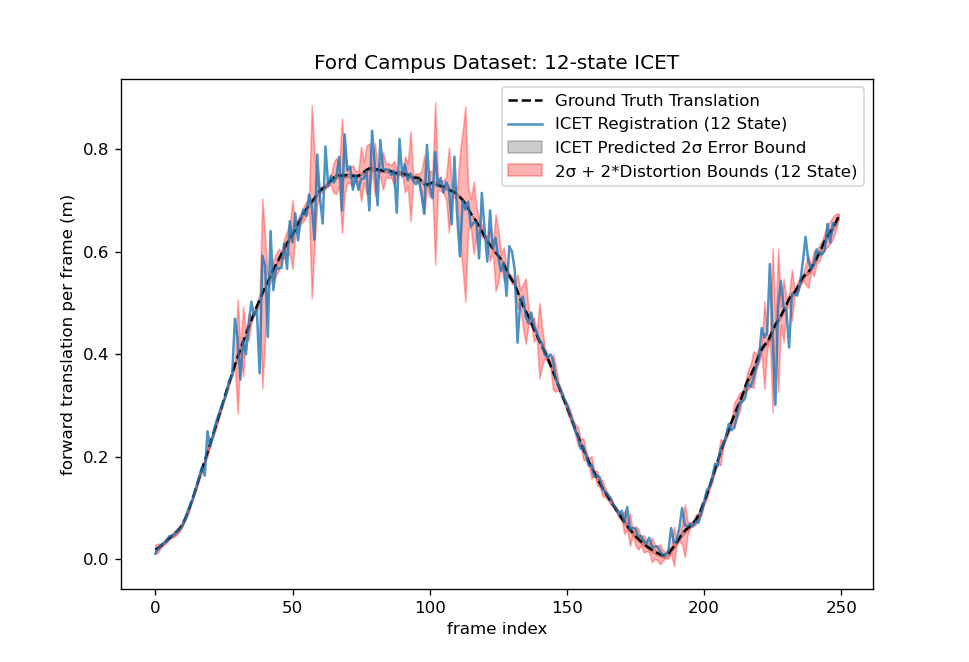

In [342]:
#plot updated bounds
pred_stds = np.loadtxt("../results/Ford_full_pred_stds_v10.txt")
pred_stds = pred_stds[(start_idx):(start_idx+runlen),:]
# start_idx = 990 #start on this scan
# runlen = 250

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ground_truth = np.loadtxt("/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/FORD_DS1_truth.txt")/10
ground_truth = tf.cast(tf.convert_to_tensor(ground_truth), tf.float32)
# gt = (ground_truth[i+start_idx,:] + ground_truth[i+start_idx+1,:])/2 #avg between pts
vf = (ground_truth[(start_idx+1):(start_idx+runlen+1),1] + ground_truth[start_idx:(start_idx+runlen),1])/2 #v5

ax.plot(vf, 'k--', label = 'Ground Truth Translation')
# ax.plot(estimates[start_idx:(start_idx+runlen),1], label = "ICET Estimated Translation (rigid)") #old rigid

ax.plot(X_hat_history[1:,0], alpha = 0.8, label = "ICET Registration (12 State)")
# ax.plot(X_hat_history_ICET[:,0], alpha = 0.8, label = "ICET Registration (6 State)") #same params as 12 state
# ax.plot(estimates[start_idx:(start_idx+runlen),1], alpha = 0.8, label = "ICET Registration (6 State)") #old full run optimized ICET
# ax.plot(seed_hist[:,0], 'k.', alpha = 0.3, label = "ICET initial seed" )


ax.fill_between(np.linspace(0,runlen-1,runlen),
                   vf - 2*pred_stds[:,1], vf + 2*pred_stds[:,1], 
                   color = [0,0,0], alpha = 0.2, label = 'ICET Predicted 2σ Error Bound')

# ax.fill_between(np.linspace(0,runlen-1,runlen),
#                    vf - m_hat_history[:,0], vf + m_hat_history[:,0], 
#                    color = [1,0,0], alpha = 0.3, label = 'Distortion Bounds (12 State)')
ax.fill_between(np.linspace(0,runlen-1,runlen),
                   vf - abs(2*m_hat_history[:,0])-2*abs(pred_stds[:,1]), 
                   vf + abs(2*m_hat_history[:,0]) + 2*abs(pred_stds[:,1]), 
                   color = [1,0,0], alpha = 0.3, label = '2σ + 2*Distortion Bounds (12 State)')

ax.set_title("Ford Campus Dataset: 12-state ICET")
ax.set_xlabel("frame index")
ax.set_ylabel("forward translation per frame (m)")
ax.legend(loc = 'best')

In [331]:
# np.save("sample_data/Ford_m_hat_history_12_state_ICET_990",  m_hat_history) #250 frames
# np.save("sample_data/Ford_X_hat_history_12_state_ICET_990",  X_hat_history) #250 frames

### DEBUG: run Vanilla ICET on Ford dataset and compare convergence with similar parameters 